# SW 1800

In [1]:
import numpy as np
import os
#import ipdb

def connect_dataset(file_list, icond_file_list, outputdir,
                    topodx=15, roi=2500, offset=5000,gclass_num=6,test_data_num=500):
    """
    複数のデータセットを連結する
    """
    #ipdb.set_trace()
    
    #Reading and combining files Decide start and end points of the learning area and convert them to grid numbers
    H = np.loadtxt(file_list[0], delimiter = ',')
    icond = np.loadtxt(icond_file_list[0], delimiter = ',')
    
    #Reading and combining files
    if len(file_list) > 1:
        for i in range(1, len(file_list)):
            H_temp = np.loadtxt(file_list[i], delimiter = ',')
            icond_temp = np.loadtxt(icond_file_list[i], delimiter = ',')
            H = np.concatenate((H,H_temp),axis=0)
            icond = np.concatenate((icond,icond_temp),axis = 0)
    
    roi_grids = int(roi / topodx)
    num_grids = int(H.shape[1] / gclass_num)
    H_subset = np.zeros([H.shape[0], roi_grids * gclass_num])
    for i in range(gclass_num):
        H_subset[:, i*roi_grids:(i+1)*roi_grids] = H[:, i*num_grids:(i*num_grids+roi_grids)]
    
    #Obtain the maximum and minimum values of data
    max_x = np.max(H_subset)
    min_x = np.min(H_subset)
    icond_max = np.max(icond, axis=0)
    icond_min = np.min(icond, axis=0)
    
    #Split the data into tests and training
    H_train = H_subset[0:-test_data_num,:]
    H_test = H_subset[H_subset.shape[0] - test_data_num:,:]
    icond_train = icond[0:-test_data_num,:]
    icond_test = icond[H.shape[0] - test_data_num:,:]
    
    #Save the data
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    np.savetxt(outputdir + '/x_train.txt',H_train,delimiter = ',')
    np.savetxt(outputdir + '/x_test.txt',H_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_train.txt',icond_train,delimiter = ',')
    np.savetxt(outputdir + '/icond_test.txt',icond_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_min.txt',icond_min,delimiter = ',')
    np.savetxt(outputdir + '/icond_max.txt',icond_max,delimiter = ',')
    np.savetxt(outputdir + '/x_minmax.txt',[min_x, max_x],delimiter = ',')
    
    
if __name__=="__main__":
    original_data_dir = "/home/rimali2009/Journal_2"
    parent_dir = "/home/rimali2009/Journal_2"
    if not os.path.exists(parent_dir):
        os.mkdir(parent_dir)
    outputdir = parent_dir + "/data_g6_j2_roi1800_2_TC_odaka_2_round1"
    file_list = ['/home/rimali2009/Journal_2/eta_5000_g6_300grid_j2_odaka_round_2200.csv']
    initial_conditions = ['/home/rimali2009/Journal_2/start_param_random_5000_j2_odaka_round_2200.csv']
    connect_dataset(file_list, initial_conditions, outputdir, test_data_num=500, gclass_num=6, topodx=15., roi=1800)

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  7 15:43:18 2017

@author: hanar
"""
import time
import numpy as np
import os
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.models import load_model
#from keras.utils.visualize_util import plot
import matplotlib.pyplot as plt
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

#Global variables for normalizing parameters
max_x = 1.0
min_x = 0.0
max_y = 1.0
min_y = 0.0


def deep_learning_tsunami(resdir, X_train_raw, y_train_raw, X_test_raw, y_test_raw,
                            _lr=0.02, _decay=0,
                            _validation_split=0.2, _batch_size=32,
                            _momentum=0.9, _nesterov=True,
                            num_layers=4, dropout=0.5,
                            node_num = 2500,
                            _epochs=2000):
    """
    Creating the inversion model of turbidity currents by deep learning
    """
    #Normalizing dataset
    X_train = get_normalized_data(X_train_raw, min_x, max_x)
    X_test = get_normalized_data(X_test_raw, min_x, max_x)
    y_train = get_normalized_data(y_train_raw, min_y, max_y)
    y_test = get_normalized_data(y_test_raw, min_y, max_y)
    
    #Generation of neural network model
    model = Sequential()
    model.add(Dense(node_num, input_dim=X_train.shape[1], activation='relu', kernel_initializer ='glorot_uniform'))#1st layer
    model.add(Dropout(dropout))
    for i in range(num_layers - 2):
        model.add(Dense(node_num, activation='relu', kernel_initializer ='glorot_uniform'))#2nd layer
        model.add(Dropout(dropout))
    model.add(Dense(y_train.shape[1], activation = 'relu', kernel_initializer ='glorot_uniform')) #last layer
    
    #Compiling the model
    model.compile(loss="mean_squared_error", 
              optimizer=SGD(lr=_lr, decay=_decay, momentum=_momentum, nesterov=_nesterov),
              #optimizer=Adadelta(),
              metrics=["mean_squared_error"])    
    
    #Perform learning
    t = time.time()
    check = ModelCheckpoint("model3.hdf5")
    #es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    #tb_cb = TensorBoard(log_dir=resdir, histogram_freq=2, write_graph=True, write_images=True)
    history = model.fit(X_train, y_train, epochs=_epochs, 
                    validation_split=_validation_split, batch_size=_batch_size,
                    callbacks=[check])
    
    #Evaluate learning result
    loss_and_metrics = model.evaluate(X_test,y_test)
    print("\nloss:{} mse:{}".format(loss_and_metrics[0],loss_and_metrics[1]))
    
    print("Elapsed time: {:.1f} sec.".format(time.time()-t))
    
    #Visualize learning result   
    #plot(model, to_file="model.png", show_shapes=True, show_layer_names=True)

    # model The state of change when letting you learnplot
    plot_history(history)
    
    return model, history

def apply_model(model, X, min_x, max_x, min_y, max_y):
    """
    Apply model
    Maximum and minimum values of X and Y are required to normalize
    """
    X_norm =  (X - min_x) / (max_x - min_x)
    Y_norm = model.predict(X_norm)
    Y = Y_norm*(max_y - min_y)+min_y
    return Y

def plot_history(history):
    # Plot accuracy history
    plt.plot(history.history['mean_squared_error'],"o-",label="mse")
    plt.plot(history.history['val_mean_squared_error'],"o-",label="val mse")
    plt.title('model mse')
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.legend(loc="upper right")
    plt.show()

#    # 損失の履歴をプロット
#    plt.plot(history.history['loss'],"o-",label="loss",)
#    plt.plot(history.history['val_loss'],"o-",label="val_loss")
#    plt.title('model loss')
#    plt.xlabel('epoch')
#    plt.ylabel('loss')
#    plt.legend(loc='upper right')
#    plt.show()

def test_model(model, x_test):
    #Test the results
    
    x_test_norm = get_normalized_data(x_test, min_x, max_x)
    test_result_norm = model.predict(x_test_norm)
    test_result = get_raw_data(test_result_norm, min_y, max_y)
    
    return test_result


def save_result(savedir, model, history, test_result):
    
    
    np.savetxt(savedir + 'test_result.txt',test_result,delimiter=',')
    np.savetxt(savedir+'loss.txt',history.history.get('loss'),delimiter=',')
    np.savetxt(savedir+'val_loss.txt',history.history.get('val_loss'),delimiter=',')
    
    #Serialize model and save
    print('save the model')
    model.save(savedir + 'model3.hdf5')

def load_data(datadir):
    """
    This function load training and test data sets, and returns variables
    """
    global min_x, max_x, min_y, max_y
    
    x_train = np.loadtxt(datadir + 'x_train.txt',delimiter=',')
    x_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
    y_train = np.loadtxt(datadir + 'icond_train.txt',delimiter=',')
    y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
    min_y = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
    max_y = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')
    [min_x, max_x] = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
    
    return x_train, y_train, x_test, y_test

def set_minmax_data(_min_x, _max_x, _min_y, _max_y):
    global min_x, max_x, min_y, max_y
    
    min_x, max_x, min_y, max_y = _min_x, _max_x, _min_y, _max_y
    return
    


def get_normalized_data(x, min_val, max_val):
    """
    Normalizing the training and test dataset
    """
    x_norm = (x - min_val) / (max_val - min_val)
    
    return x_norm

def get_raw_data(x_norm, min_val, max_val):
    """
    Get raw data from the normalized dataset
    """
    x = x_norm * (max_val - min_val) + min_val
    
    return x

if __name__ == "__main__":
    
    #Reading data  
    datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1800_2_TC_odaka_2_round1/'
    resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1800_2_TC_odaka_2_round1/'
    if not os.path.exists(resdir):
        os.mkdir(resdir)
    
    x_train, y_train, x_test, y_test = load_data(datadir)
    
     
    #Execution of learning
    testcases = [5000]
    for i in range(len(testcases)):
        resdir_case = resdir + '{}/'.format(testcases[i])        
        if not os.path.exists(resdir_case):
            os.mkdir(resdir_case)
        x_train_sub = x_train[0:testcases[i],:]
        y_train_sub = y_train[0:testcases[i],:]
        model, history = deep_learning_tsunami(resdir_case, x_train_sub, y_train_sub, x_test, y_test, num_layers=5)
        #Verify and save results
        result = test_model(model, x_test)
        save_result(resdir_case,model,history,result)
        

Using TensorFlow backend.


Train on 3600 samples, validate on 900 samples
Epoch 1/2000
3600/3600 [==============================] - 3s 806us/step - loss: 0.0976 - mean_squared_error: 0.0976 - val_loss: 0.0728 - val_mean_squared_error: 0.0728
Epoch 2/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0709 - mean_squared_error: 0.0709 - val_loss: 0.0642 - val_mean_squared_error: 0.0642
Epoch 3/2000
3600/3600 [==============================] - 1s 270us/step - loss: 0.0644 - mean_squared_error: 0.0644 - val_loss: 0.0569 - val_mean_squared_error: 0.0569
Epoch 4/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0582 - mean_squared_error: 0.0582 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 5/2000
3600/3600 [==============================] - 1s 267us/step - loss: 0.0530 - mean_squared_error: 0.0530 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 6/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0483 - mean_squared_error: 0.04

3600/3600 [==============================] - 1s 274us/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 98/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 99/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 100/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 101/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 102/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0079 - val_mean_squared_error: 0.00

3600/3600 [==============================] - 1s 274us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 194/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 195/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 196/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 197/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 198/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0043 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 274us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 290/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 291/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 292/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 293/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 294/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0040 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 275us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 386/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 387/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 388/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 389/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 390/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0031 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 274us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 482/2000
3600/3600 [==============================] - 1s 278us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 483/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 484/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 485/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 486/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0026 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 276us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 578/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 579/2000
3600/3600 [==============================] - 1s 278us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 580/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 581/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 582/2000
3600/3600 [==============================] - 1s 272us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0027 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 276us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 674/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 675/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 676/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 677/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 678/2000
3600/3600 [==============================] - 1s 278us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0022 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 276us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 770/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 771/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 772/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 773/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 774/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0024 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 276us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 866/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 867/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 868/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 869/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 870/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0017 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 273us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 962/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 963/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 964/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 965/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 966/2000
3600/3600 [==============================] - 1s 272us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0018 - val_mean_squared_error: 0.

3600/3600 [==============================] - 1s 275us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1058/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1059/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1060/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1061/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1062/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0018 - val_mean_squared_erro

3600/3600 [==============================] - 1s 279us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1106/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1107/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1108/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1109/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1110/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0019 - val_mean_squared_erro

3600/3600 [==============================] - 1s 273us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1154/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1155/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1156/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1157/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1158/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0018 - val_mean_squared_erro

3600/3600 [==============================] - 1s 273us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1202/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1203/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1204/2000
3600/3600 [==============================] - 1s 278us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1205/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1206/2000
3600/3600 [==============================] - 1s 278us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0016 - val_mean_squared_erro

3600/3600 [==============================] - 1s 274us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1250/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 1251/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1252/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1253/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1254/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0019 - val_mean_squared_erro

3600/3600 [==============================] - 1s 278us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 1298/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1299/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1300/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1301/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1302/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0017 - val_mean_squared_erro

3600/3600 [==============================] - 1s 276us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1346/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1347/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1348/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1349/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1350/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0018 - val_mean_squared_erro

3600/3600 [==============================] - 1s 278us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1394/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1395/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1396/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1397/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1398/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0018 - val_mean_squared_erro

3600/3600 [==============================] - 1s 275us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1442/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1443/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1444/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1445/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1446/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0015 - val_mean_squared_erro

3600/3600 [==============================] - 1s 263us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1490/2000
3600/3600 [==============================] - 1s 263us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1491/2000
3600/3600 [==============================] - 1s 264us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1492/2000
3600/3600 [==============================] - 1s 262us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1493/2000
3600/3600 [==============================] - 1s 263us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1494/2000
3600/3600 [==============================] - 1s 262us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0014 - val_mean_squared_erro

3600/3600 [==============================] - 1s 274us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1538/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1539/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1540/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1541/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1542/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0014 - val_mean_squared_erro

3600/3600 [==============================] - 1s 276us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1586/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1587/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1588/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1589/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1590/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0017 - val_mean_squared_erro

3600/3600 [==============================] - 1s 276us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1634/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1635/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1636/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1637/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1638/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0015 - val_mean_squared_erro

3600/3600 [==============================] - 1s 276us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1682/2000
3600/3600 [==============================] - 1s 282us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 1683/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1684/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1685/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1686/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0015 - val_mean_squared_erro

3600/3600 [==============================] - 1s 278us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1730/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1731/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1732/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1733/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1734/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0014 - val_mean_squared_erro

3600/3600 [==============================] - 1s 276us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1778/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1779/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1780/2000
3600/3600 [==============================] - 1s 279us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1781/2000
3600/3600 [==============================] - 1s 278us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1782/2000
3600/3600 [==============================] - 1s 277us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0016 - val_mean_squared_erro

3600/3600 [==============================] - 1s 277us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1826/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1827/2000
3600/3600 [==============================] - 1s 278us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1828/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1829/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 1830/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0012 - val_mean_squared_erro

3600/3600 [==============================] - 1s 277us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1874/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1875/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1876/2000
3600/3600 [==============================] - 1s 279us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1877/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 1878/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0016 - val_mean_squared_erro

3600/3600 [==============================] - 1s 275us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1922/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1923/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1924/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1925/2000
3600/3600 [==============================] - 1s 275us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1926/2000
3600/3600 [==============================] - 1s 274us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0013 - val_mean_squared_erro

3600/3600 [==============================] - 1s 274us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1970/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1971/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1972/2000
3600/3600 [==============================] - 1s 273us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1973/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1974/2000
3600/3600 [==============================] - 1s 276us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0012 - val_mean_squared_erro

<Figure size 640x480 with 1 Axes>

save the model


(500, 9)


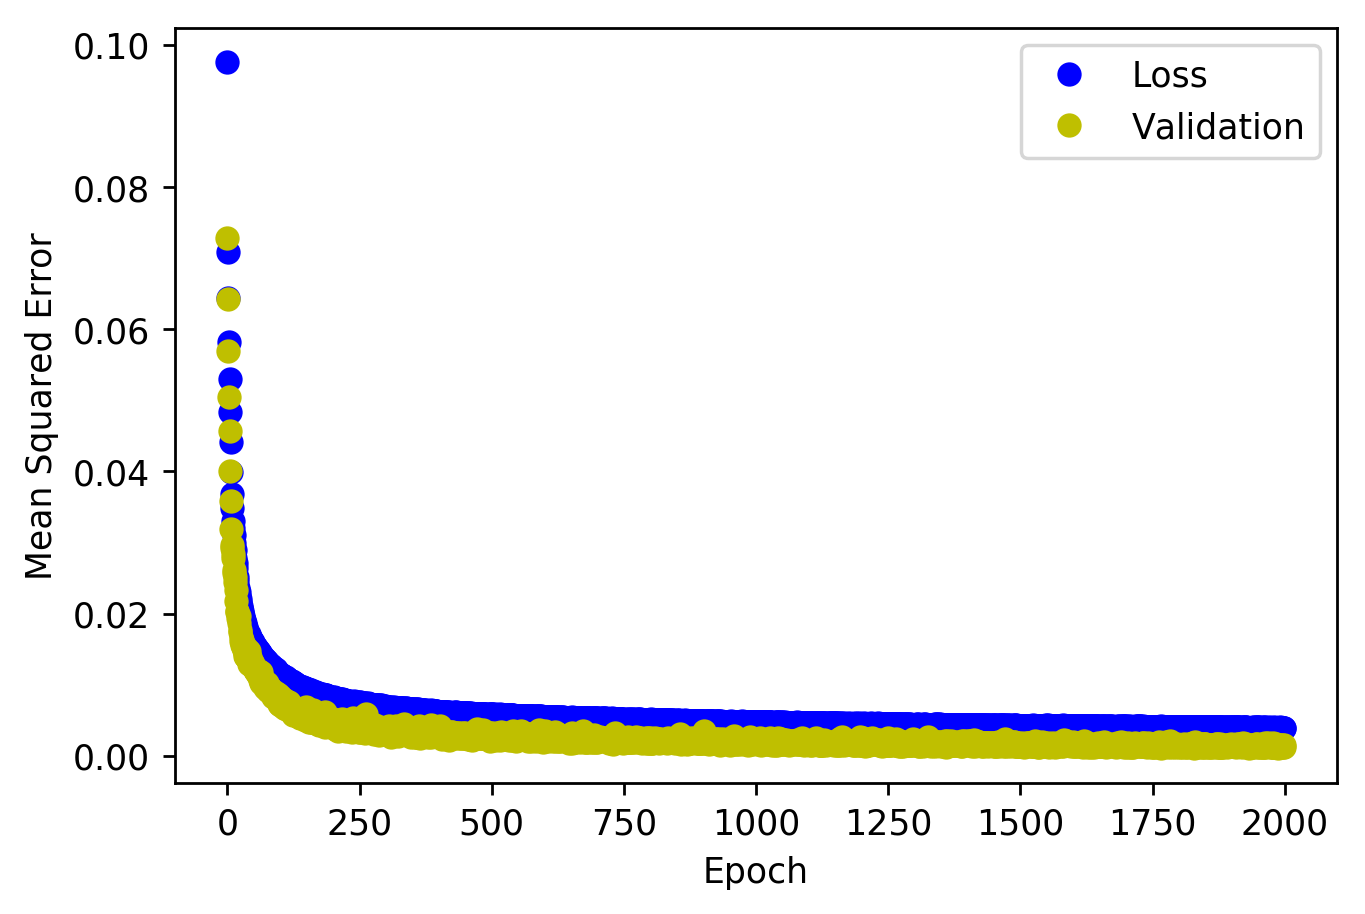

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

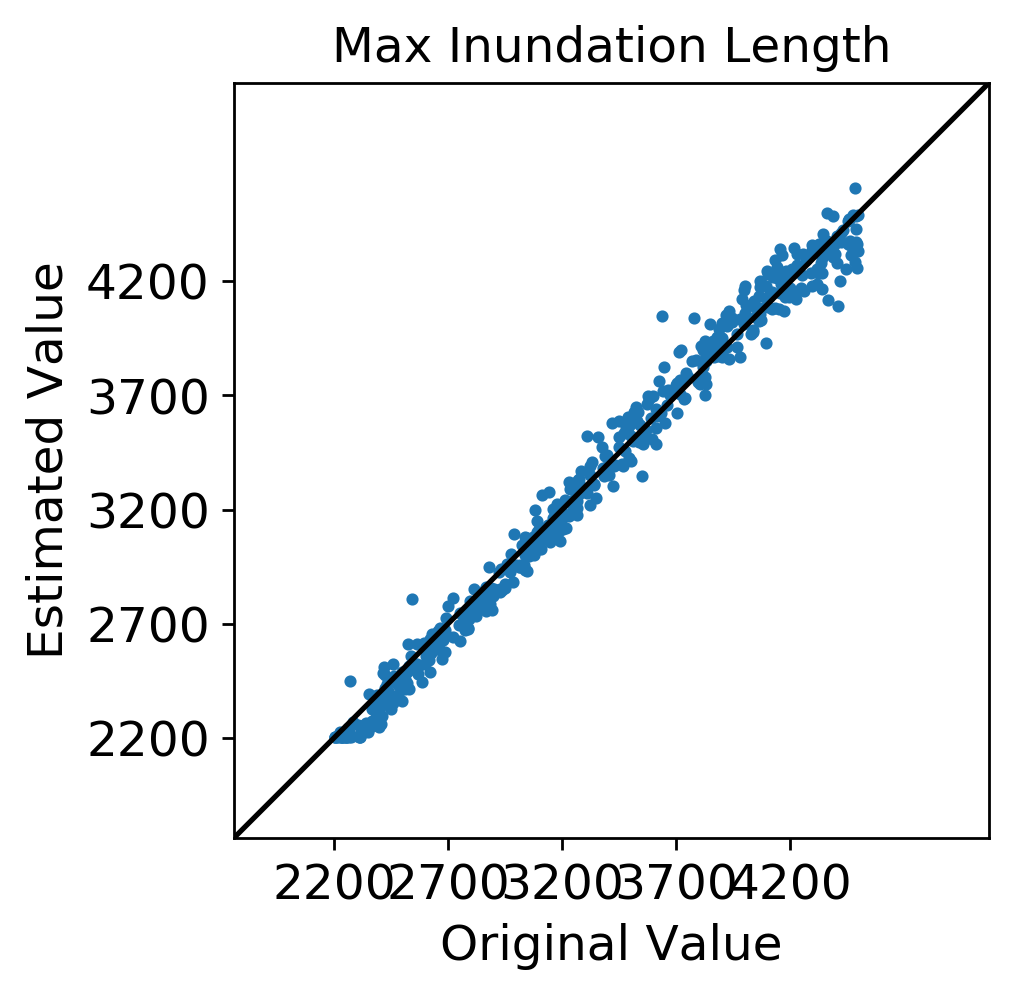

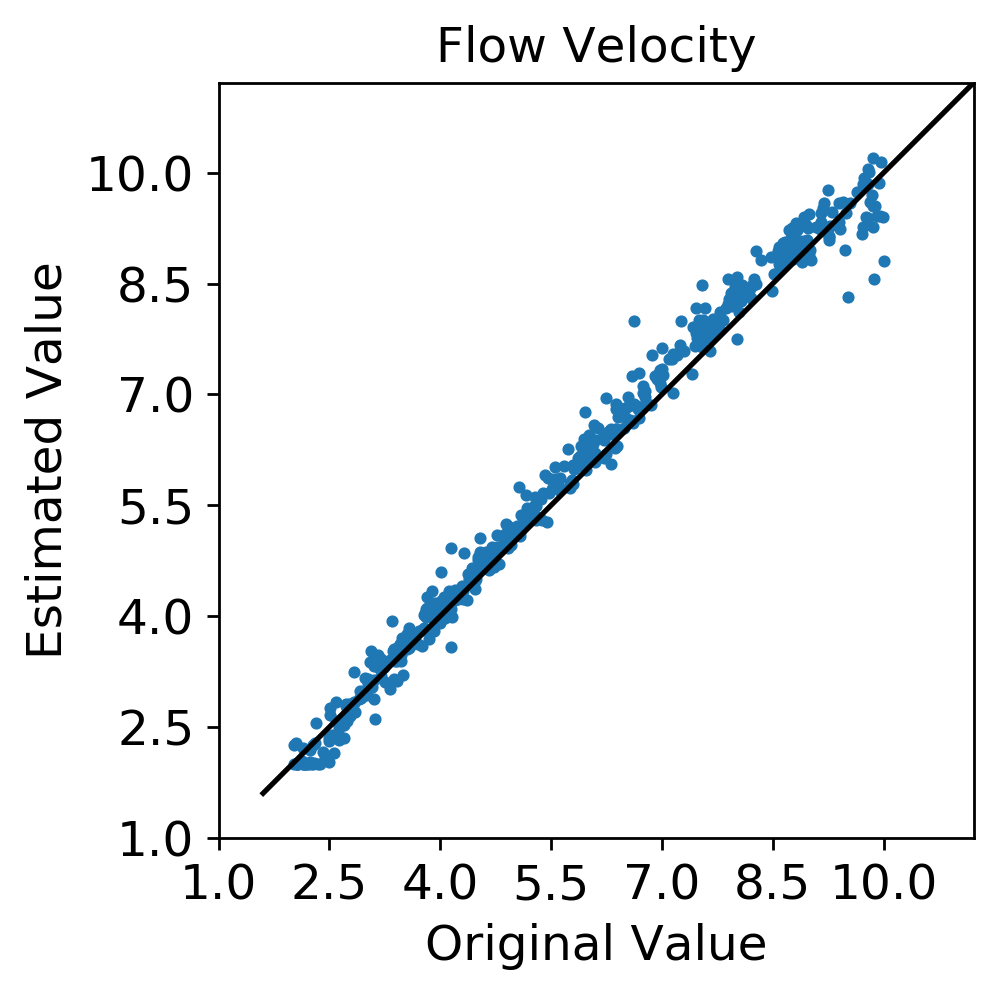

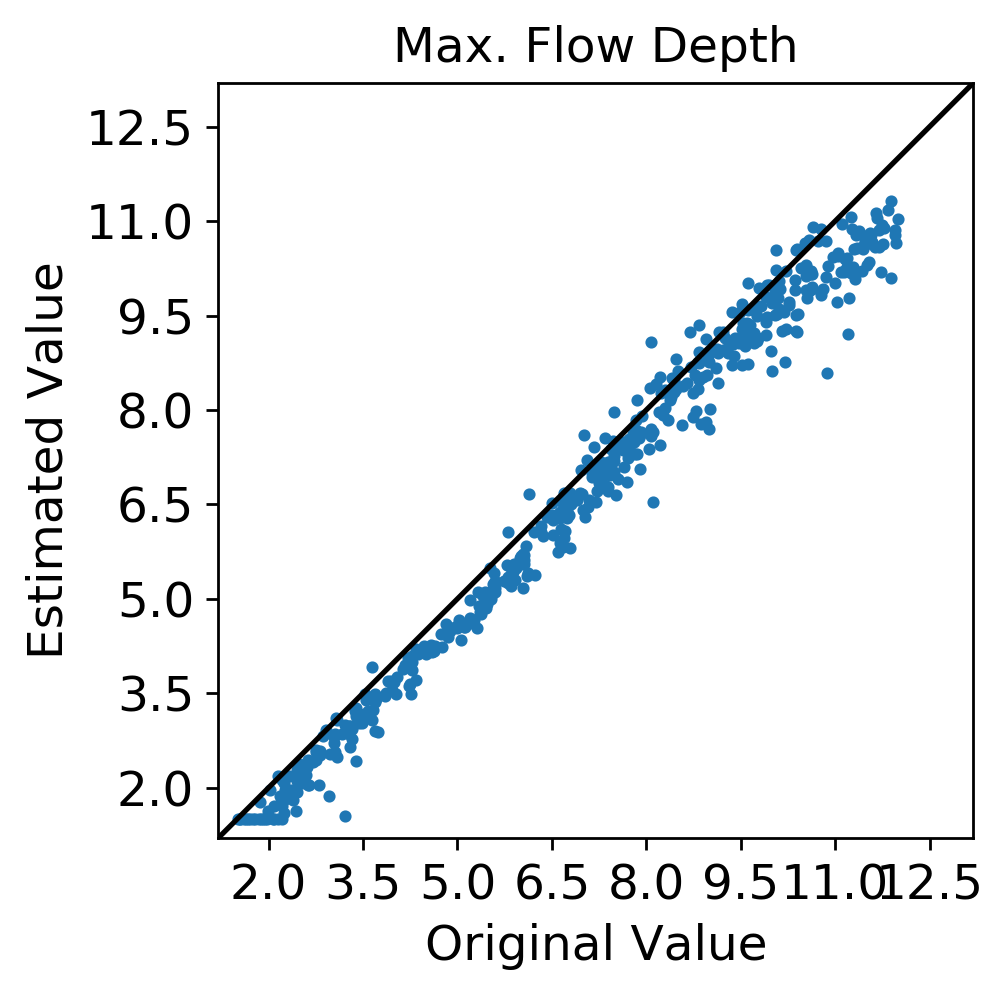

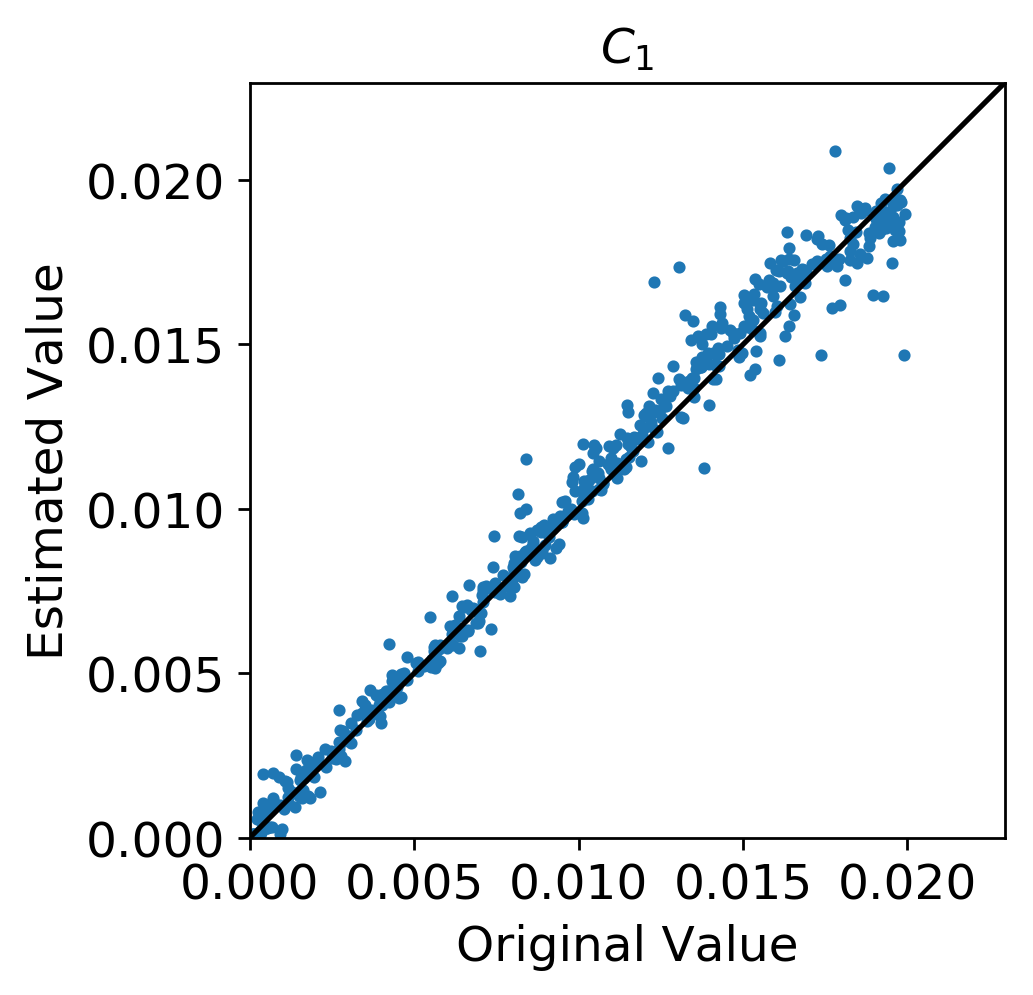

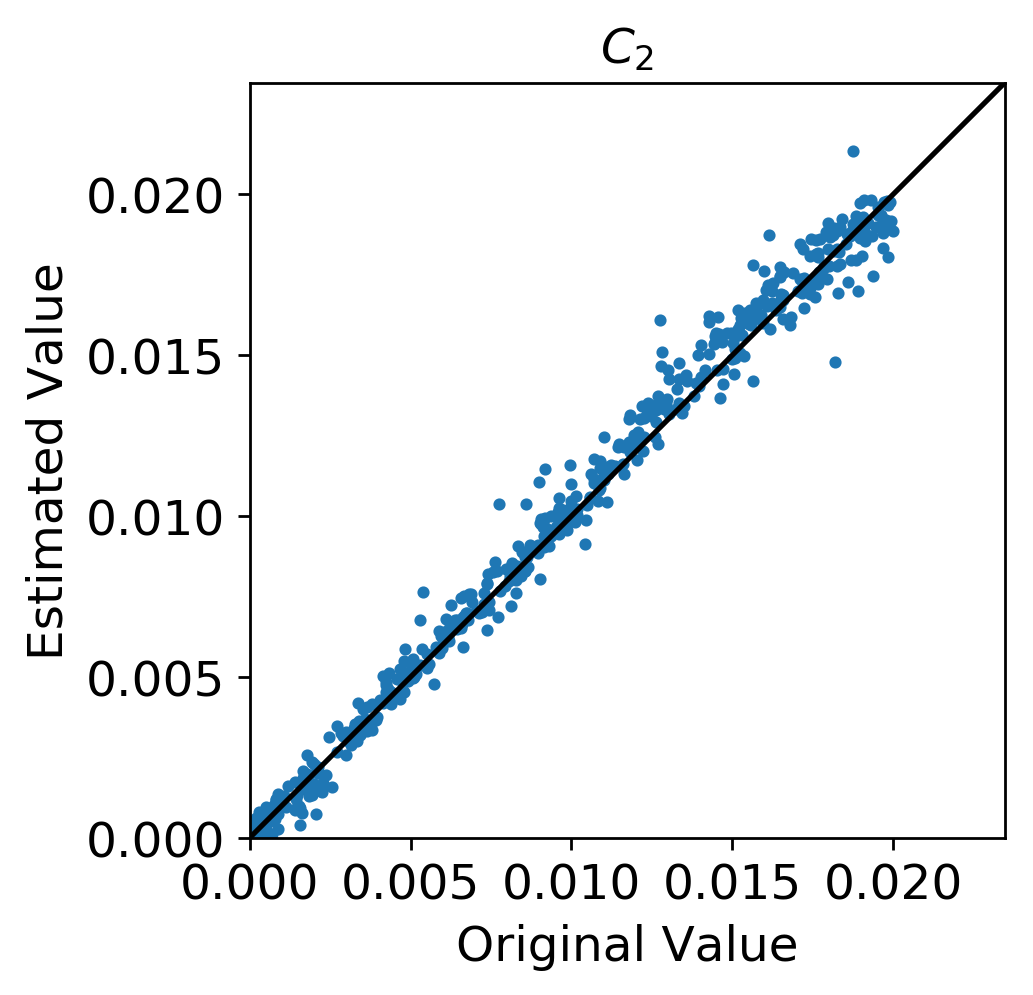

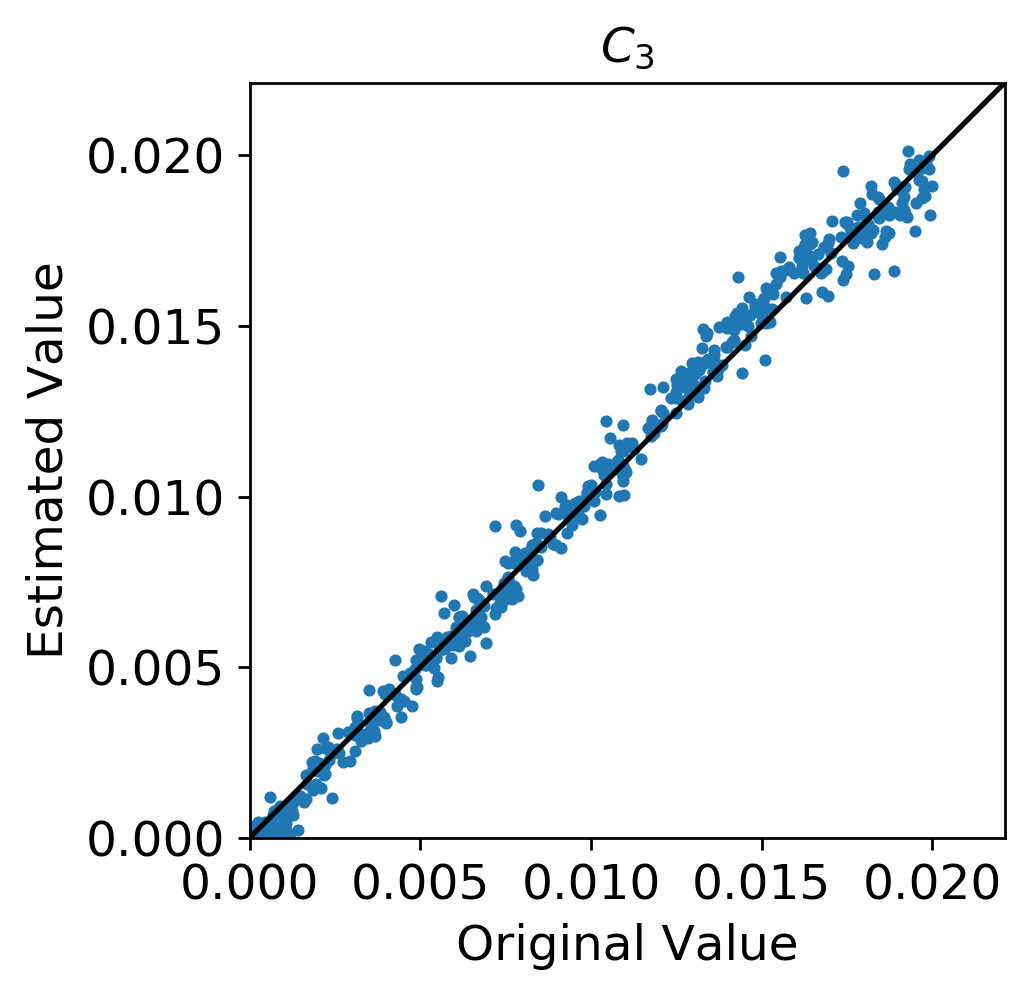

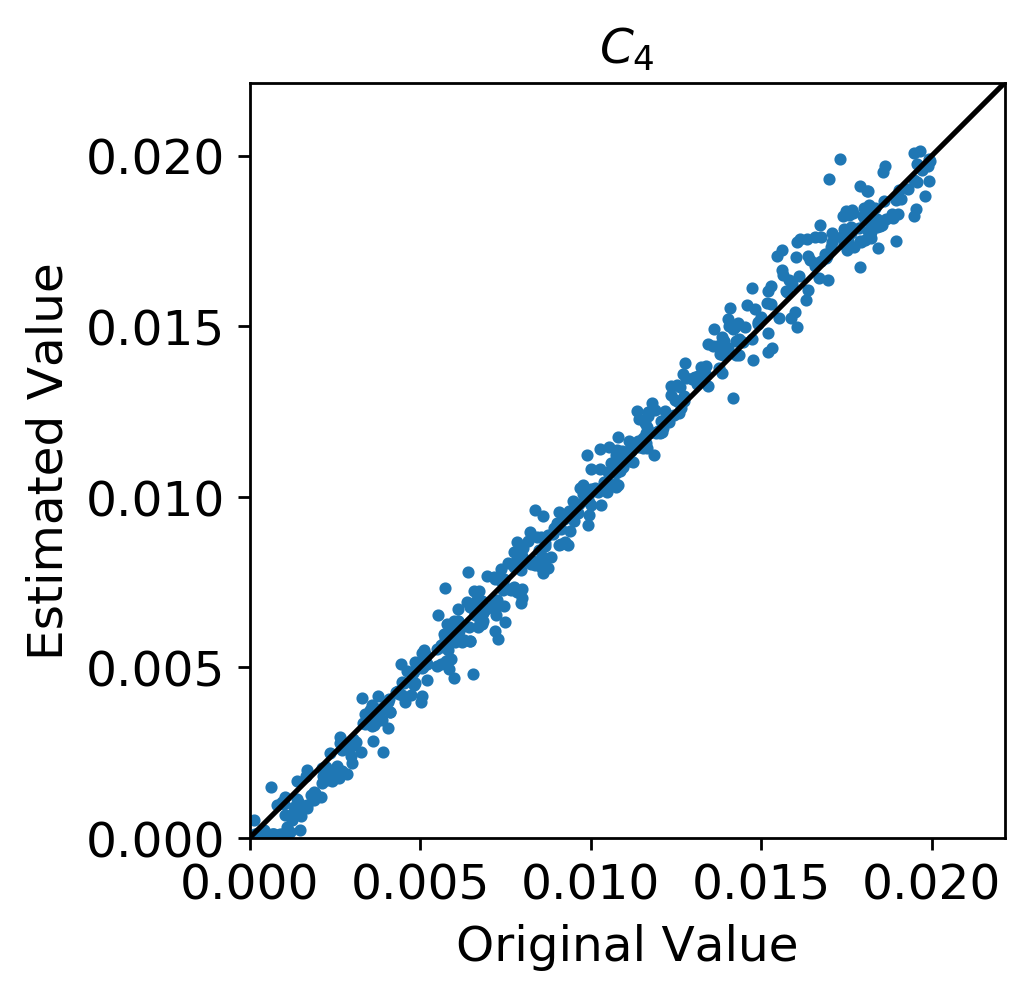

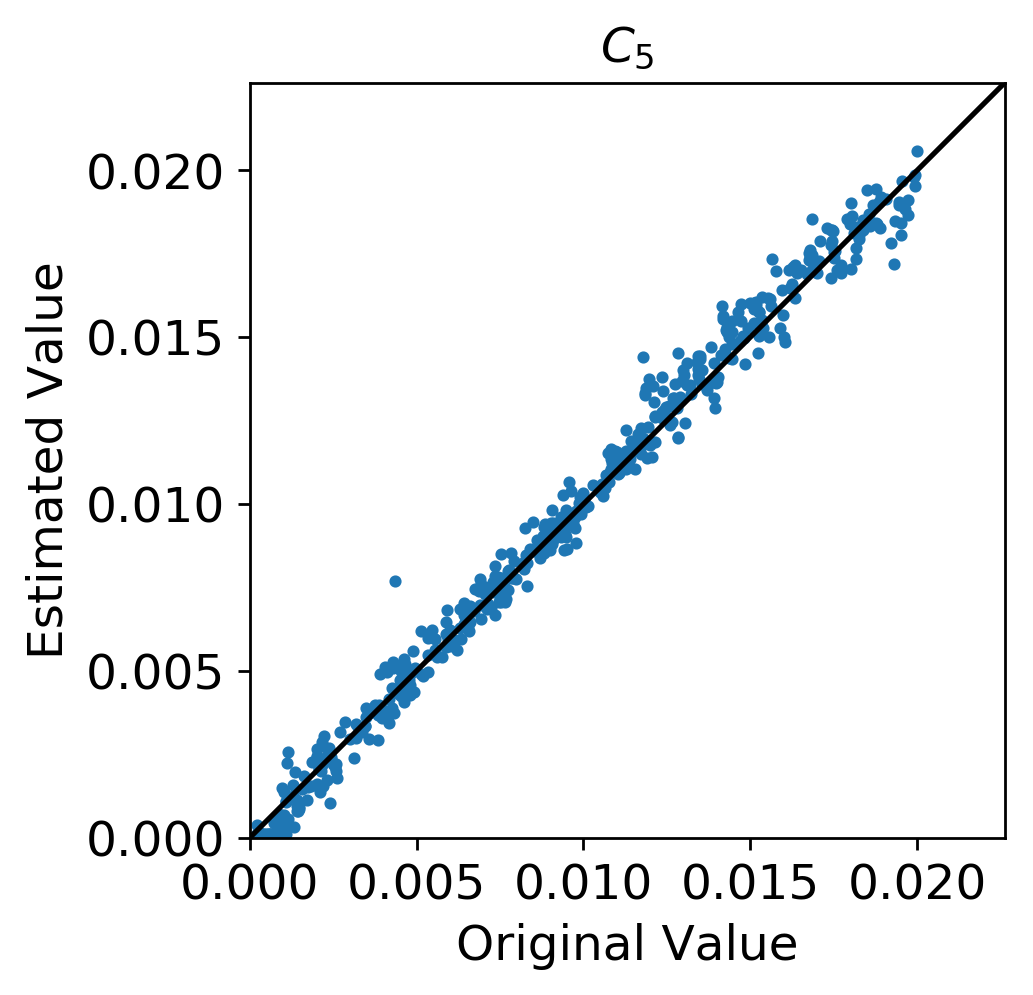

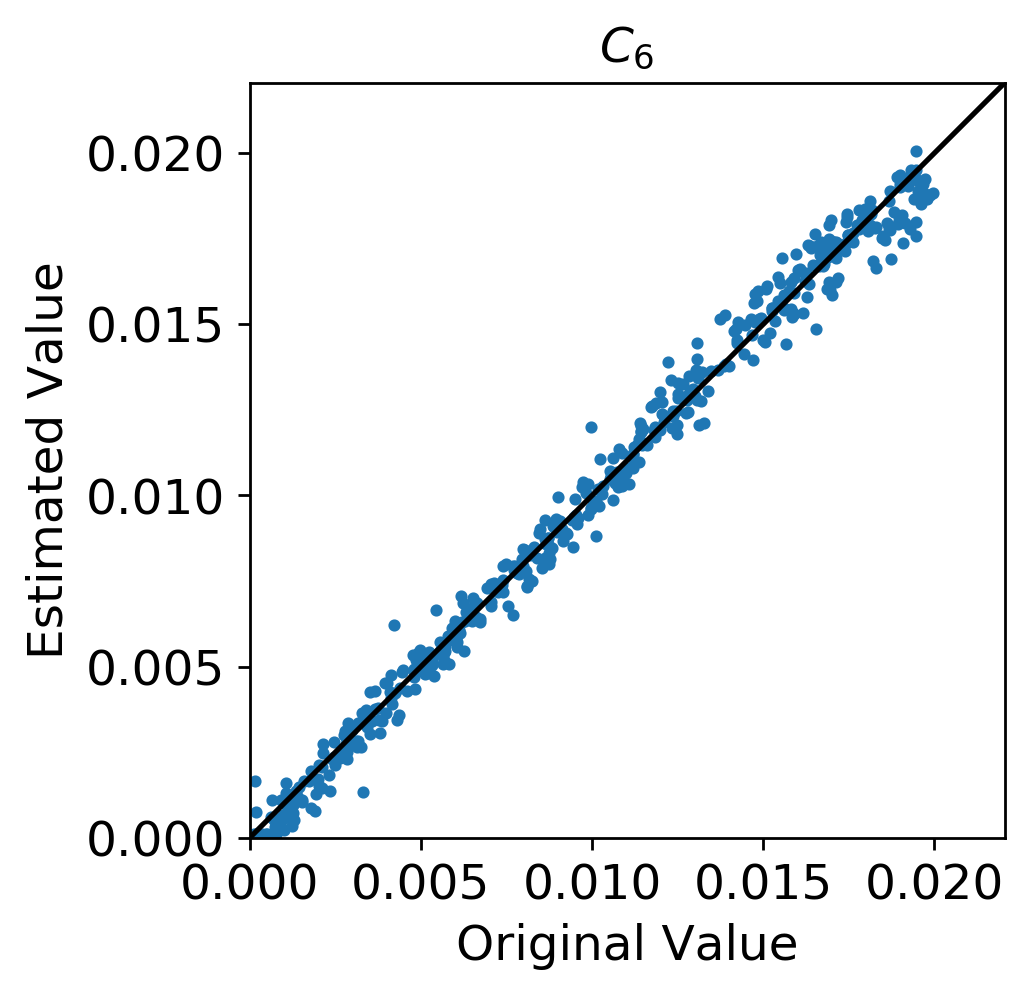

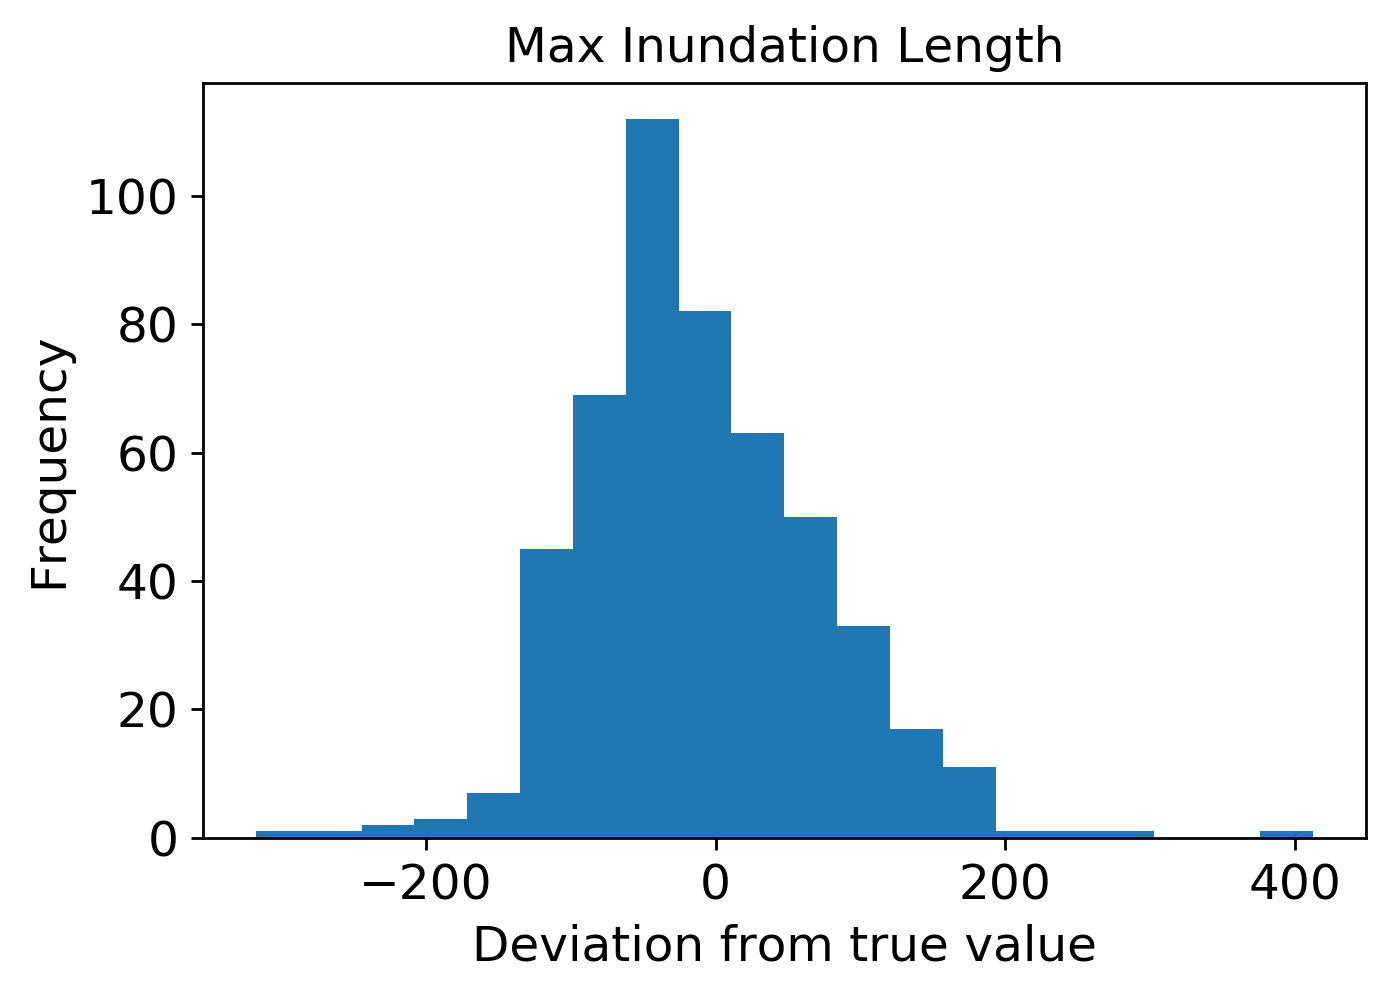

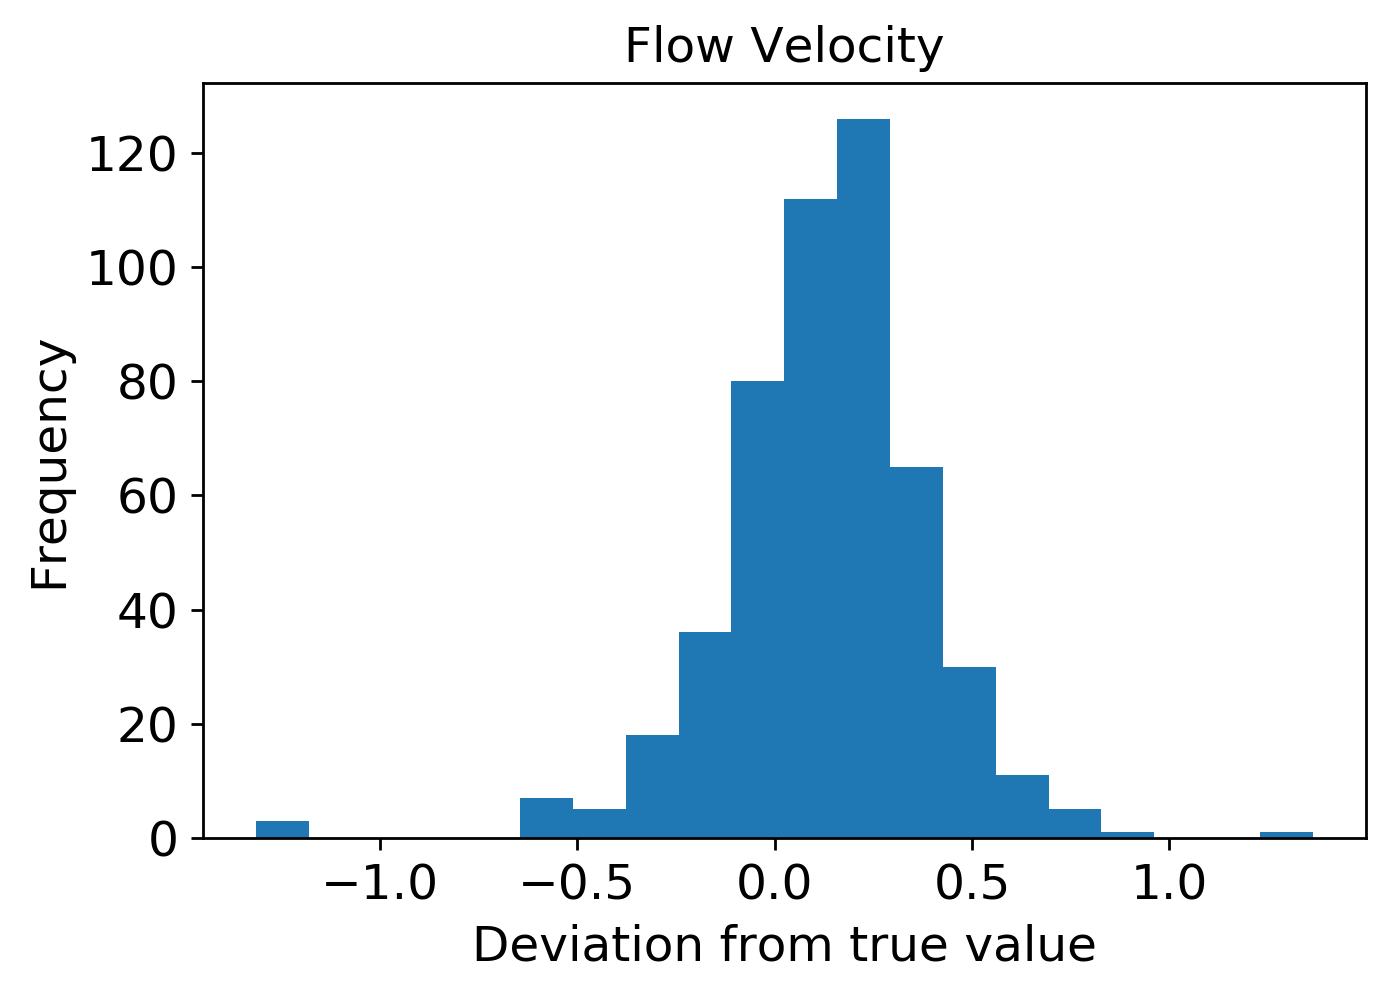

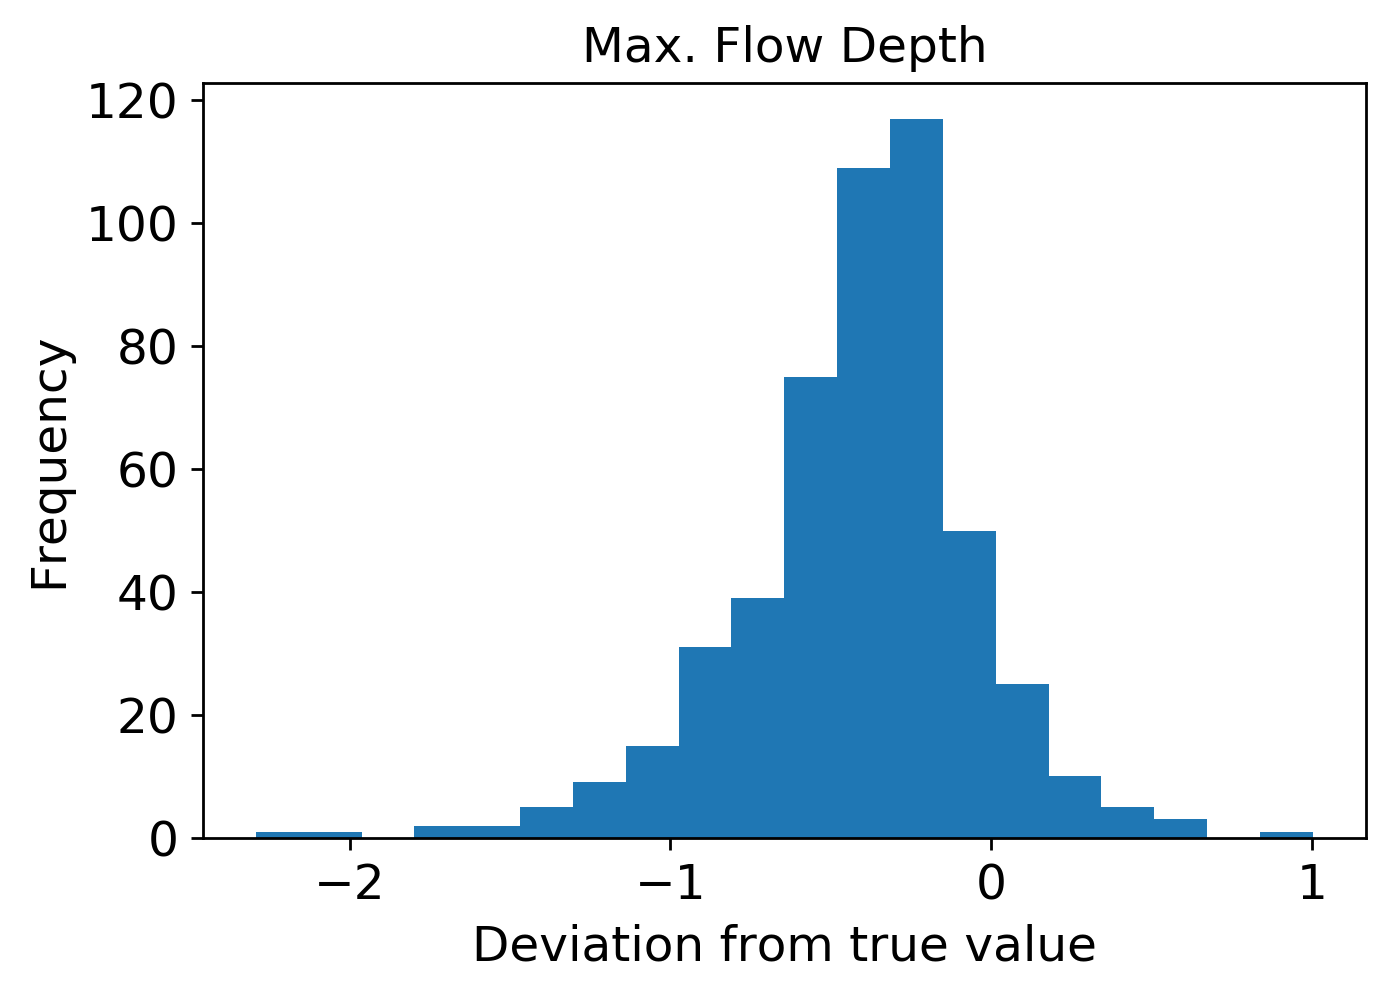

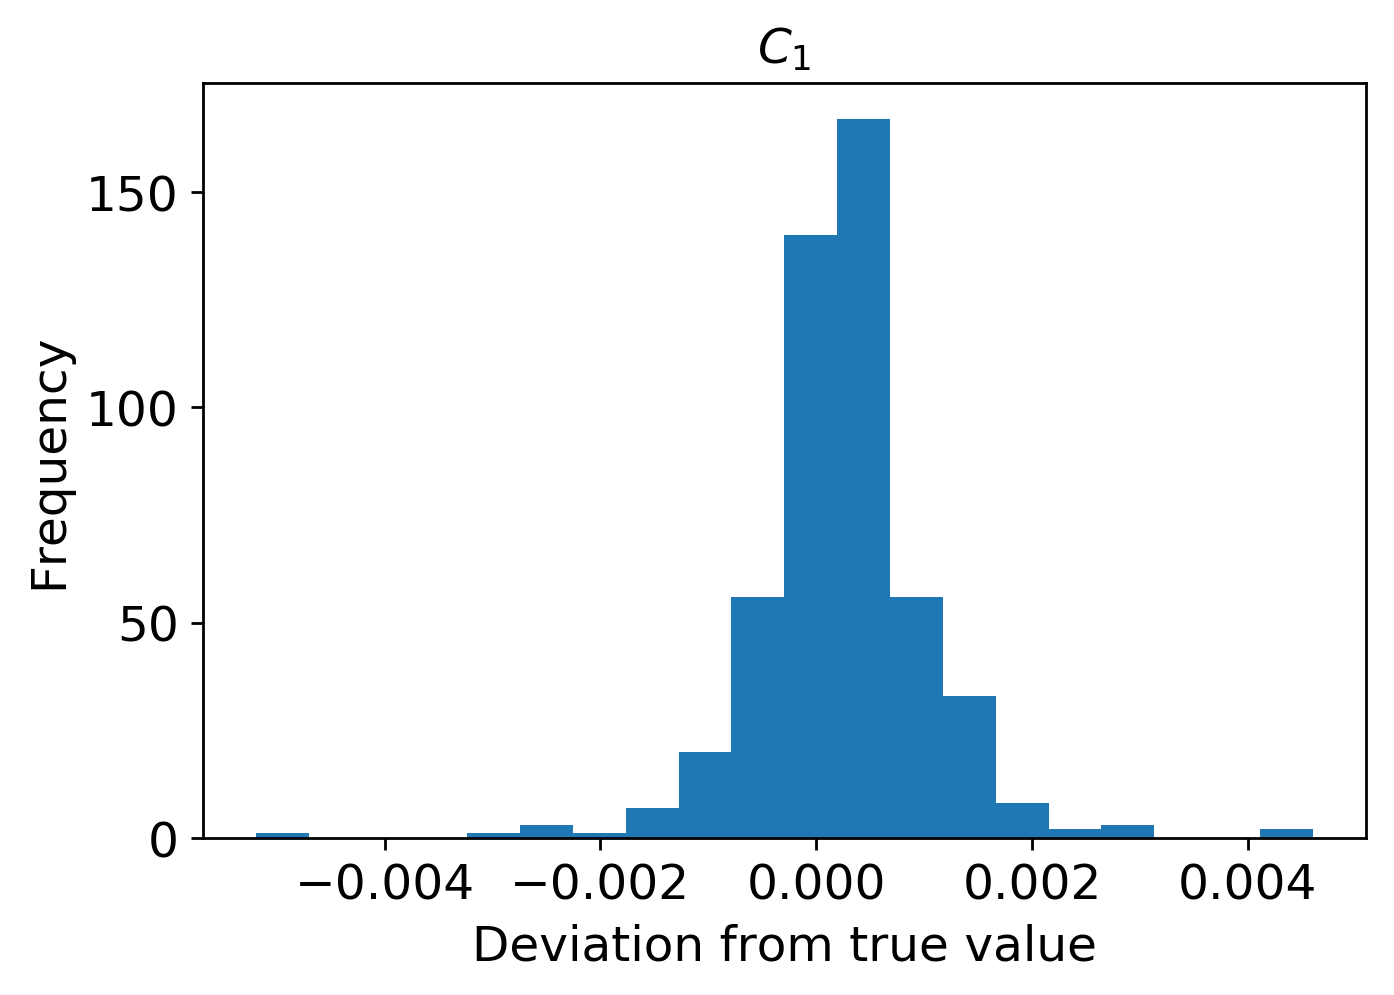

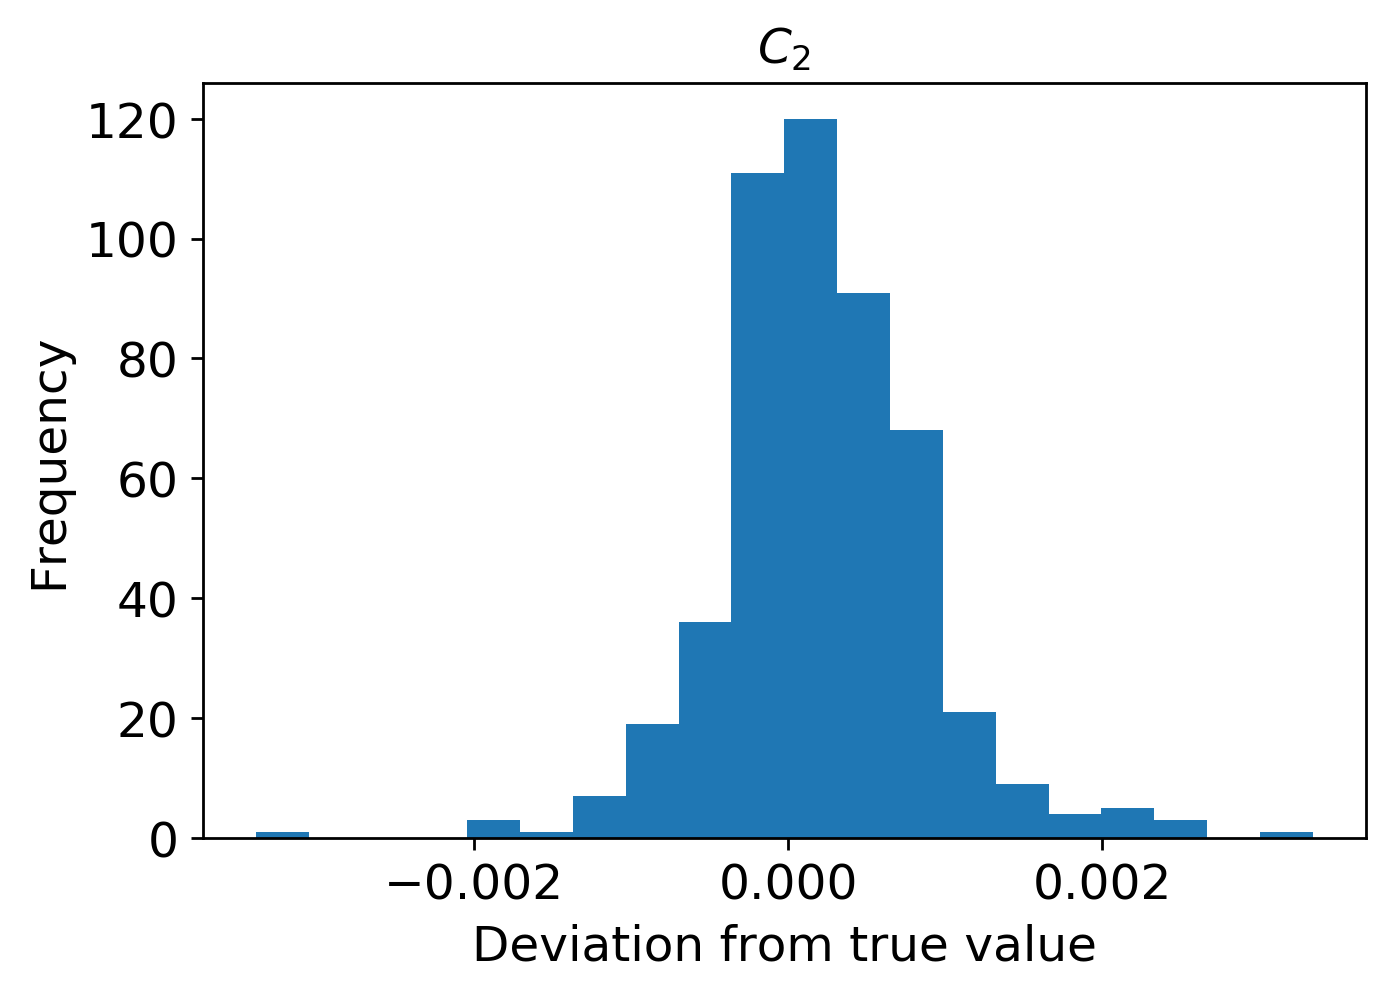

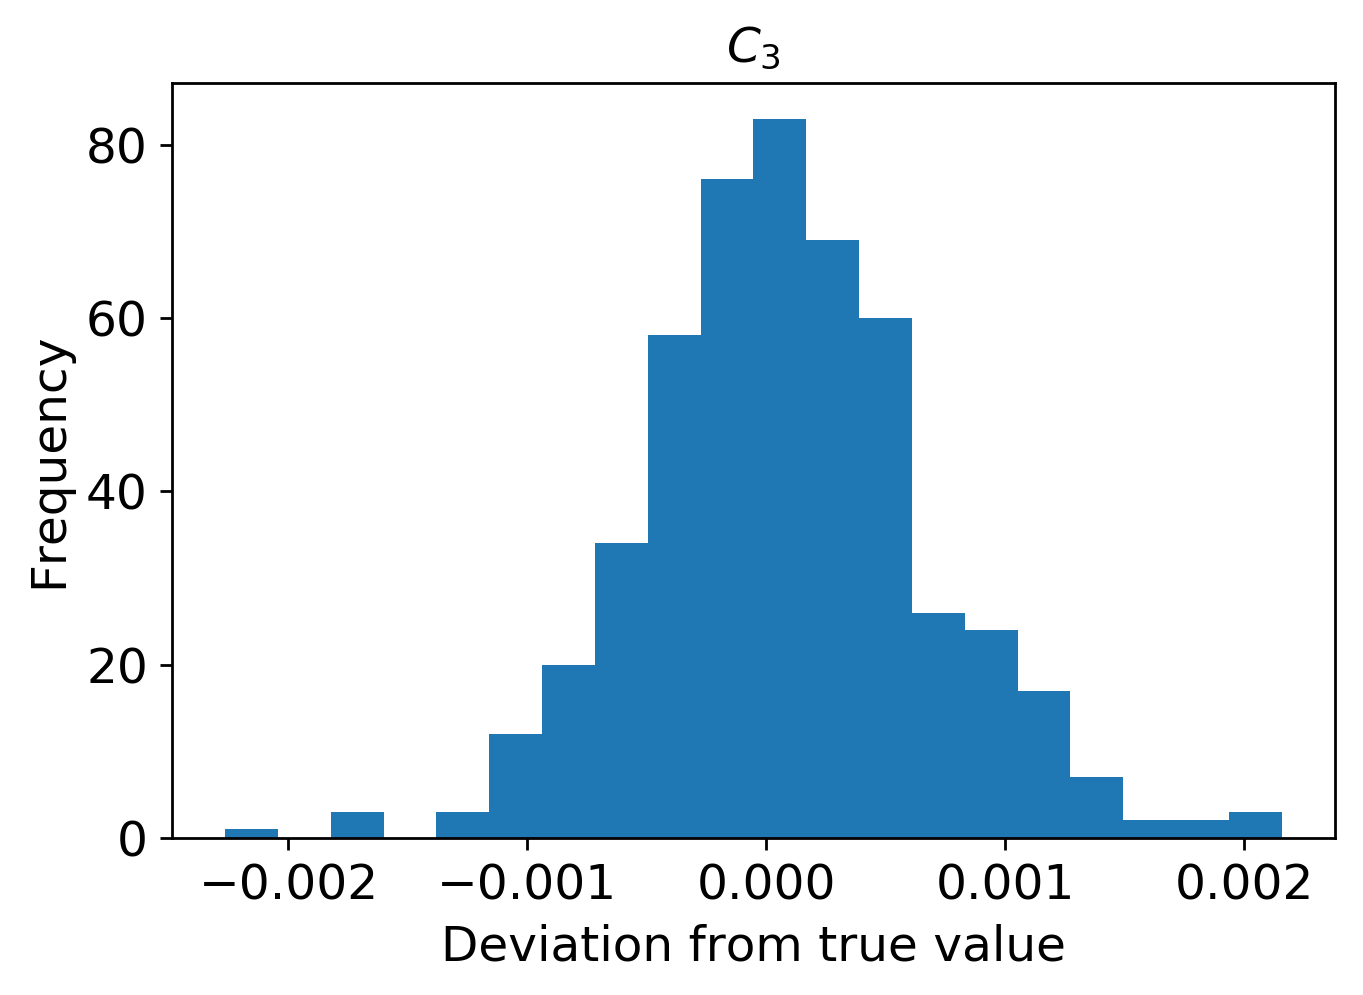

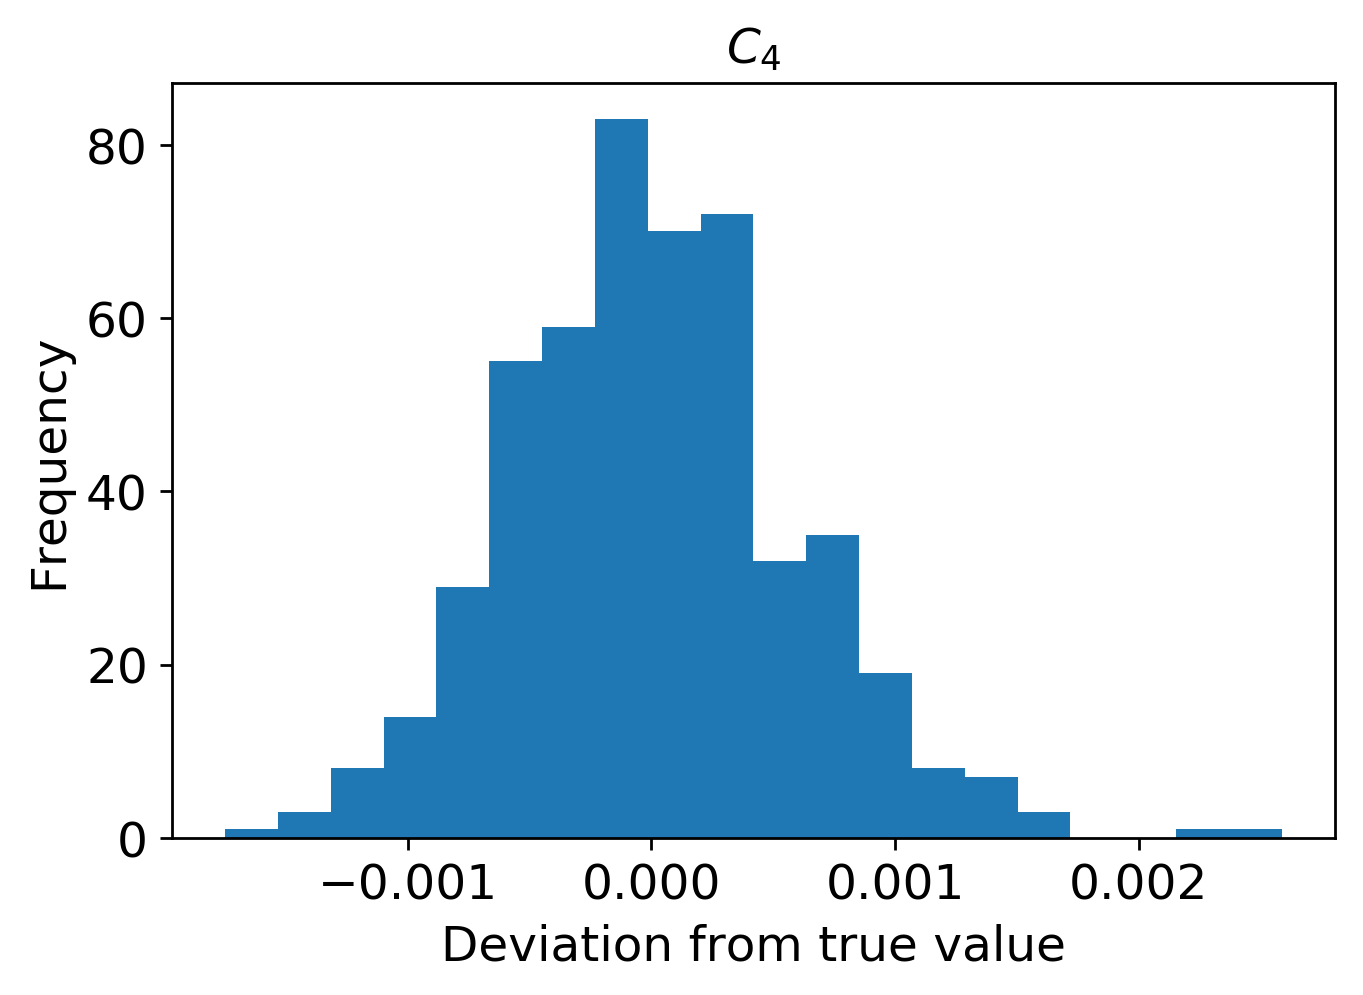

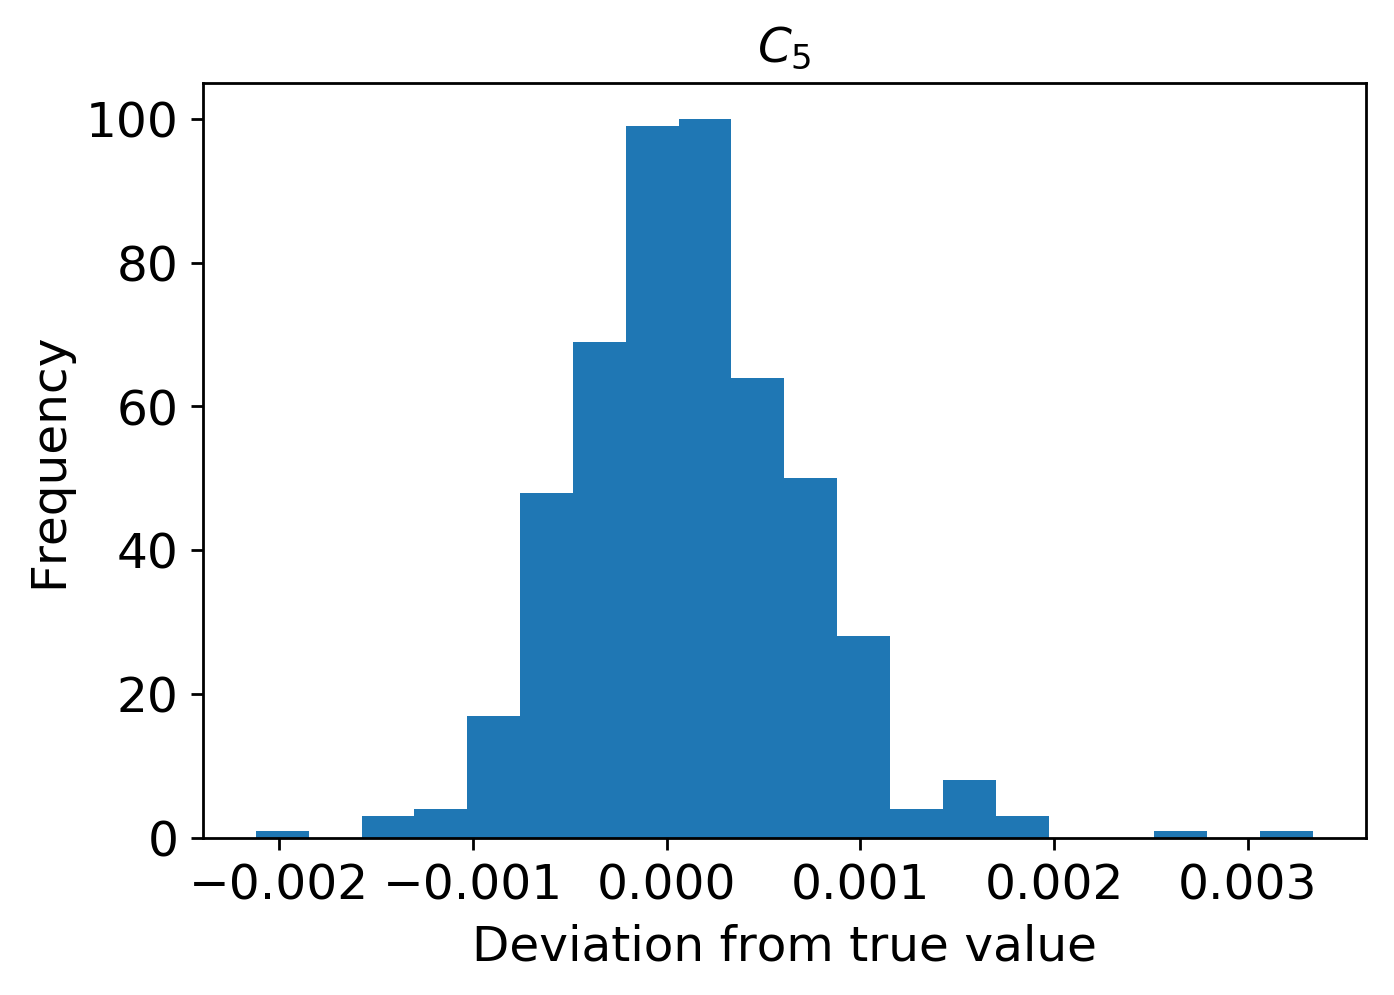

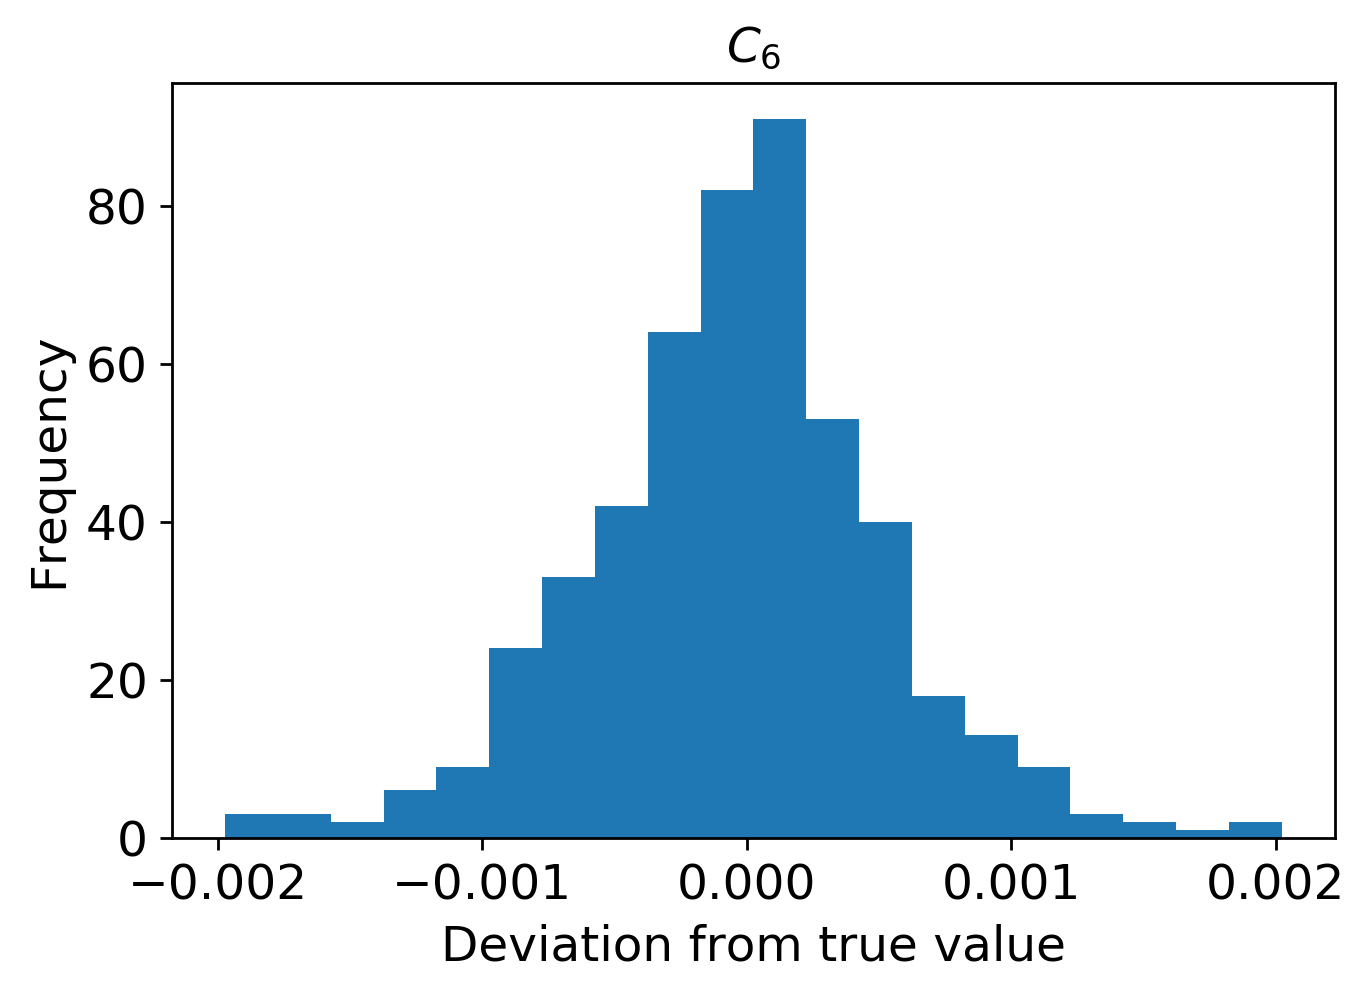

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb
%matplotlib inline

datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1800_2_TC_odaka_2_round1/'
resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1800_2_TC_odaka_2_round1/5000/'

test_result = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
icond = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
print(icond.shape)
loss = np.loadtxt(resdir+'loss.txt',delimiter=',')
epoch = range(0,2000)
vloss = np.loadtxt(resdir+'val_loss.txt',delimiter=',')
resi = test_result - icond

fig = plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
plt.plot(epoch, loss, 'bo',label='Loss')
plt.plot(epoch, vloss, 'yo',label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend(loc="upper right")
plt.savefig(resdir+ 'mse.pdf')
plt.show()

fig2 = plt.figure()
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', '$C_1$', '$C_2$', '$C_3$', '$C_4$','$C_5$','$C_6$']
xymin=[2200,2.0,1.5,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001]
xymax=[4500,10.0,12.0,0.02,0.02,0.02,0.02,0.02,0.02]
xstep=[500,1.5,1.5,0.005,0.005,0.005,0.005,0.005,0.005]
stepmin=[2200,1.0,2.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0000]
stepmax=[4550,10.5,13.0,0.025,0.025,0.025,0.025,0.025,0.025]

    
for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.plot(icond[:,i],test_result[:,i],"o",markersize = 2.5)
    x=icond[:,i]
    y=test_result[:,i]
    max_value = np.max([x, y])
    min_value = np.min([x, y])
    y_lim = plt.ylim([min_value * 0.8, max_value * 1.1])
    x_lim = plt.xlim([min_value * 0.8, max_value * 1.1])
    plt.plot(x_lim, y_lim, 'k-', color = 'k')
    #plt.plot([xymin[i],xymax[i]],[xymin[i],xymax[i]],"-",color = 'k')
    plt.axes().set_aspect('equal')
    plt.xticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.yticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.xlabel('Original Value',color=textcol,size=14,**hfont)
    plt.ylabel('Estimated Value',color=textcol,size=14,**hfont)
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + '.eps')
    plt.savefig(resdir+titlelabel[i] + '.pdf')
    #plt.show()

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.pdf')
    plt.show()

(500, 9)
Standard Deviation: 81.74104984670157
Standard Deviation sample: 81.82291371283394
Mean: -9.996092840855342
CV: -8.185489572326995


/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


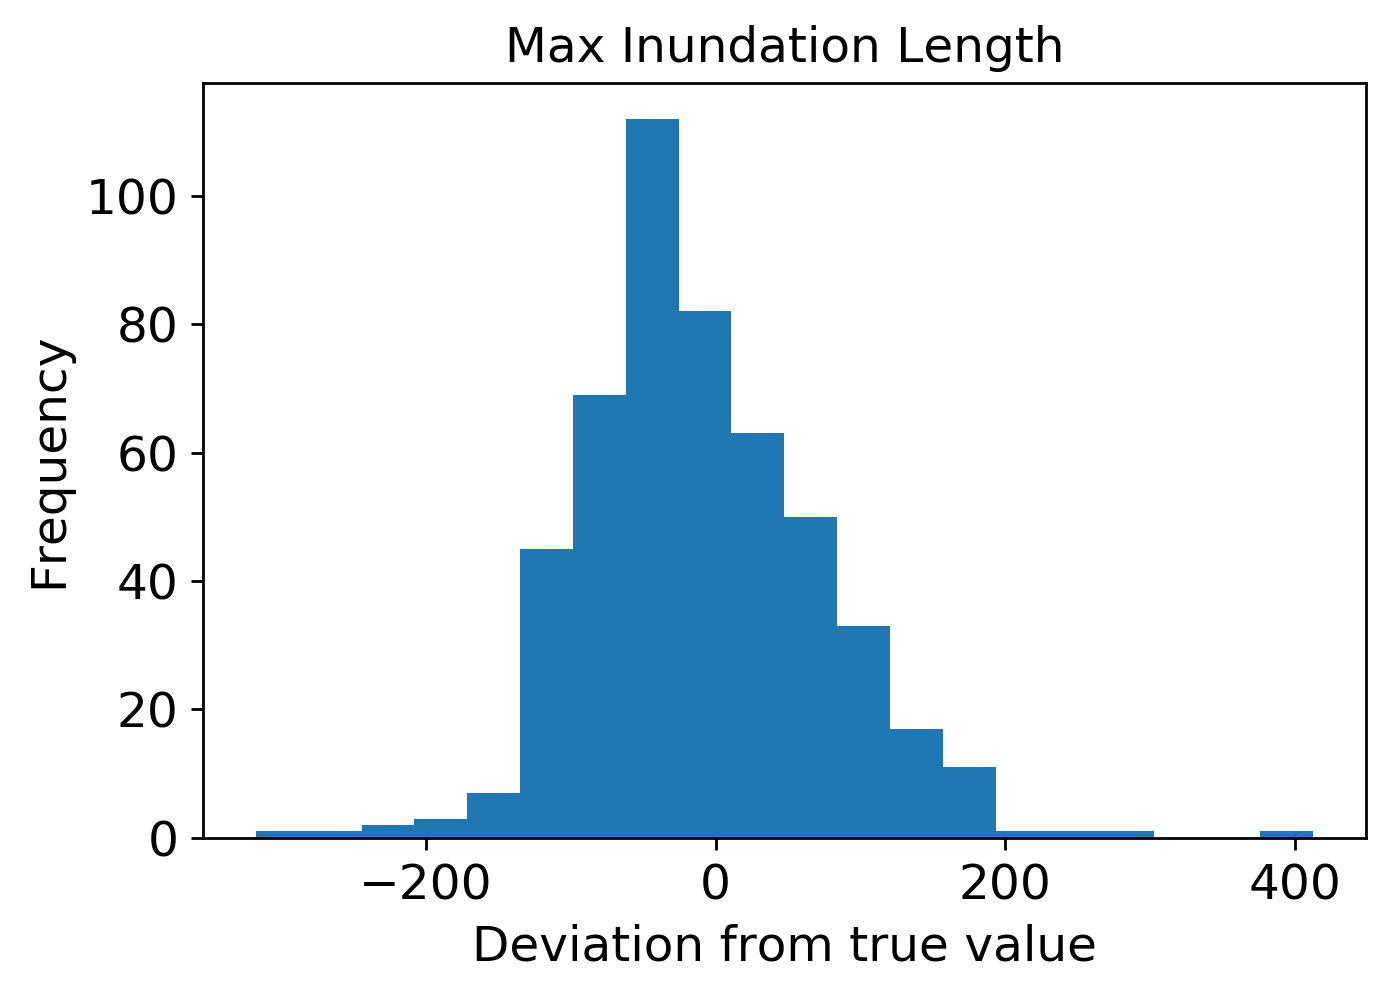

Standard Deviation: 0.2614137975212115
Standard Deviation sample: 0.2616756040941092
Mean: 0.12993439448542116
CV: 2.0139055954385476


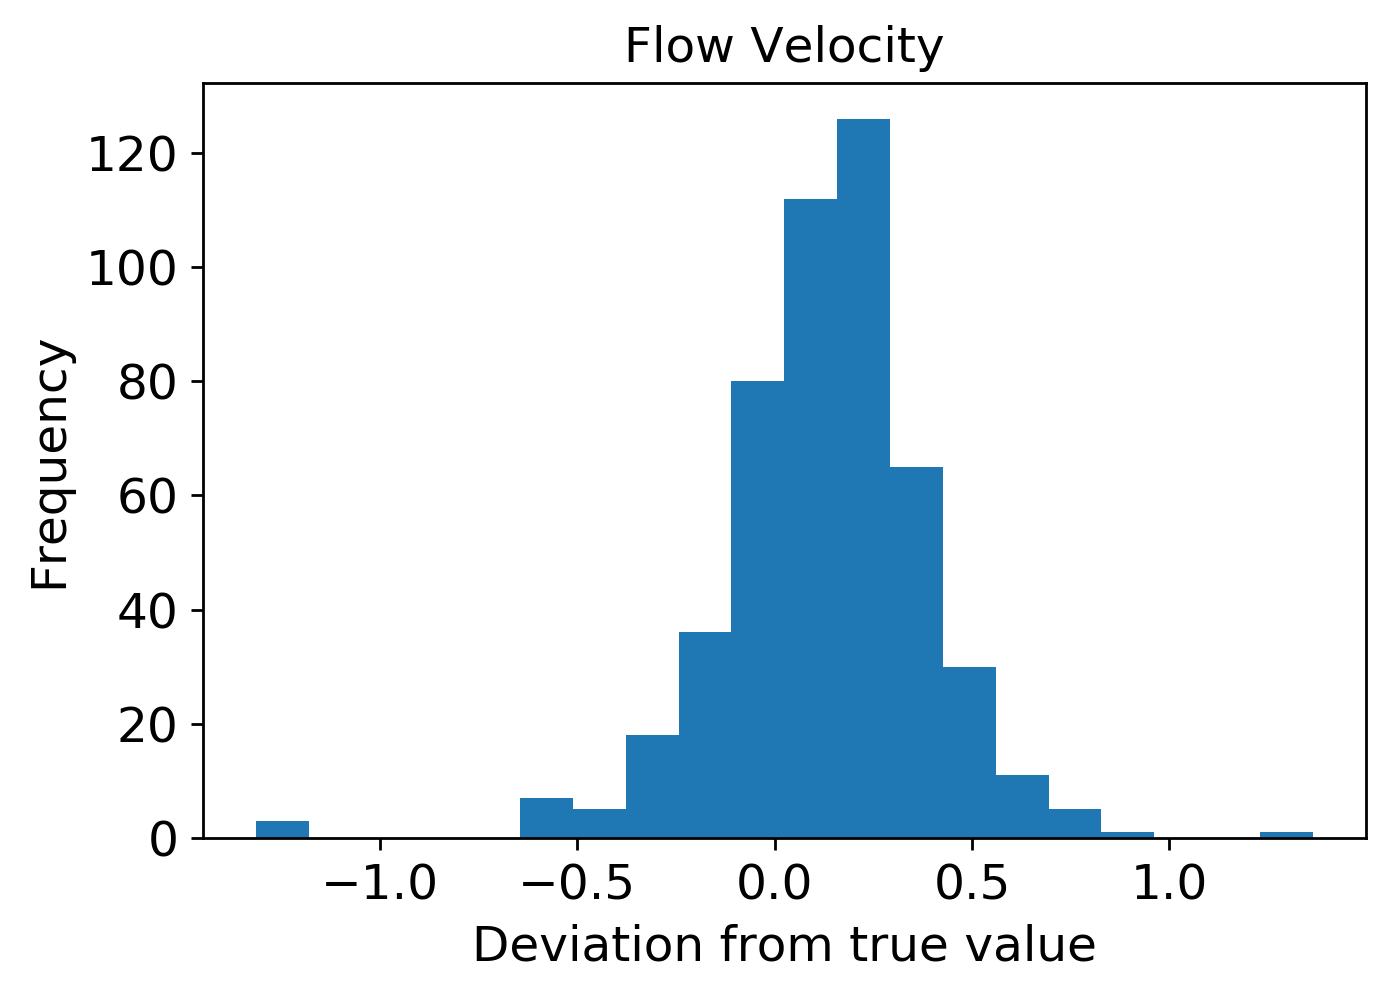

Standard Deviation: 0.3755168457671644
Standard Deviation sample: 0.3758929268286382
Mean: -0.4133057505029849
CV: -0.9094790633113232


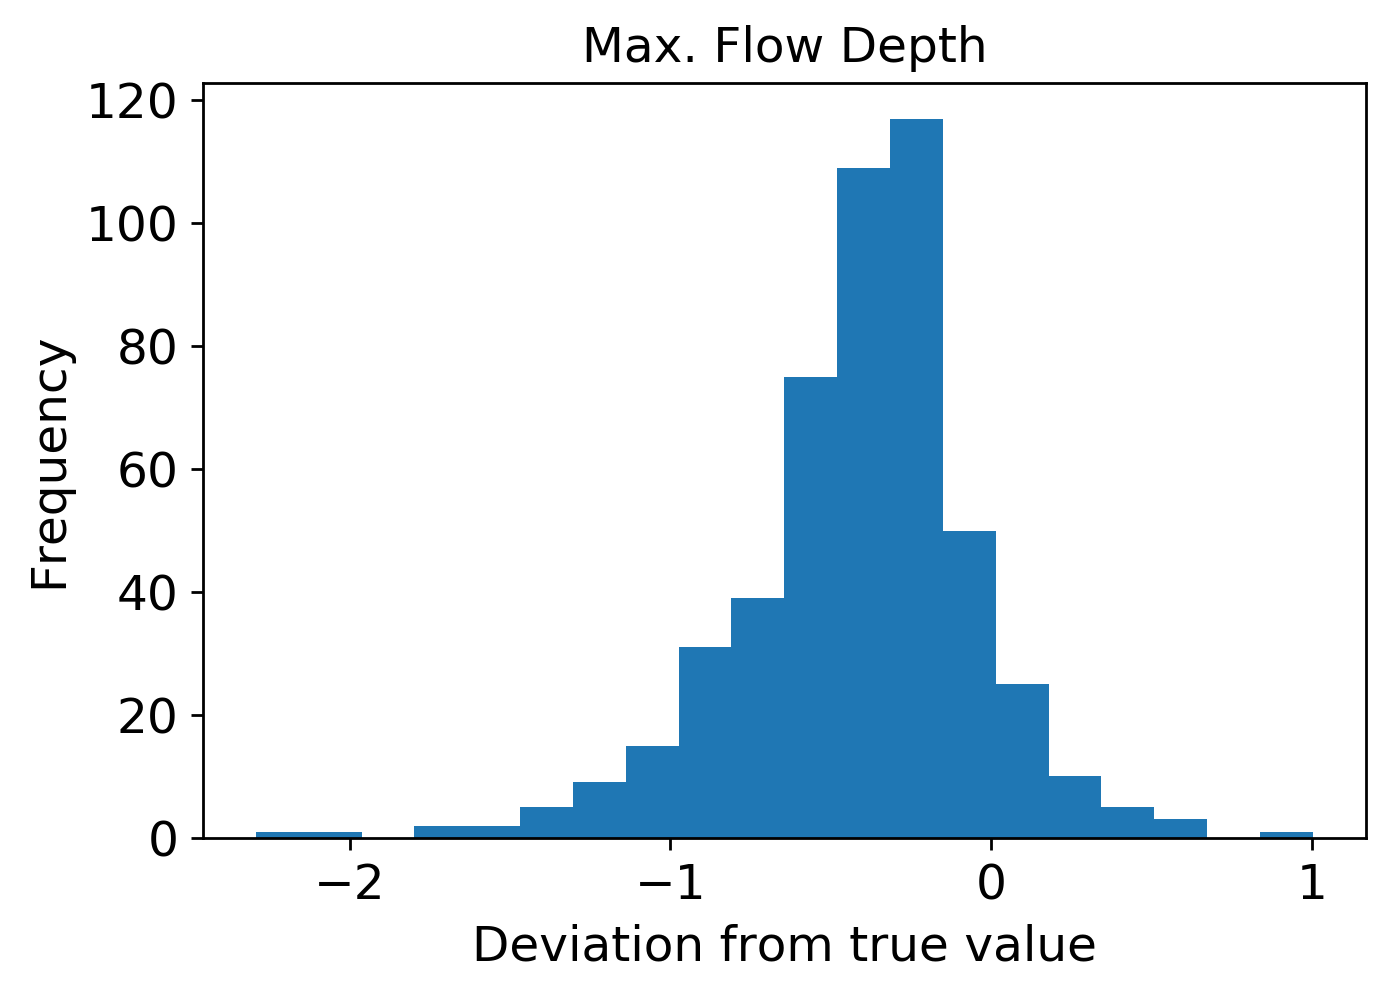

Standard Deviation: 0.0008067505379904883
Standard Deviation sample: 0.000807558500674698
Mean: 0.0002450427842548094
CV: 3.2955816394697535


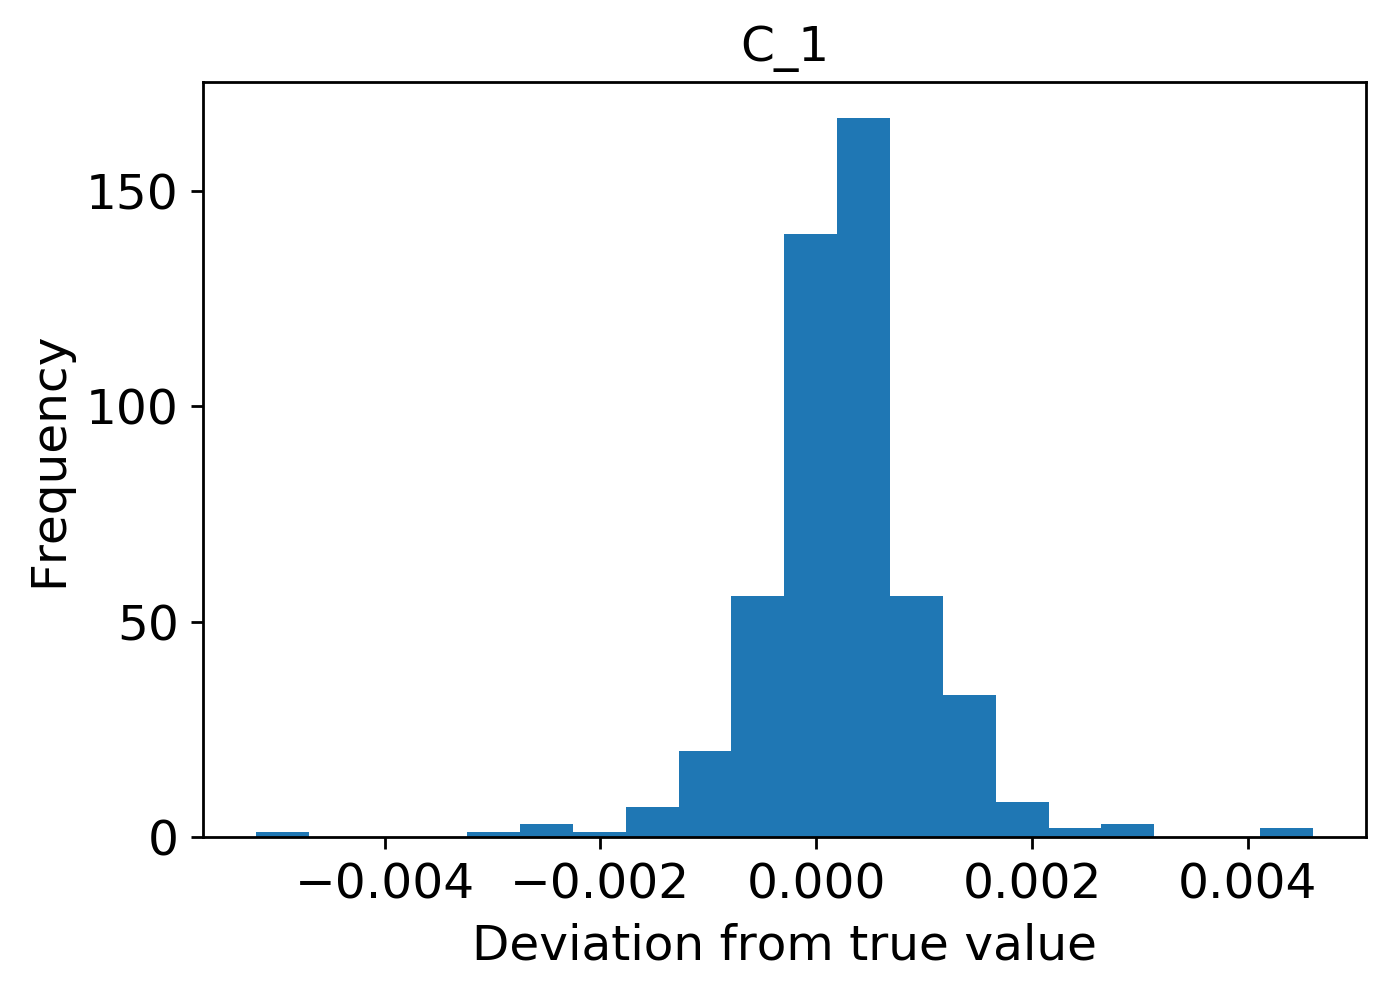

Standard Deviation: 0.0006737538560704977
Standard Deviation sample: 0.0006744286222446899
Mean: 0.0002121269683354951
CV: 3.179362942565743


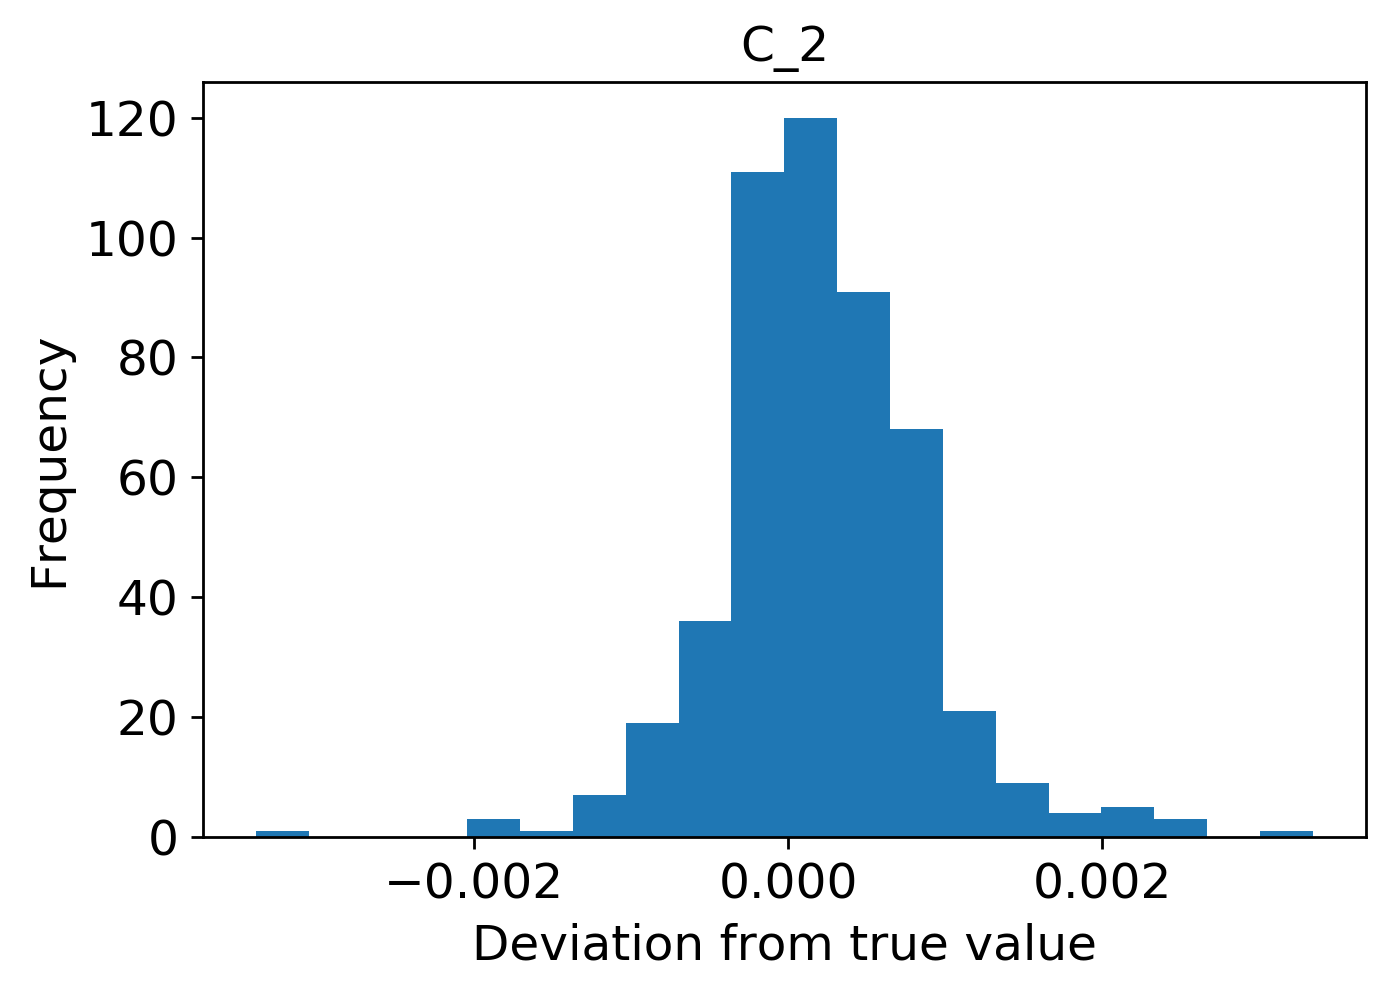

Standard Deviation: 0.000598913116451641
Standard Deviation sample: 0.000599512929437675
Mean: 8.337917135874874e-05
CV: 7.190200138331908


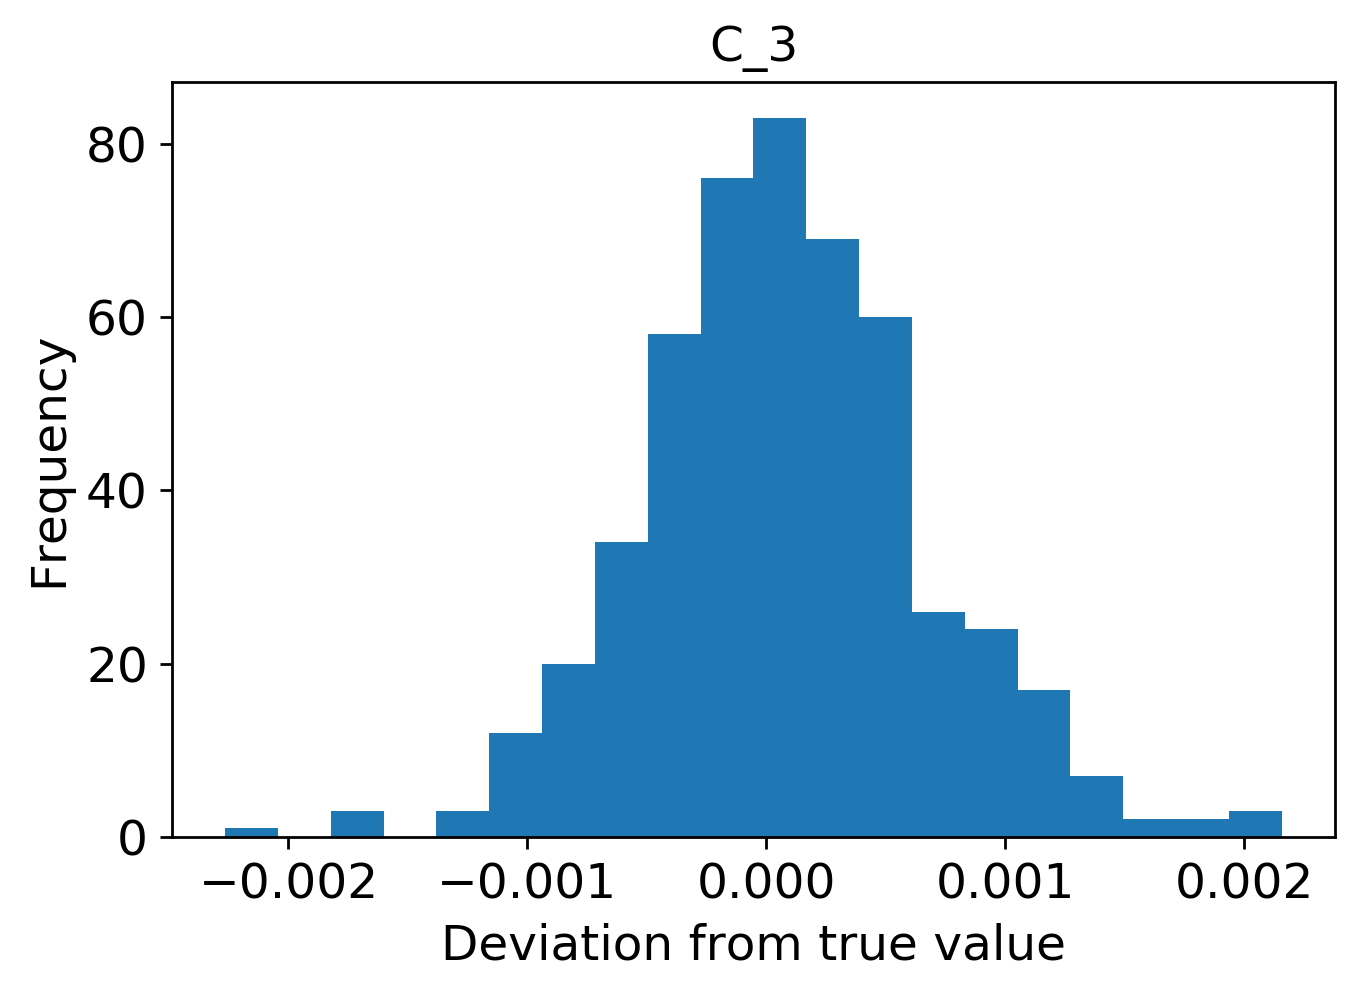

Standard Deviation: 0.0005895279569557929
Standard Deviation sample: 0.0005901183706810879
Mean: 1.6110040114796664e-05
CV: 36.630471834708786


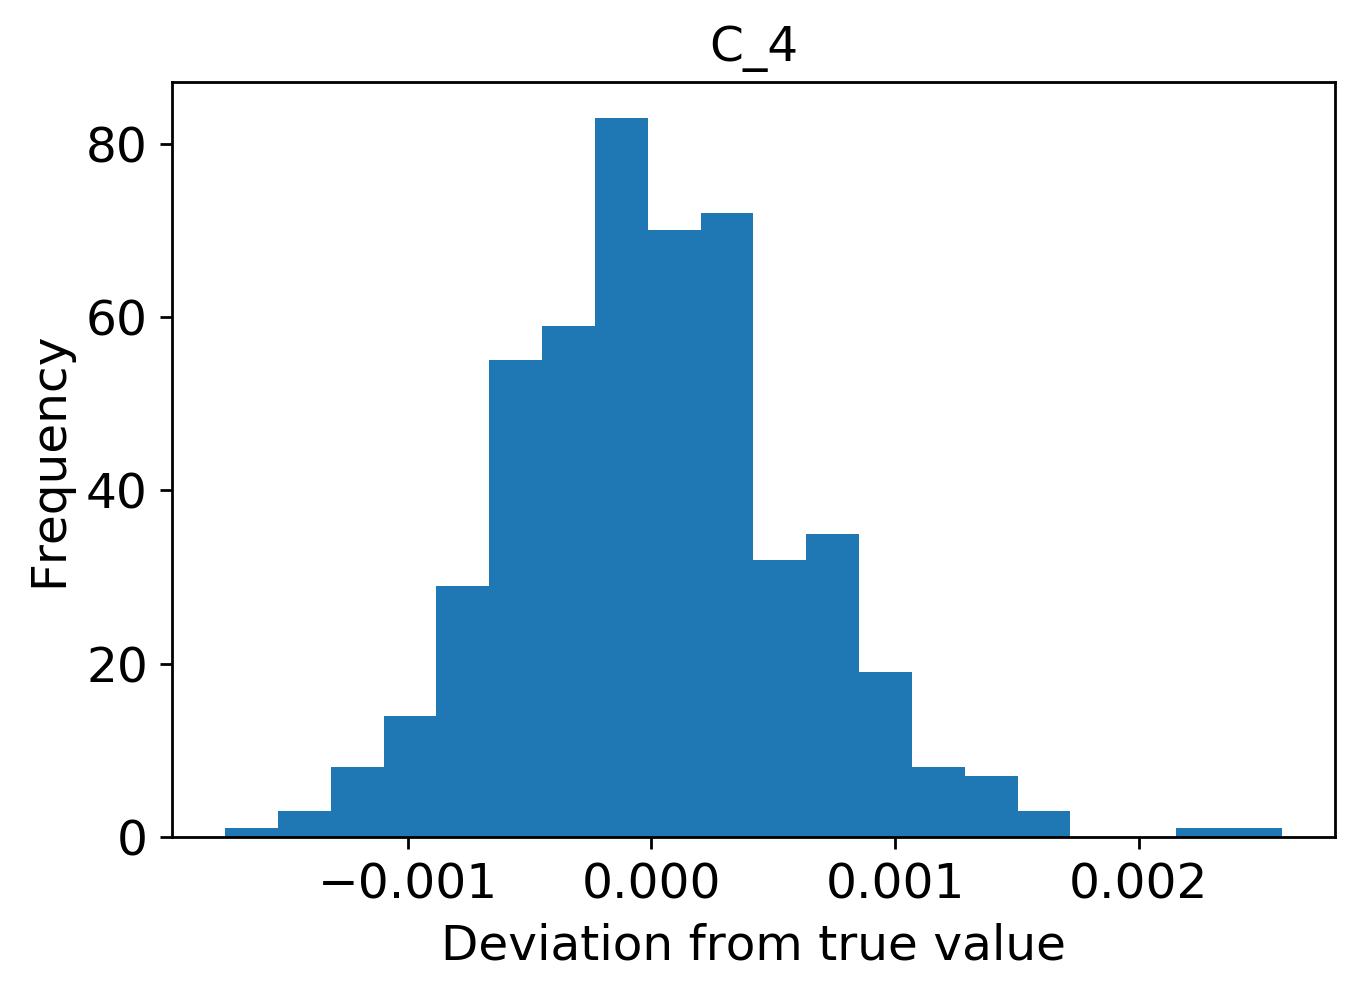

Standard Deviation: 0.0005905226930542997
Standard Deviation sample: 0.0005911141030102886
Mean: 0.0001163871913746016
CV: 5.07885873031973


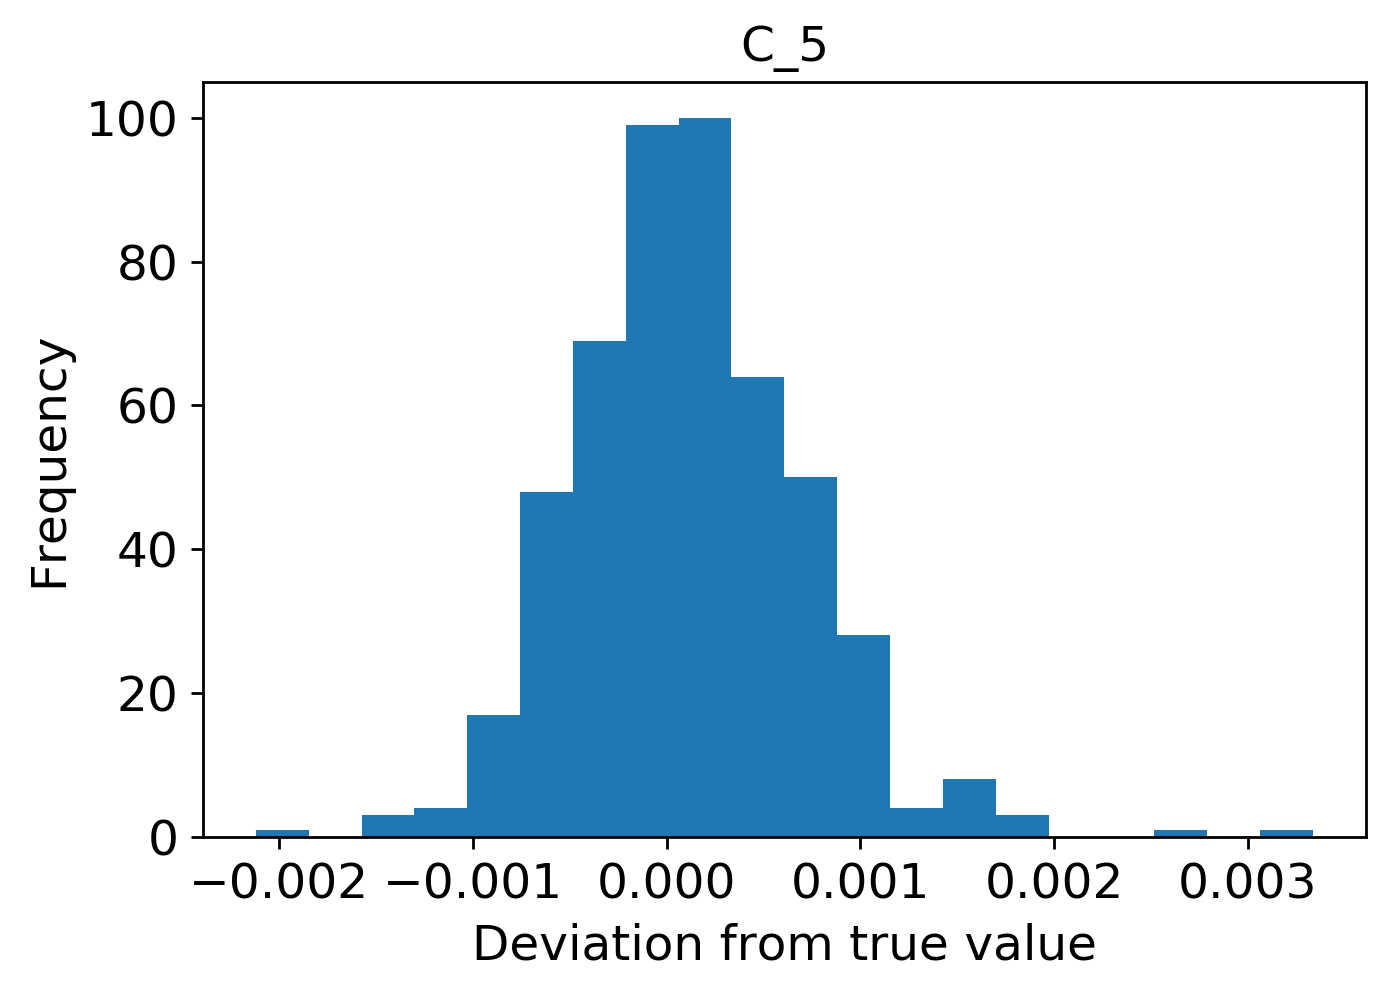

Standard Deviation: 0.0005683172446228952
Standard Deviation sample: 0.000568886415766669
Mean: -4.153824834729046e-05
CV: -13.69548400333009


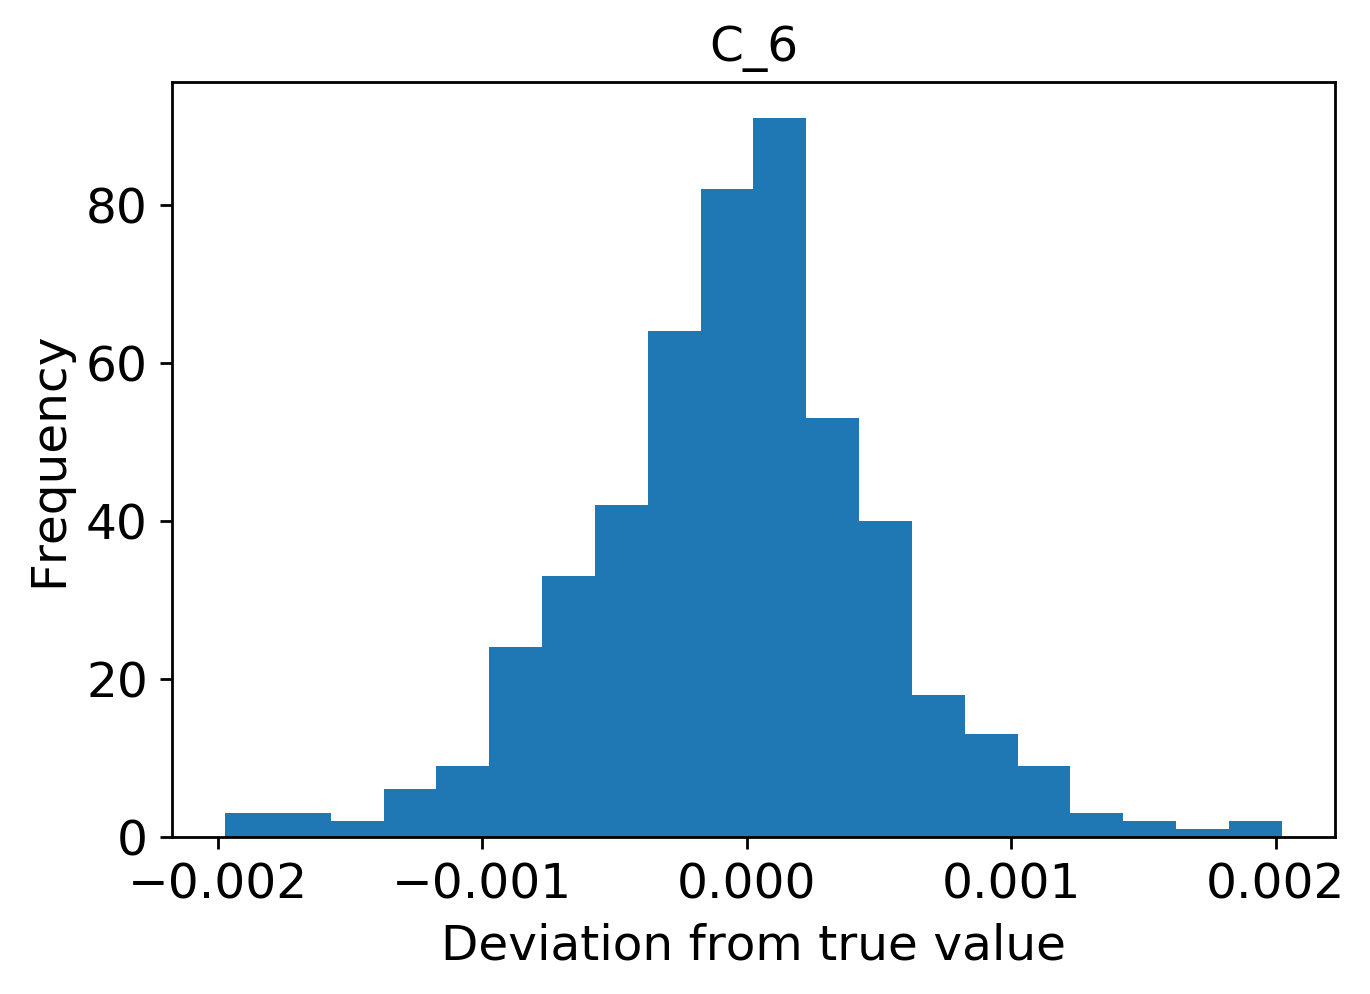

In [1]:
from scipy.stats import variation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

hfont = {'fontname':'Century Gothic'}
textcol = 'k'

datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1800_2_TC_odaka_2_round1/'
resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1800_2_TC_odaka_2_round1/5000/'

test_result = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
icond = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
print(icond.shape)
resi = test_result - icond
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', 'C_1', 'C_2', 'C_3', 'C_4','C_5','C_6']

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    print('Standard Deviation:', np.std(resi[:,i]))
    print('Standard Deviation sample:', np.std(resi[:,i],ddof=1))
    print('Mean:', np.mean(resi[:,i]))
    print('CV:', np.std(resi[:,i],ddof=1)/np.mean(resi[:,i]))                           
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.pdf')
    plt.show()

    distance       841       595       420       297       210       149
0          0  0.007906  0.015610  0.039802  0.062111  0.023617  0.004499
1         52  0.007303  0.012544  0.029795  0.060147  0.034320  0.007157
2        147  0.006591  0.010183  0.025940  0.055353  0.029294  0.004642
3        214  0.002612  0.009665  0.042366  0.105662  0.045116  0.005972
4        271  0.002332  0.006321  0.030175  0.107966  0.063558  0.007262
5        364  0.003398  0.007496  0.029200  0.070910  0.025199  0.001880
6        487  0.000495  0.002003  0.010195  0.041490  0.022317  0.002599
7        583  0.000448  0.000929  0.001784  0.008833  0.018146  0.007056
8        690  0.000086  0.000100  0.000912  0.008526  0.008212  0.001553
9        756  0.001027  0.001242  0.001588  0.011941  0.013520  0.006497
10       863  0.002118  0.003245  0.007448  0.028683  0.029339  0.012089
11       944  0.003506  0.006849  0.012450  0.029527  0.030557  0.011203
12      1040  0.000615  0.001772  0.004087  0.01772

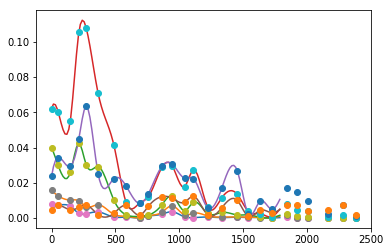

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb


datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1800_2_TC_odaka_2_round1/'
resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1800_2_TC_odaka_2_round1/5000/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')

gclass = 6
gclass_name=['841','595','420','297','210','149']
gclass_label = ["841 ${\mu}m$","595 ${\mu}m$","420 ${\mu}m$","297 ${\mu}m$", "210 ${\mu}m$","149 ${\mu}m$"]
topodx = 15.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

#Read outcrop data

outcrop = pd.read_csv('../Journal_2/odaka_increased_class_edit3.csv')

outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0

print(outcrop)

#Preparation under interpolation
thick_interp = np.zeros([1,coord_num*gclass])#補間されたサンプル厚さデータ
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #逆解析システムでのサンプリング地点のindex番号
x = np.arange(0,coord_num*topodx,topodx)

#Complement data
for j in range(gclass):
    f = interp1d(outcrop['distance'],outcrop.iloc[:,j+1], kind="cubic",bounds_error=False,fill_value='extrapolate')
    thick_interp[0,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data


#Normalize data
thick_interp[thick_interp < 0] = 0
thick_interp_norm =  (thick_interp - min_x) / (max_x - min_x)

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp_norm)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
#add=np.array(3000)
#test_result_outcrop_add=np.concatenate((add,test_result_outcrop), axis=None)
#Output results
#print(test_result_outcrop_add)
np.savetxt('outcrop_result_g6_g300_j2_roi1800_2_TC_cubic_odaka_round1rev.txt',test_result_outcrop, delimiter=',')
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)],label=gclass_label[i])
for i in range(gclass):
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
#plt.legend()
plt.show()

    distance       841       595       420       297       210       149
0          0  0.007906  0.015610  0.039802  0.062111  0.023617  0.004499
1         52  0.007303  0.012544  0.029795  0.060147  0.034320  0.007157
2        147  0.006591  0.010183  0.025940  0.055353  0.029294  0.004642
3        214  0.002612  0.009665  0.042366  0.105662  0.045116  0.005972
4        271  0.002332  0.006321  0.030175  0.107966  0.063558  0.007262
5        364  0.003398  0.007496  0.029200  0.070910  0.025199  0.001880
6        487  0.000495  0.002003  0.010195  0.041490  0.022317  0.002599
7        583  0.000448  0.000929  0.001784  0.008833  0.018146  0.007056
8        690  0.000086  0.000100  0.000912  0.008526  0.008212  0.001553
9        756  0.001027  0.001242  0.001588  0.011941  0.013520  0.006497
10       863  0.002118  0.003245  0.007448  0.028683  0.029339  0.012089
11       944  0.003506  0.006849  0.012450  0.029527  0.030557  0.011203
12      1040  0.000615  0.001772  0.004087  0.01772

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


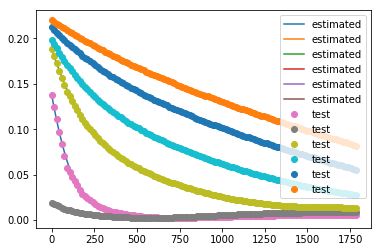

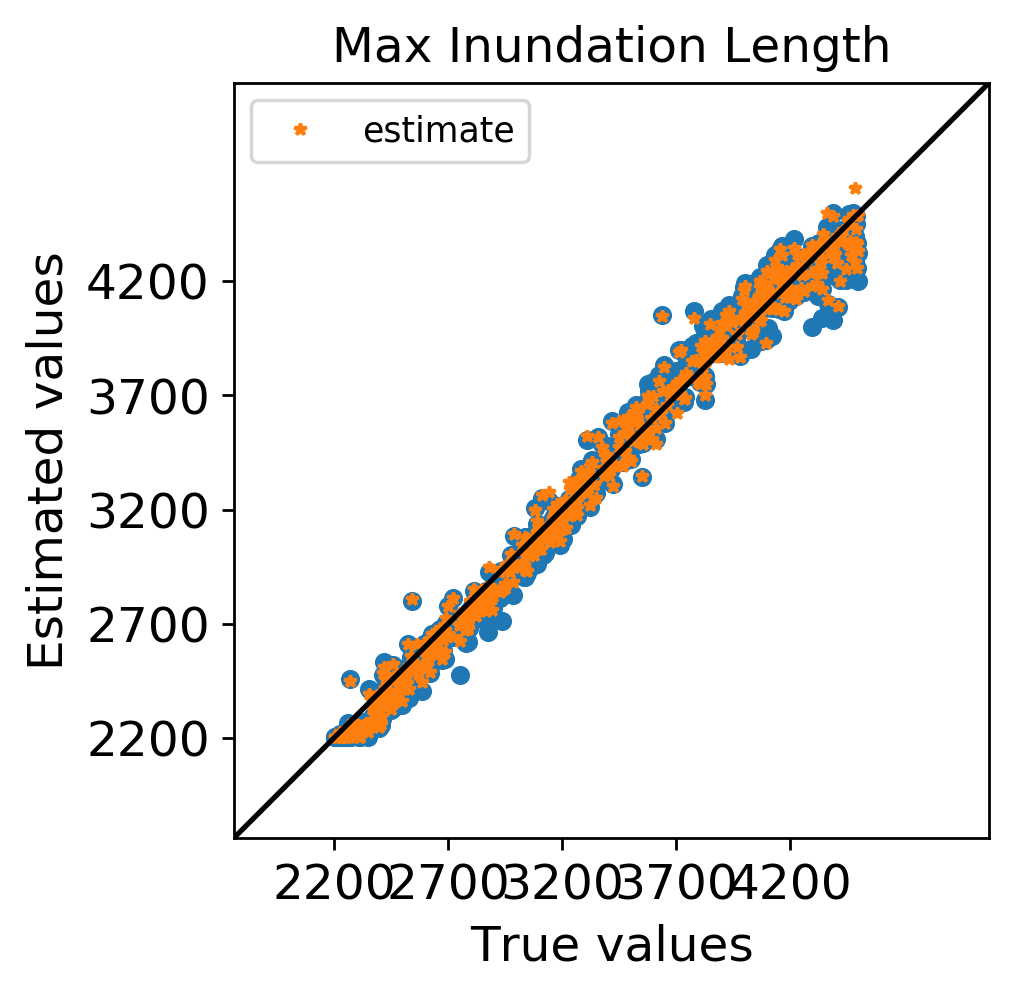

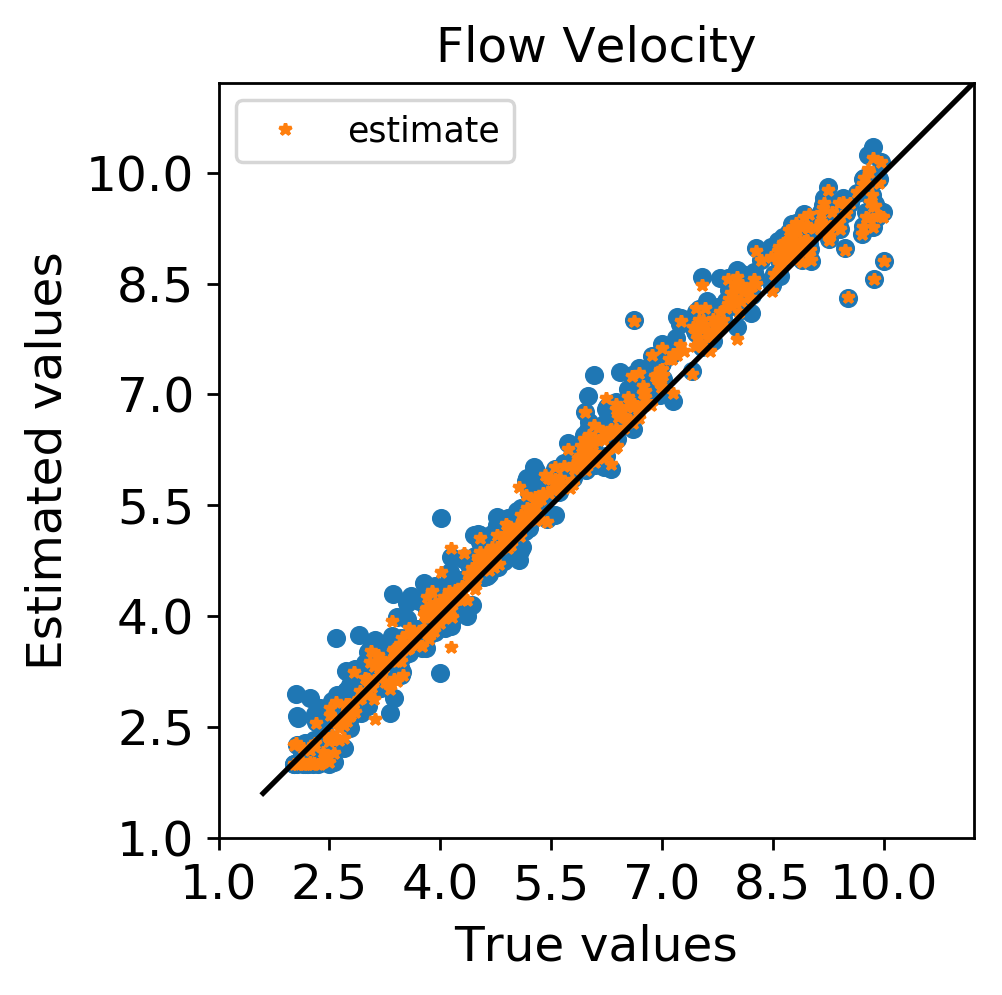

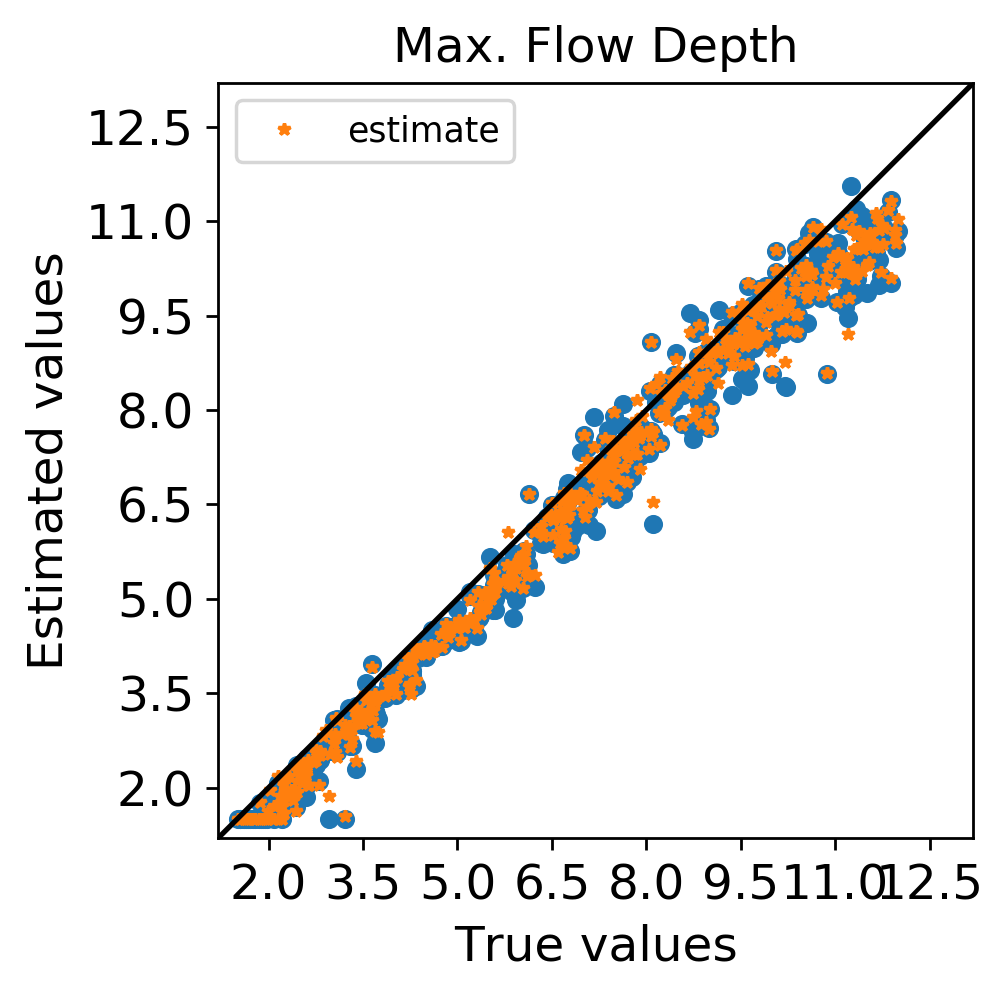

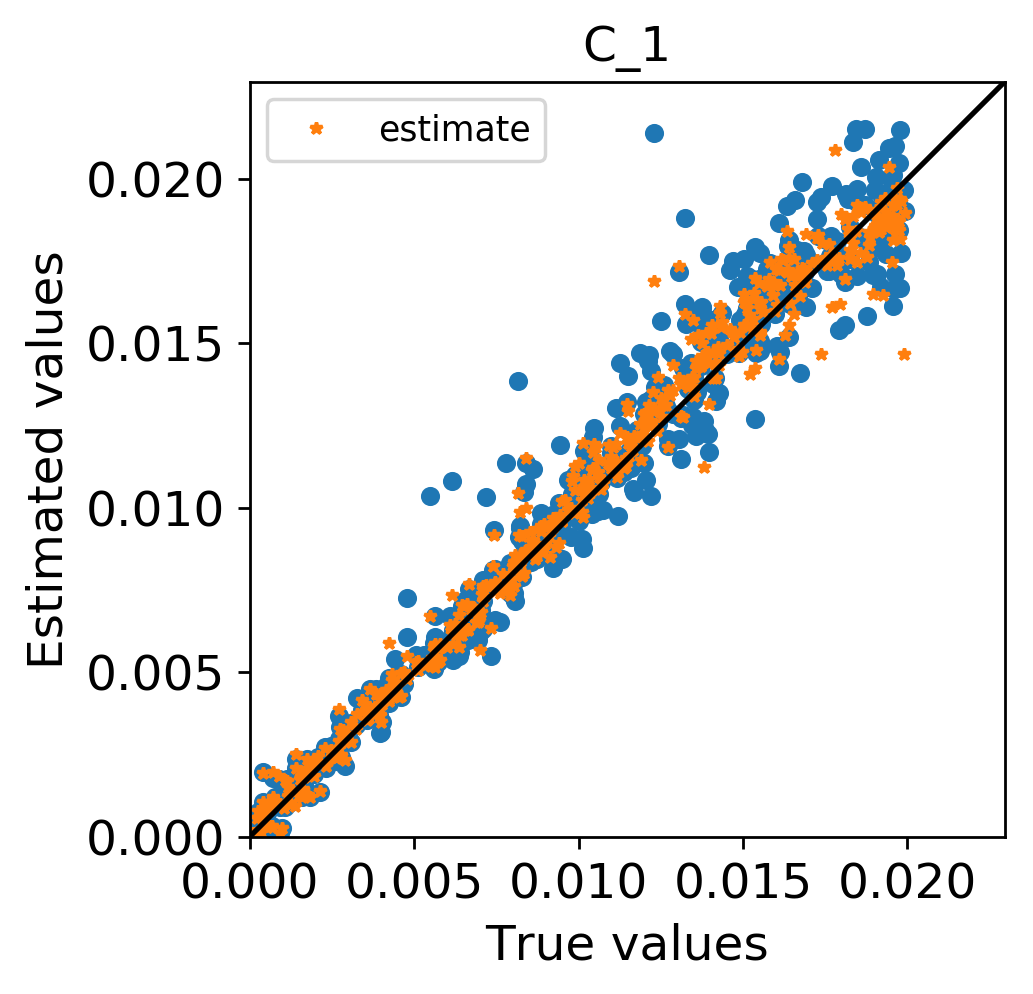

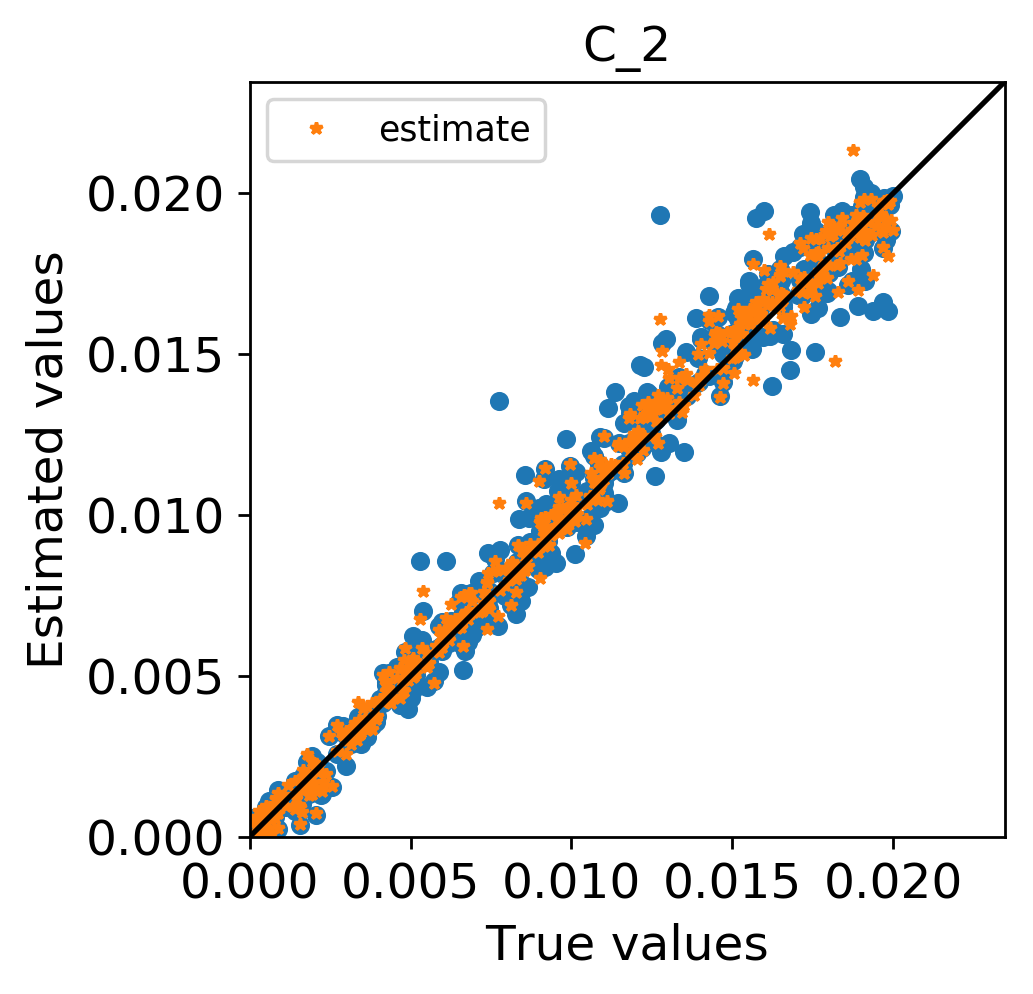

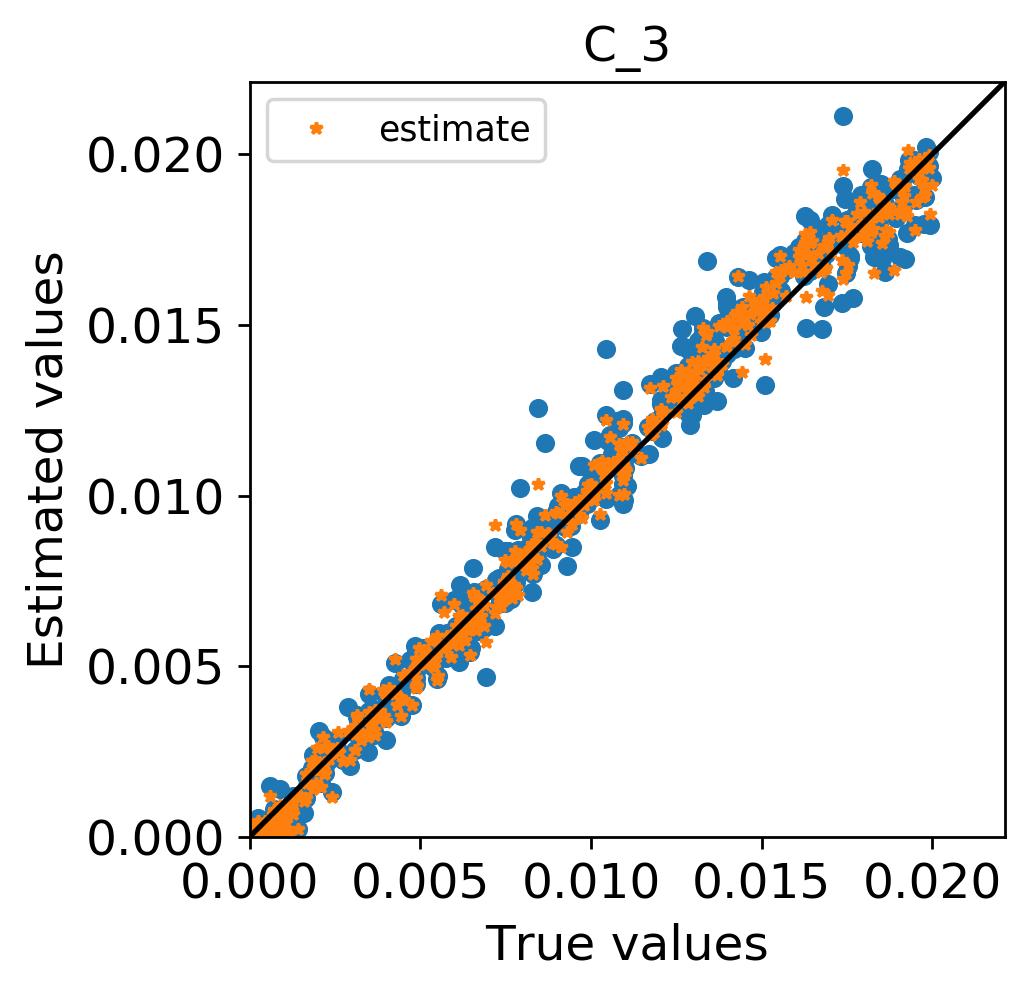

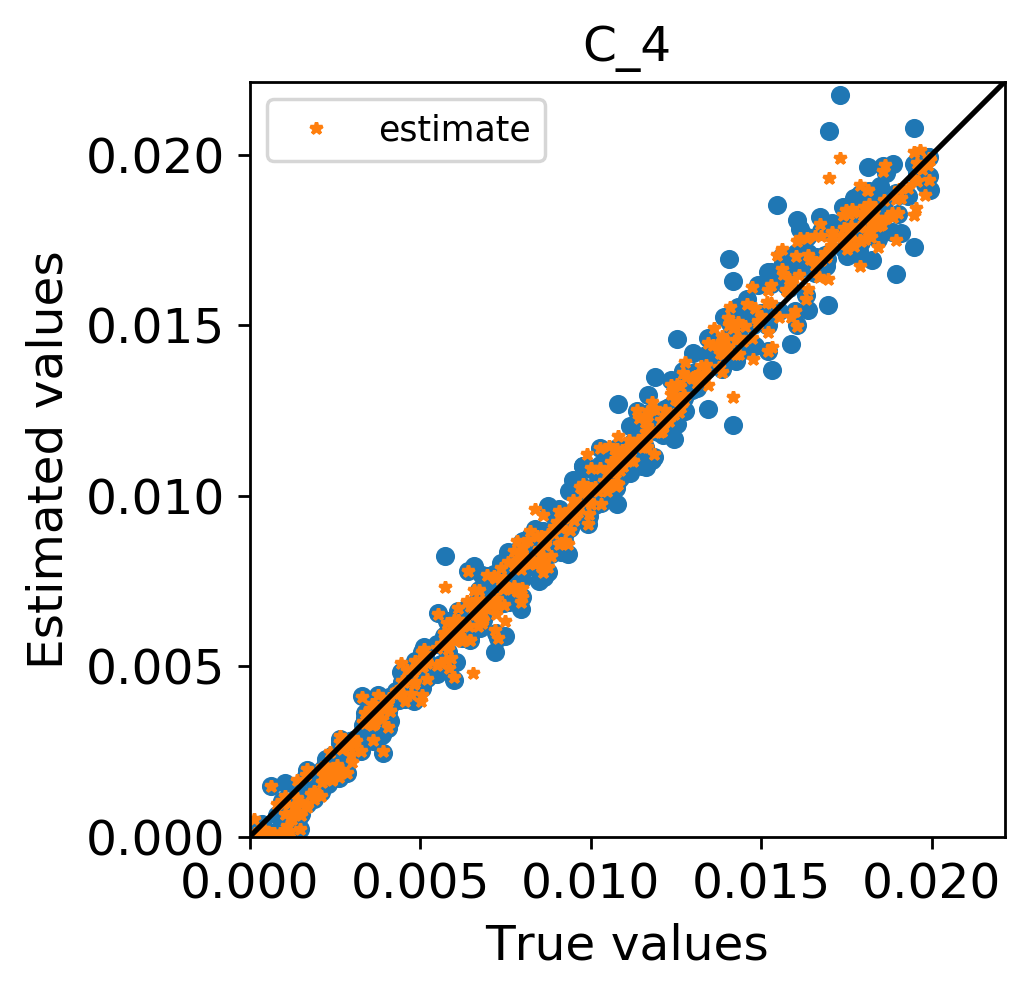

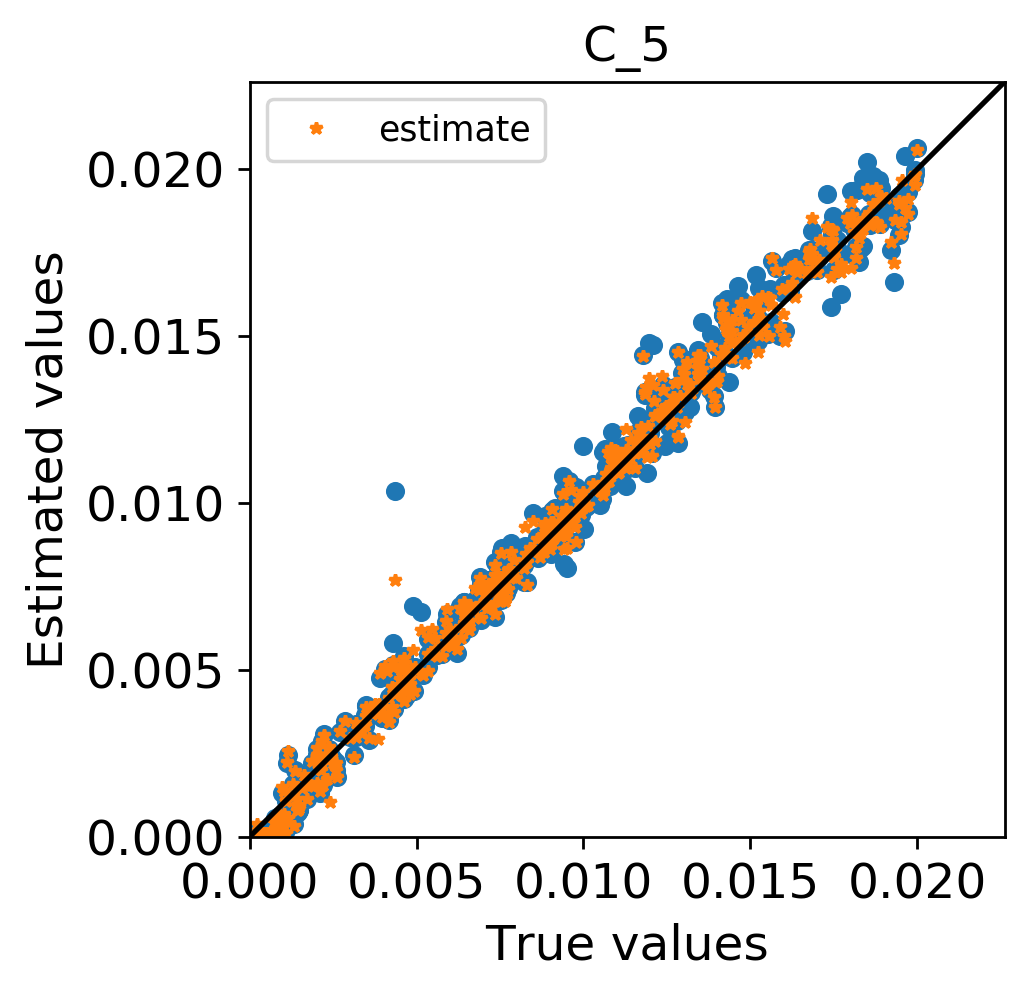

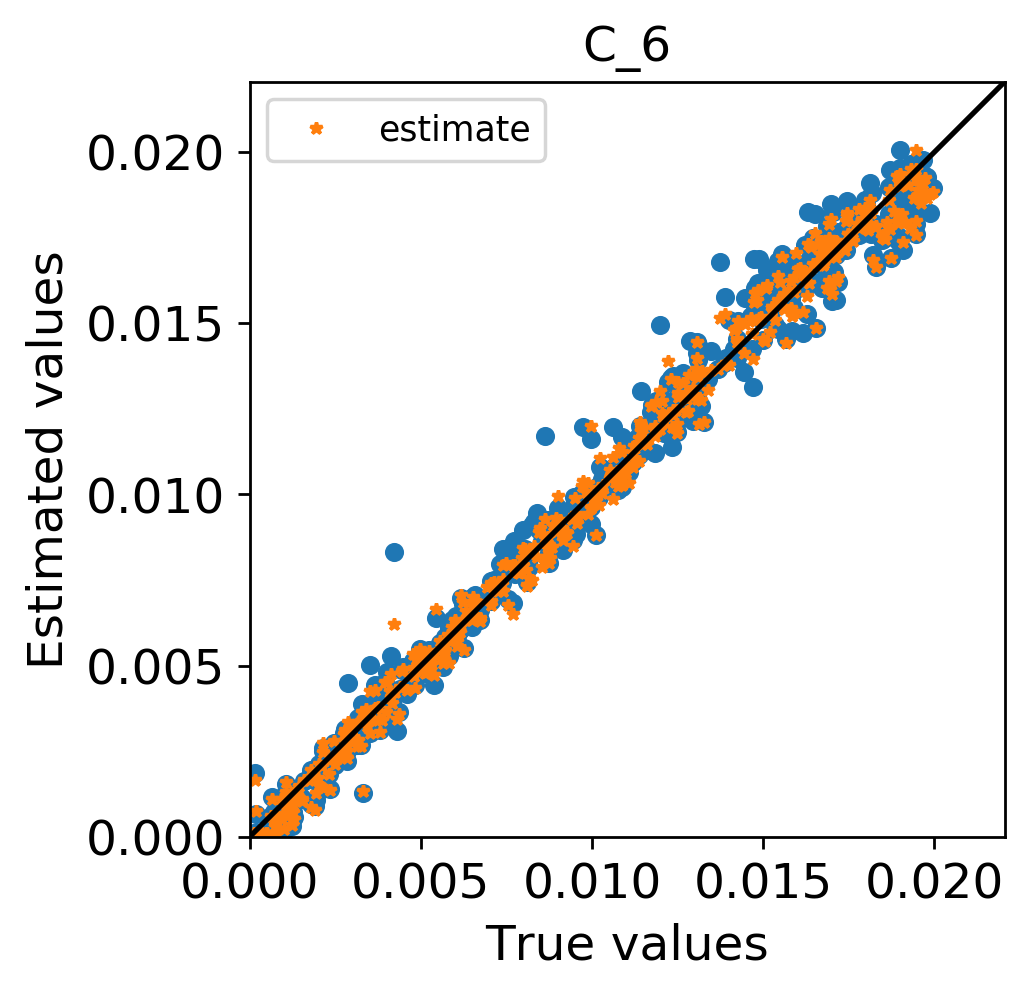

Standard Deviation sample: 98.86309995055406
Mean: -16.878556203899937
mode ModeResult(mode=array([-355.28286533]), count=array([1]))
m -26.720715860334394


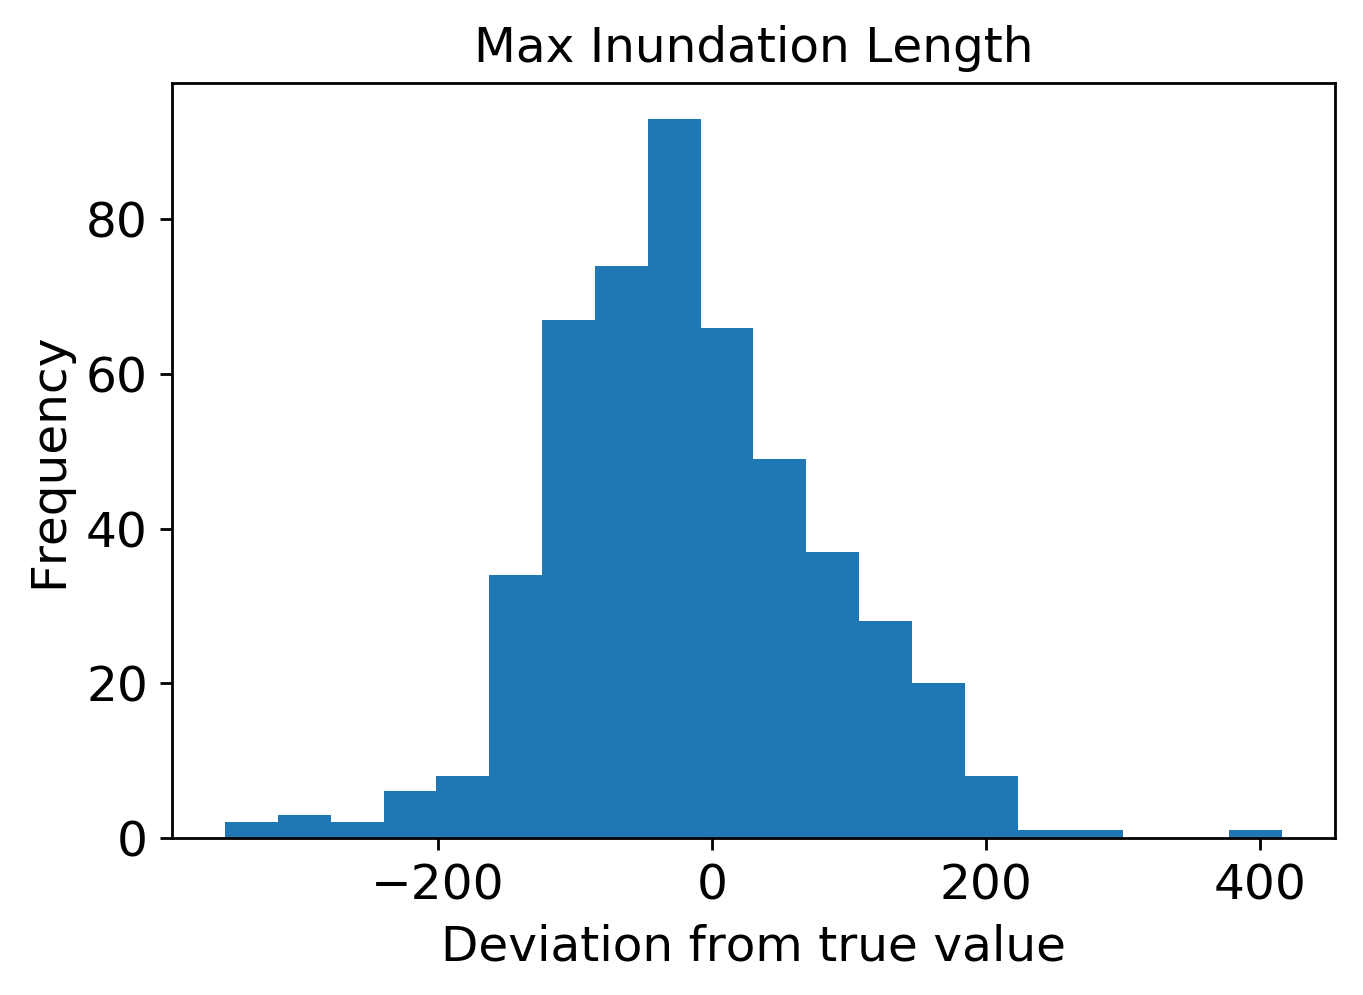

Standard Deviation sample: 0.322425433048274
Mean: 0.20464026404528074
mode ModeResult(mode=array([-1.31497858]), count=array([1]))
m 0.22318387371083848


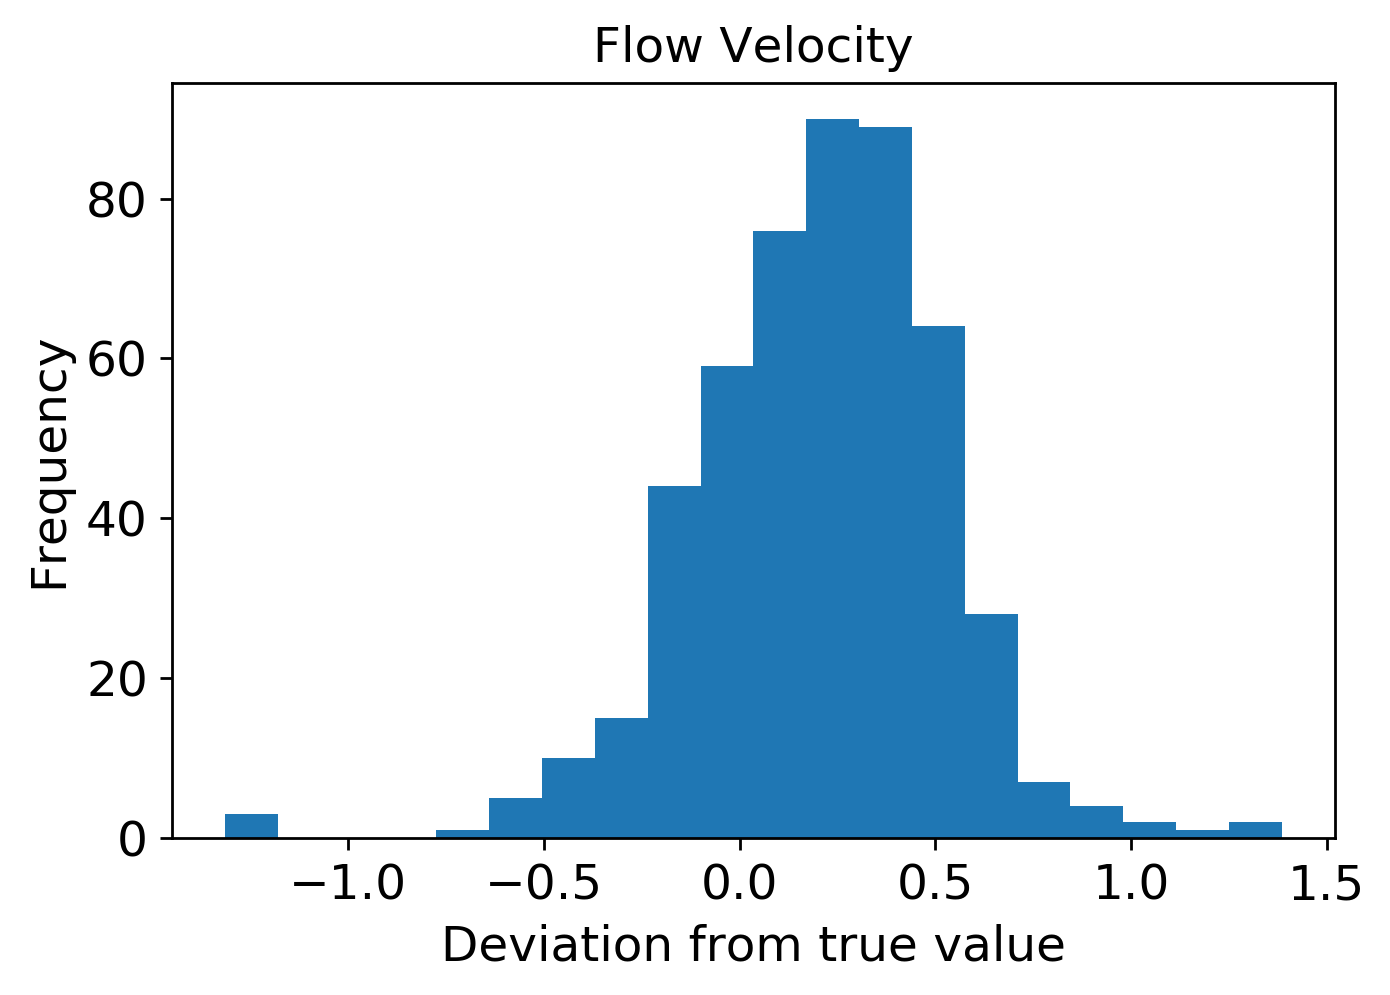

Standard Deviation sample: 0.4235149081273239
Mean: -0.46195372033434
mode ModeResult(mode=array([-2.31039618]), count=array([1]))
m -0.42135862702537485


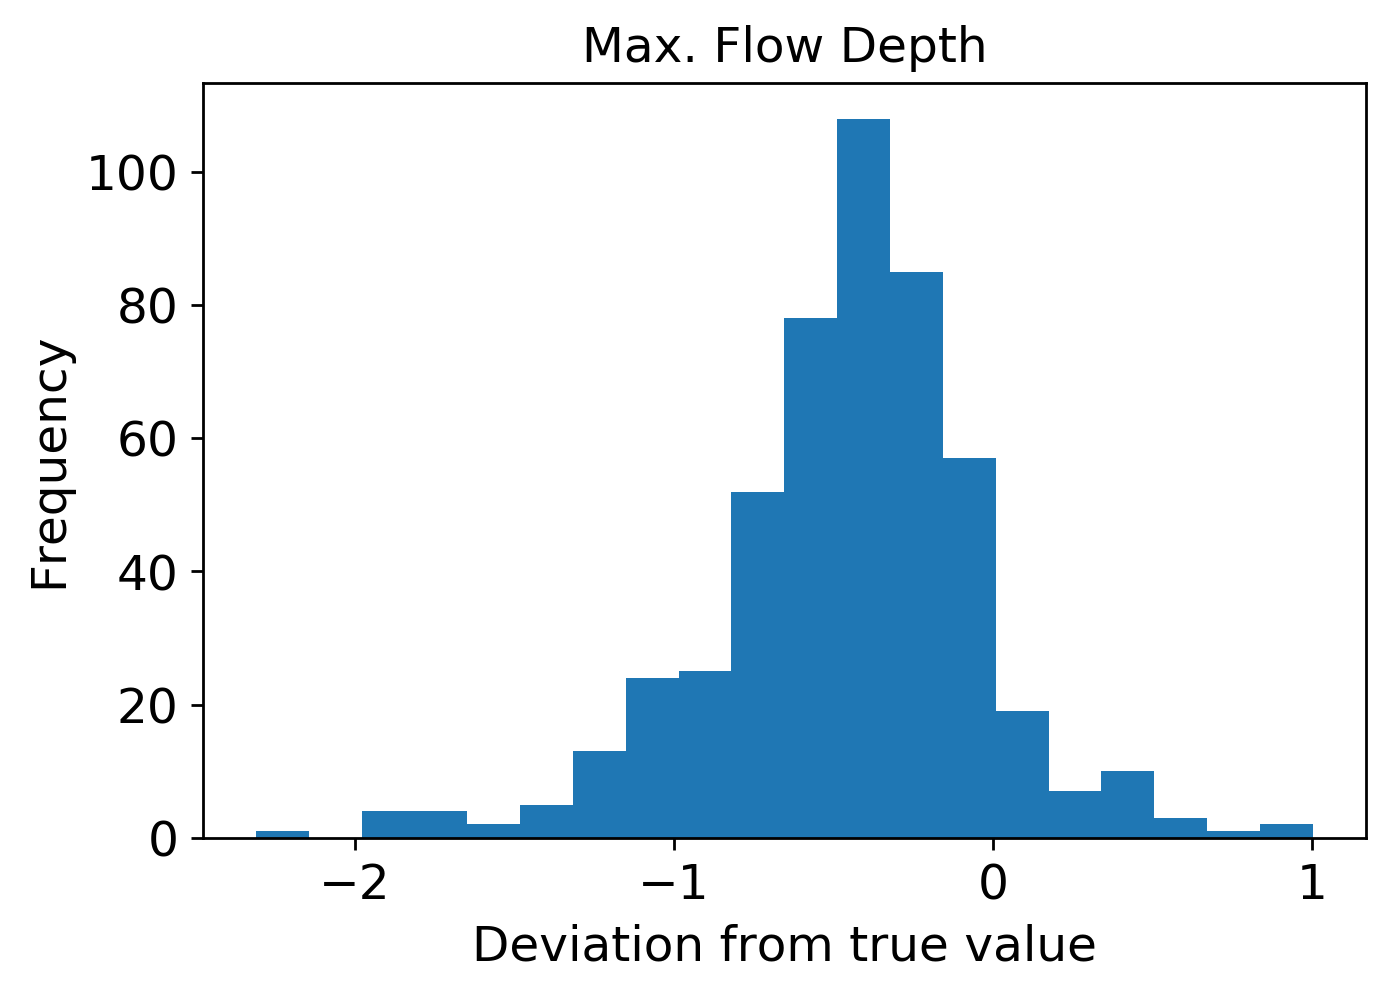

Standard Deviation sample: 0.0012830165014251027
Mean: 0.0003591655412440754
mode ModeResult(mode=array([-0.00342643]), count=array([1]))
m 0.0002069223180966237


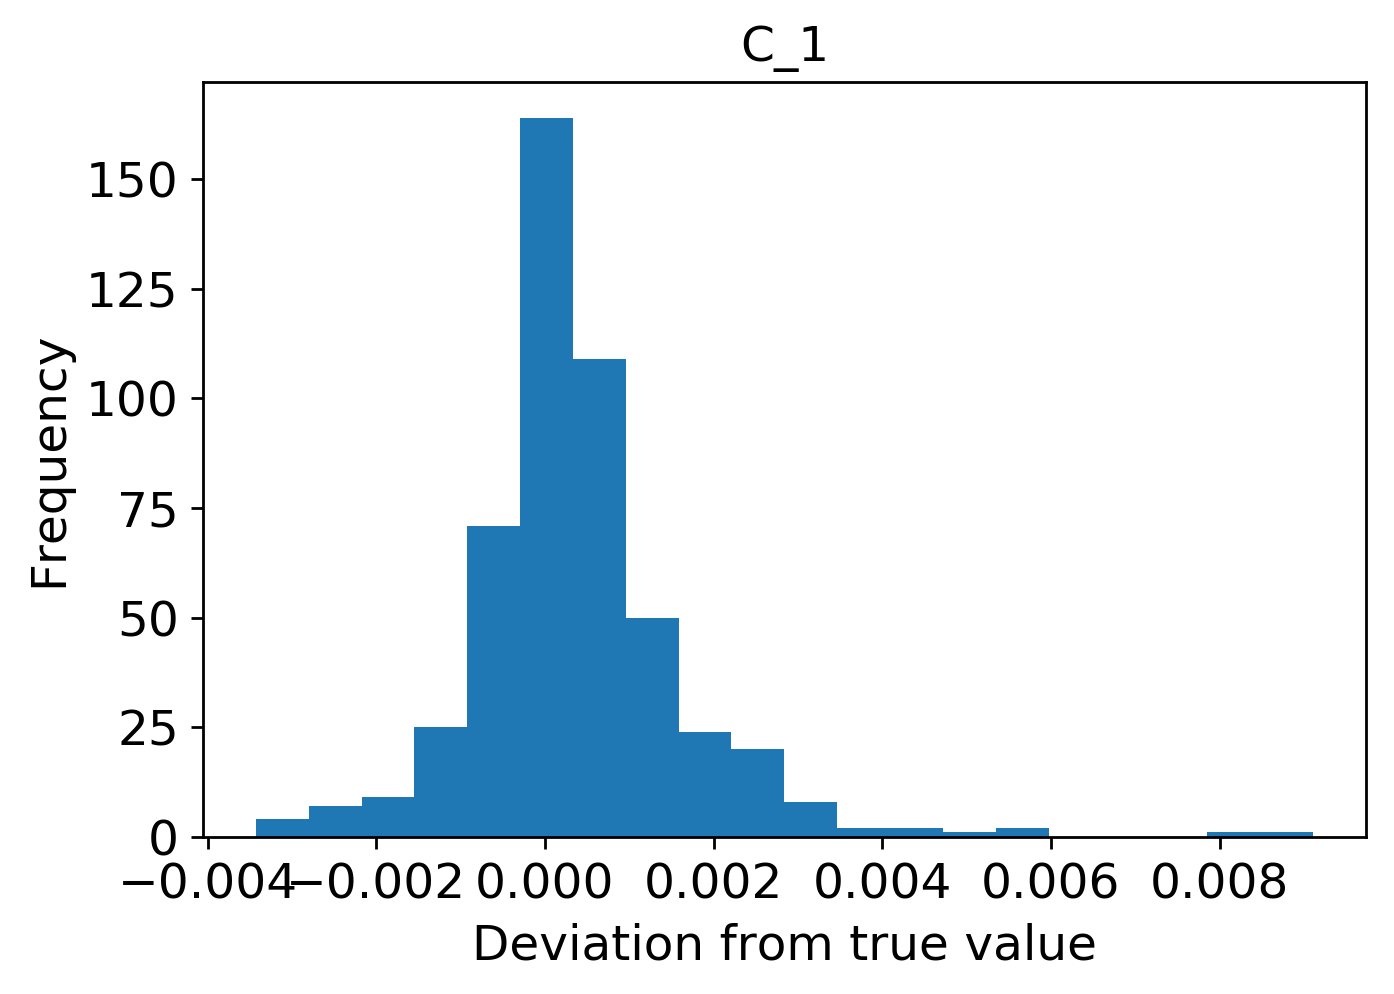

Standard Deviation sample: 0.0009974065248902144
Mean: 0.00024643890337781204
mode ModeResult(mode=array([-0.00349955]), count=array([1]))
m 0.00017034895566188845


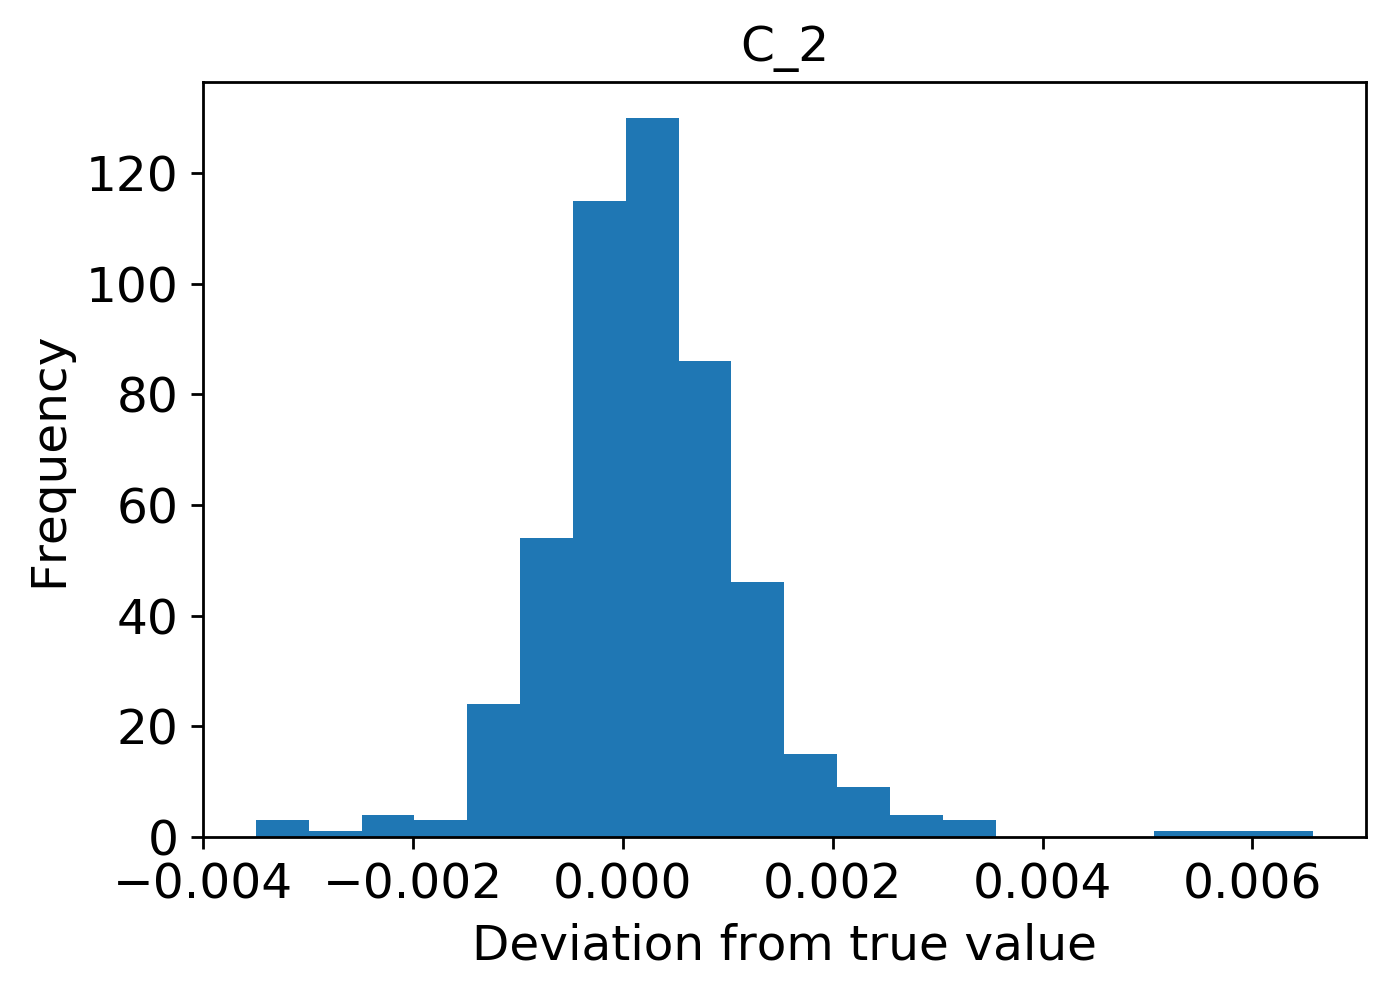

Standard Deviation sample: 0.0008335999055450047
Mean: 0.00013681872846743
mode ModeResult(mode=array([-0.00228921]), count=array([1]))
m 9.145718576756851e-05


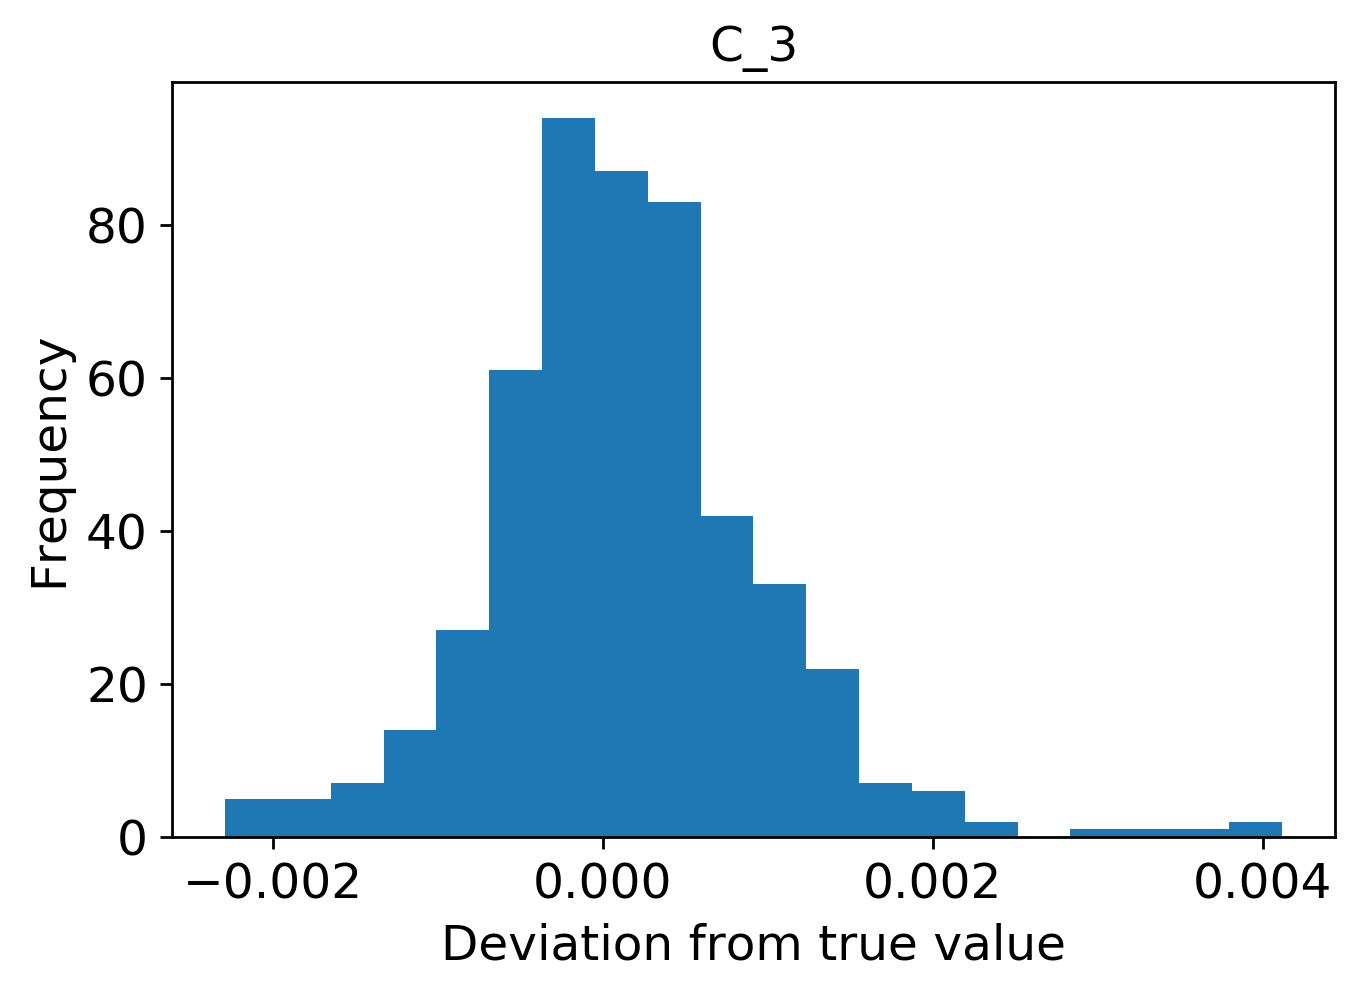

Standard Deviation sample: 0.0007368082293390982
Mean: 3.246434516237008e-05
mode ModeResult(mode=array([-0.00246421]), count=array([1]))
m -1.9462673014315323e-05


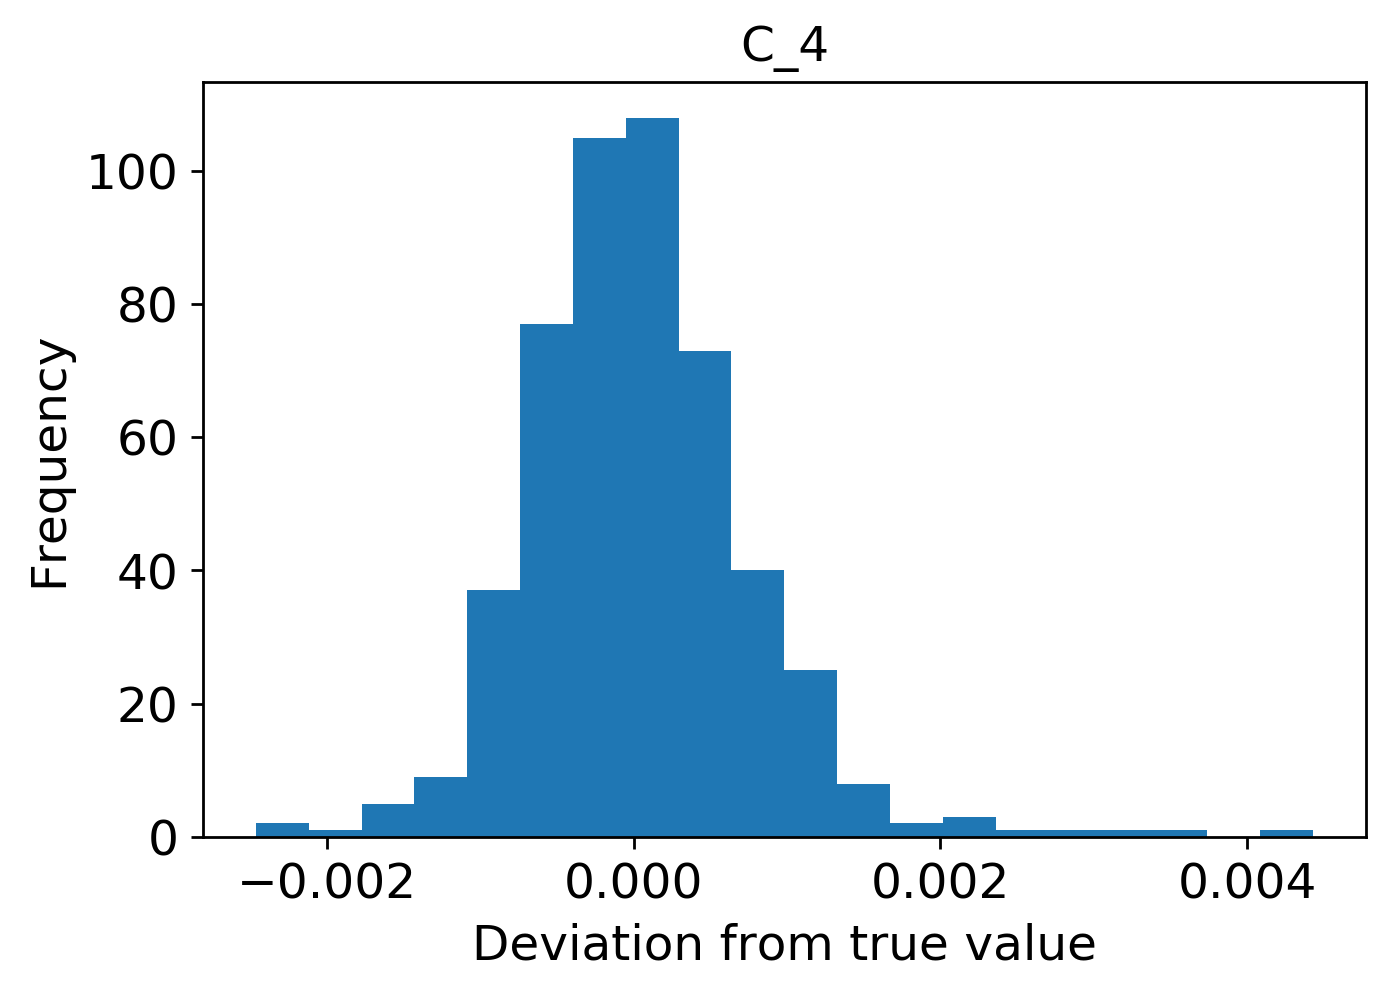

Standard Deviation sample: 0.0007124506991161723
Mean: 0.00018558283077663686
mode ModeResult(mode=array([-0.00268269]), count=array([1]))
m 0.00012821086264236566


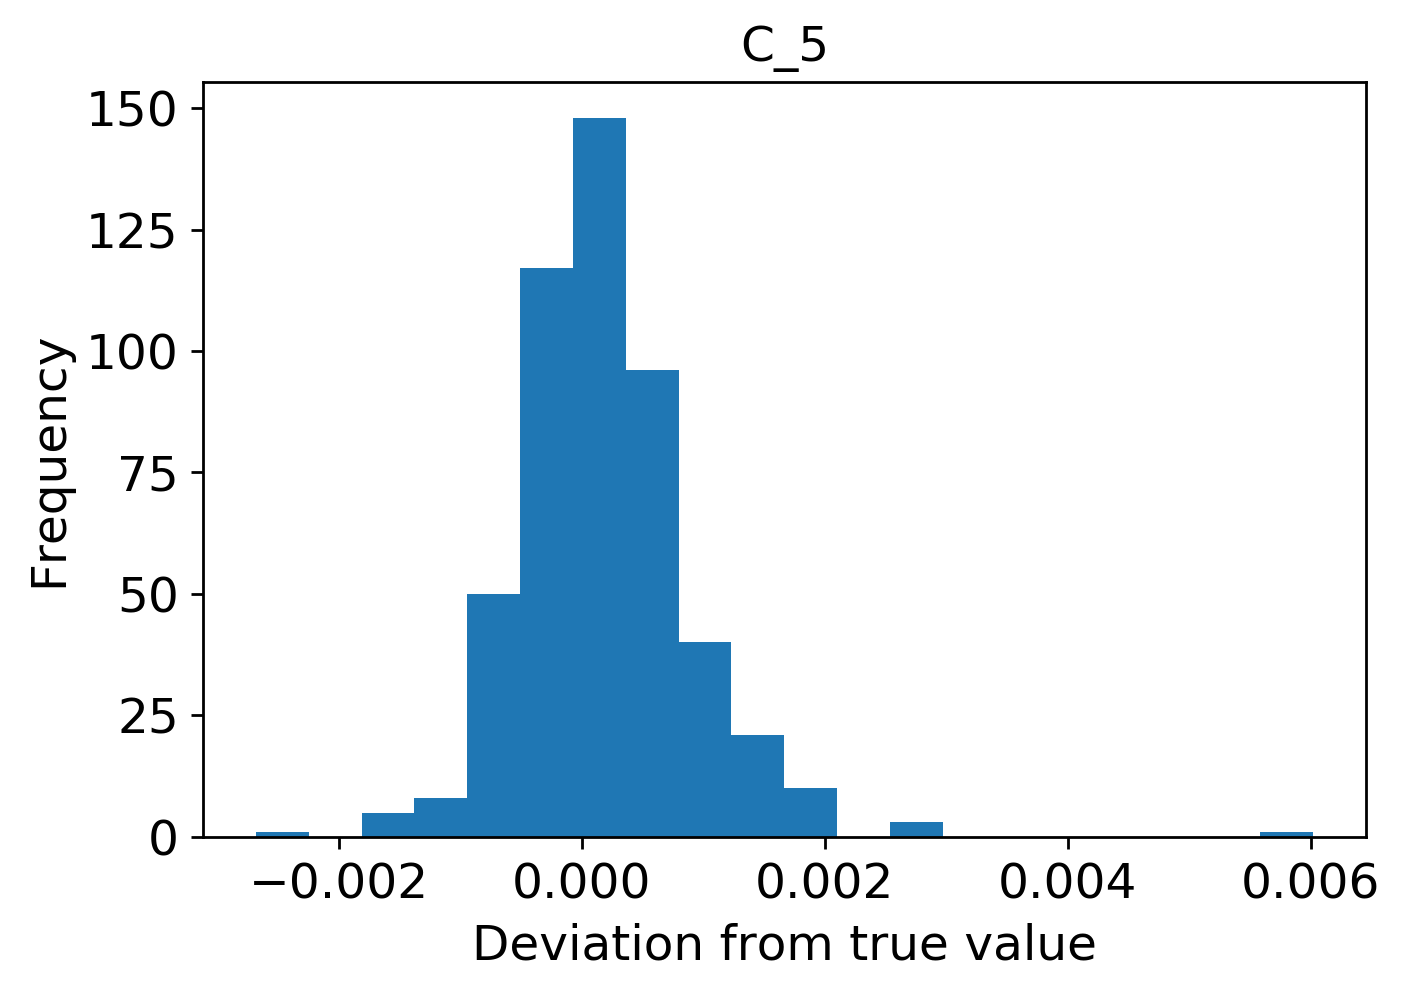

Standard Deviation sample: 0.0007224316707570364
Mean: 3.095195152472505e-05
mode ModeResult(mode=array([-0.00202868]), count=array([1]))
m -2.1059118908325382e-05


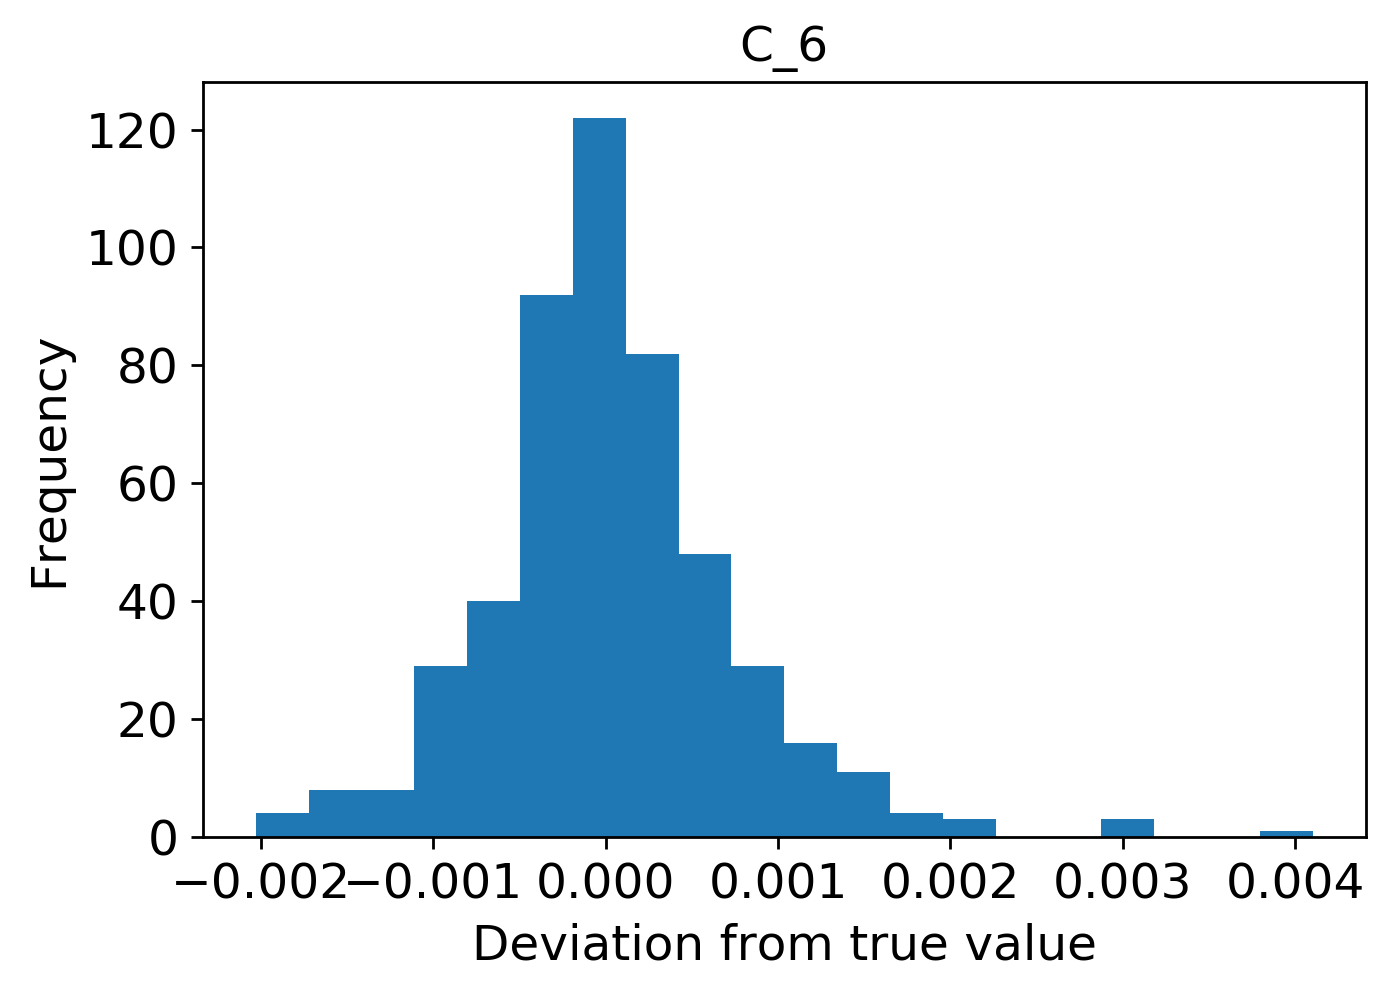

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb
from scipy import stats

import ipdb
#ipdb.set_trace()

datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1800_2_TC_odaka_2_round1/'
resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1800_2_TC_odaka_2_round1/5000/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')

# Load test datasets

X_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')


# Normalize the test datasets
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
X_test_norm =  (X_test - min_x) / (max_x - min_x)


gclass = 6
gclass_name=['841','595','420','297','210','149']
gclass_label = ["841 ${\mu}m$","595 ${\mu}m$","420 ${\mu}m$","297 ${\mu}m$", "210 ${\mu}m$","149 ${\mu}m$"]
topodx = 15.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

# Load outcrop data
outcrop = pd.read_csv('../Journal_2/odaka_increased_class_edit3.csv')
outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0
outcrop_num = len(outcrop['distance'])
print(outcrop)

#Preparation under interpolation
thick_interp_at_outcrop = np.zeros([X_test.shape[0],outcrop_num*gclass])
thick_interp = np.zeros([X_test.shape[0],coord_num*gclass])#Interpolated sample thickness data
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #Index number of sampling point in inverse analysis system
x = np.arange(0,coord_num*topodx,topodx)

# Interpolation of test datasets at the outcrop locations
for i in range(X_test.shape[0]):
    for j in range(gclass):
        f = interp1d(x,X_test_norm[i,j * coord_num : (j+1) * coord_num], kind="cubic",bounds_error=False,fill_value='extrapolate')
        thick_interp_at_outcrop[i,outcrop_num*j:outcrop_num*(j+1)] = f(outcrop['distance']) #Supplemented data

    # Interpolation of test datasets at the grids of the forward model
    for j in range(gclass):
        f = interp1d(outcrop['distance'],thick_interp_at_outcrop[i,j * outcrop_num : (j+1) * outcrop_num], kind="cubic",bounds_error=False,fill_value='extrapolate')
        thick_interp[i,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data
    


#Normalize data
thick_interp[thick_interp < 0] = 0
print(thick_interp)

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
np.savetxt('outcrop_location_interp.txt',test_result_outcrop, delimiter=',')
test_result=np.loadtxt('outcrop_location_interp.txt', delimiter=',')
test_result_normal = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
resi=test_result-y_test
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', 'C_1', 'C_2', 'C_3', 'C_4','C_5','C_6']
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
xymin=[2200,2.0,1.5,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001]
xymax=[4500,10.0,12.0,0.02,0.02,0.02,0.02,0.02,0.02]
xstep=[500,1.5,1.5,0.005,0.005,0.005,0.005,0.005,0.005]
stepmin=[2200,1.0,2.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0000]
stepmax=[4550,10.5,13.0,0.025,0.025,0.025,0.025,0.025,0.025]
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)], label='estimated')
for j in range(gclass):
    plt.plot(x,X_test_norm[0,j * coord_num : (j+1) * coord_num],'o',label='test')
    #plt.plot(outcrop['distance'], thick_interp_at_outcrop[0,outcrop_num*j:outcrop_num*(j+1)],'o',label='test')
plt.plot()
plt.legend()


for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.plot(y_test[:,i],test_result[:,i],"o", markersize=4.5)
    plt.plot(y_test[:,i],test_result_normal[:,i],"*",label='estimate',markersize=3.5)
    x=y_test[:,i]
    y=test_result_normal[:,i]
    y2= test_result_normal[:, i]
    max_value = np.max([x, y, y2])
    min_value = np.min([x, y, y2])
    y_lim = plt.ylim([min_value * 0.8, max_value * 1.1])
    x_lim = plt.xlim([min_value * 0.8, max_value * 1.1])
    plt.plot(x_lim, y_lim, 'k-', color = 'k')
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('True values',color=textcol,size=14,**hfont)
    plt.ylabel('Estimated values',color=textcol,size=14,**hfont)
    plt.legend()
    plt.axes().set_aspect('equal')
    plt.xticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.yticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    #plt.plot(x_lim, y_lim, color = 'k')
    plt.tick_params(labelsize=14,colors='k')
    plt.savefig(resdir+titlelabel[i] + 'outcrop_locationrev' + '.pdf')
    plt.show()

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    print('Standard Deviation sample:', np.std(resi[:,i],ddof=1))
    print('Mean:', np.mean(resi[:,i]))
    print('mode',stats.mode(resi[:,i]))
    print('m',np.median(resi[:,i]))
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist_outcrop_locationrev' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist_outcrop_locationrev' + '.pdf')
    plt.show()

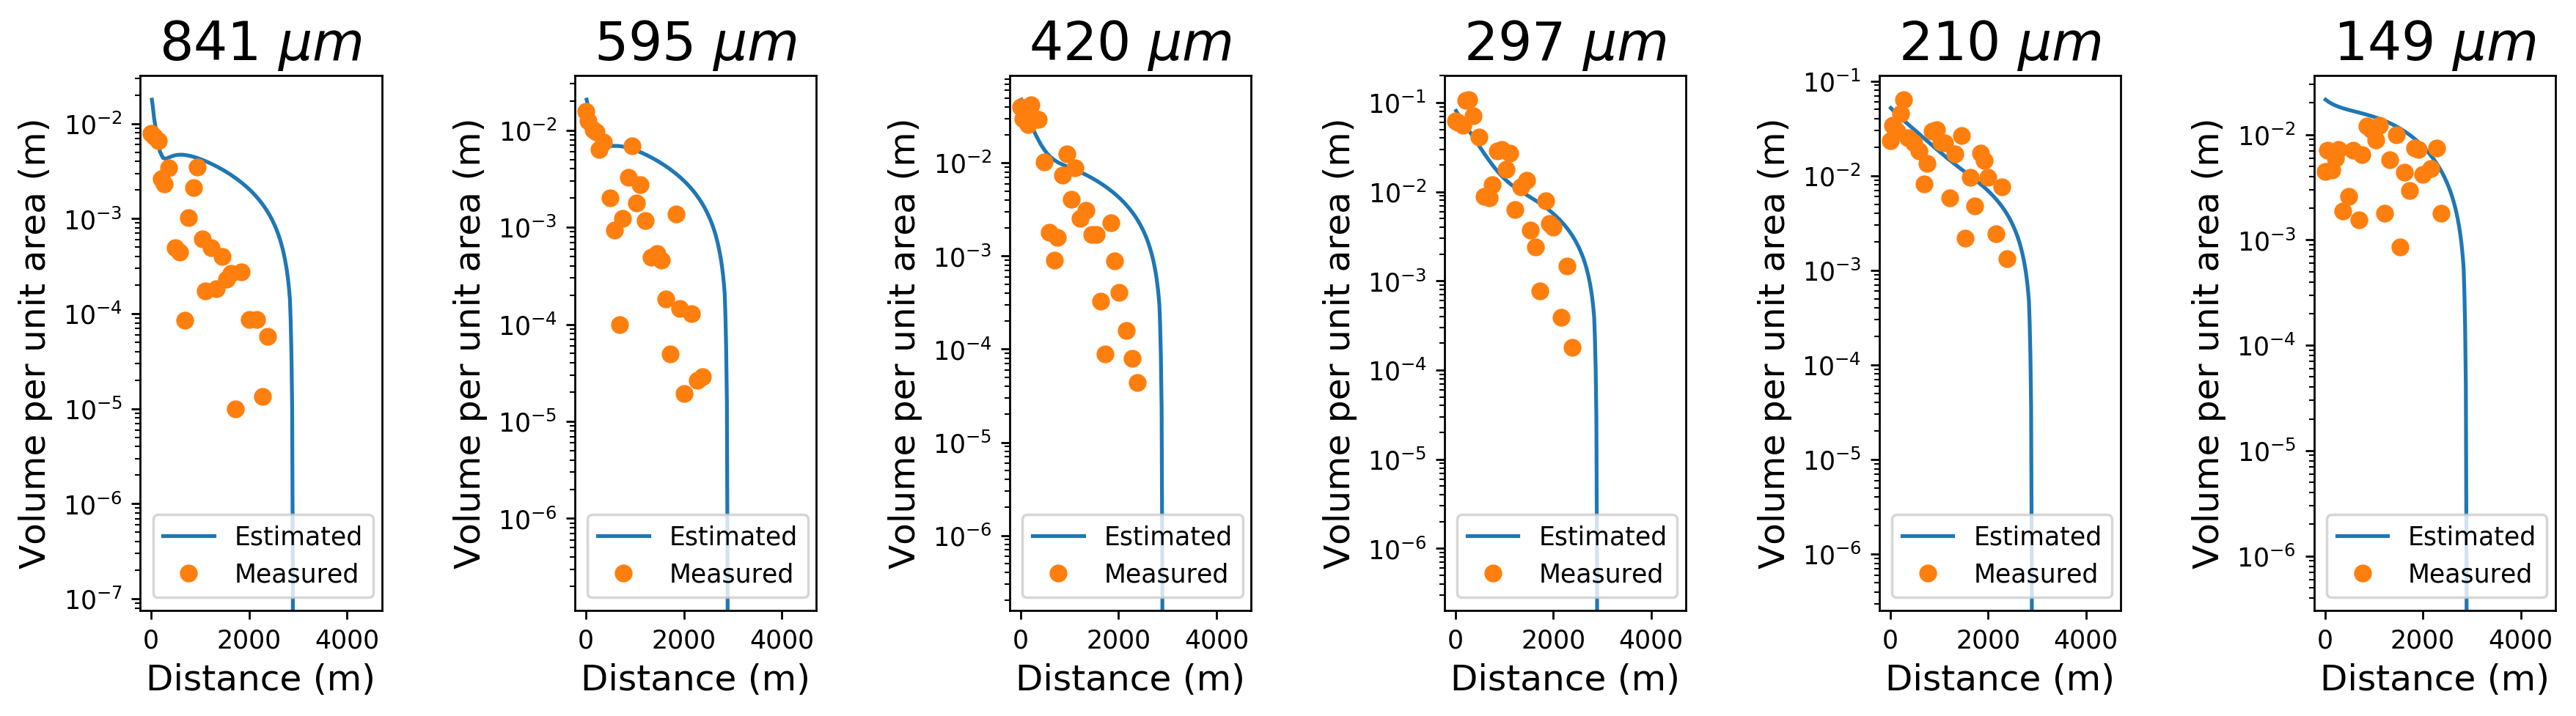

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forward_model_for_DNN_J2_odaka_GS_round2200 as fmodel
import time
import ipdb
%matplotlib inline

#Basic setting

#dist_max = 3000.
gclass = 6
topodx=15.0

gname_tex = ["841 ${\mu}m$","595 ${\mu}m$","420 ${\mu}m$","297 ${\mu}m$", "210 ${\mu}m$","149 ${\mu}m$"]
gclass_name=['841','595','420','297','210','149']


estimated_icond=np.loadtxt('outcrop_result_g6_g300_j2_roi1800_2_TC_cubic_odaka_round1rev.txt', delimiter=',')
start = time.time()
fmodel.read_setfile("config_g6_300grid_j2_gs_round.ini")
(x,C,x_dep,deposit) = fmodel.forward(estimated_icond)
np.savetxt('eta_estimated_thickness_5K_g6_j2_roi1800_2e.csv', deposit, delimiter=',')
np.savetxt('eta_estimated_Distance_5K_g6_j2_roi1800_2e.csv', x_dep,delimiter=',')
estimated_dep_thickness_5000=np.transpose(np.loadtxt('/home/rimali2009/Journal_2/'+'eta_estimated_thickness_5K_g6_j2_roi1800_2e.csv', delimiter=','))
estimated_dep_thickness_5000=pd.DataFrame(estimated_dep_thickness_5000,columns=['841','595','420','297','210','149'])
estimated_dep_distance_5000=np.transpose(np.loadtxt('/home/rimali2009/Journal_2/'+'eta_estimated_Distance_5K_g6_j2_roi1800_2e.csv', delimiter=','))
estimated_dep_distance_5000=pd.DataFrame(estimated_dep_distance_5000,columns=['distance'])
estimated_dep_5000=pd.concat([estimated_dep_distance_5000,estimated_dep_thickness_5000],axis=1)
np.savetxt('estimated_dep_5K_g6_j2_roi1800_2e.csv',estimated_dep_5000,delimiter=',')

estimated_dep_5000= estimated_dep_5000.query('distance > 0')
#estimated_dep_5000 = estimated_dep_5000.query('distance < {}'.format(dist_max))

#Read original data
outcrop = pd.read_csv('../Journal_2/odaka_increased_class_edit3.csv')
outcrop= pd.DataFrame(outcrop,columns=['distance','841','595','420','297','210','149'])

#Plot
plt.figure(num=None, figsize=(17, 4), dpi=250, facecolor='w', edgecolor='g')
hfont = {'fontname':'Sans'}
plt.subplots_adjust(bottom=0.15, wspace=0.8)

for i in range(gclass):
    plt.subplot(1,gclass,i+1)
    plt.plot(estimated_dep_5000['distance'],estimated_dep_5000[gclass_name[i]],'-', label='Estimated')
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
    plt.yscale('log')
    #plt.ylim([0.000001,1])
    plt.title(gname_tex[i], size=21,**hfont)
    plt.xlabel('Distance (m)', size = 14, **hfont)
    plt.ylabel('Volume per unit area (m)', size = 14, **hfont)
    plt.legend(fontsize=10)
    plt.savefig("thickness_distance_curve_5000_g6_j2_roi1800_2e.png")
    plt.savefig("thickness_distance_curve_5000_g6_j2_roi1800_2e.eps")
    plt.savefig("thickness_distance_curve_5000_g6_j2_roi1800_2e.pdf")
plt.show()

<Figure size 1750x1000 with 2 Axes>

(5000, 9)
(5000, 1800)


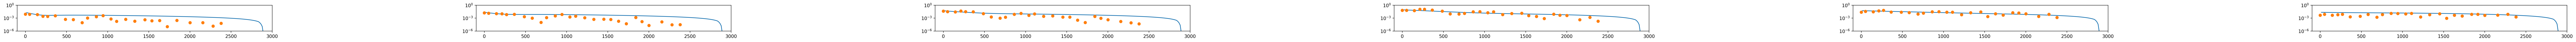

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forward_model_for_DNN_J2_odaka_GS_round2200 as fmodel
import time
import ipdb
%matplotlib inline

#Basic setting

#dist_max = 3000.
gclass = 6
topodx=15.0

gname_tex = ["841 ${\mu}m$","595 ${\mu}m$","420 ${\mu}m$","297 ${\mu}m$", "210 ${\mu}m$","149 ${\mu}m$"]
gclass_name=['841','595','420','297','210','149']


estimated_icond=np.loadtxt('outcrop_result_g6_g300_j2_roi1800_2_TC_cubic_odaka_round1rev.txt', delimiter=',')
start = time.time()
fmodel.read_setfile("config_g6_300grid_j2_gs_round.ini")
(x,C,x_dep,deposit) = fmodel.forward(estimated_icond)
np.savetxt('eta_estimated_thickness_5K_g6_j2_roi1800_2.csv', deposit, delimiter=',')
np.savetxt('eta_estimated_Distance_5K_g6_j2_roi1800_2.csv', x_dep,delimiter=',')
estimated_dep_thickness_5000=np.transpose(np.loadtxt('/home/rimali2009/Journal_2/'+'eta_estimated_thickness_5K_g6_j2_roi1800_2.csv', delimiter=','))
estimated_dep_thickness_5000=pd.DataFrame(estimated_dep_thickness_5000,columns=['841','595','420','297','210','149'])
estimated_dep_distance_5000=np.transpose(np.loadtxt('/home/rimali2009/Journal_2/'+'eta_estimated_Distance_5K_g6_j2_roi1800_2.csv', delimiter=','))
estimated_dep_distance_5000=pd.DataFrame(estimated_dep_distance_5000,columns=['distance'])
estimated_dep_5000=pd.concat([estimated_dep_distance_5000,estimated_dep_thickness_5000],axis=1)
np.savetxt('estimated_dep_5K_g6_j2_roi1800_2.csv',estimated_dep_5000,delimiter=',')

estimated_dep_5000= estimated_dep_5000.query('distance > 0')
#estimated_dep_5000 = estimated_dep_5000.query('distance < {}'.format(dist_max))

#Read original data
outcrop = pd.read_csv('../Journal_2/odaka_increased_class_edit3.csv')
outcrop= pd.DataFrame(outcrop,columns=['distance','841','595','420','297','210','149'])


plt.figure(num=None, figsize=(100, 1), dpi=250, facecolor='w', edgecolor='g')
hfont = {'fontname':'Sans'}
plt.subplots_adjust(bottom=0.10, wspace=0.8)

for i in range(gclass):
    plt.subplot(1,gclass,i+1)
    plt.plot(estimated_dep_5000['distance'],estimated_dep_5000[gclass_name[i]],'-', label='Estimated')
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
    plt.yscale('log')
    plt.ylim([0.000001,1.0])
    plt.xlim(-100,3000)
    plt.savefig("thickness_distance_curve_5000_g6_odaka2.eps")
plt.show()

Using TensorFlow backend.


    distance       841       595       420       297       210       149
0          0  0.007906  0.015610  0.039802  0.062111  0.023617  0.004499
1         52  0.007303  0.012544  0.029795  0.060147  0.034320  0.007157
2        147  0.006591  0.010183  0.025940  0.055353  0.029294  0.004642
3        214  0.002612  0.009665  0.042366  0.105662  0.045116  0.005972
4        271  0.002332  0.006321  0.030175  0.107966  0.063558  0.007262
5        364  0.003398  0.007496  0.029200  0.070910  0.025199  0.001880
6        487  0.000495  0.002003  0.010195  0.041490  0.022317  0.002599
7        583  0.000448  0.000929  0.001784  0.008833  0.018146  0.007056
8        690  0.000086  0.000100  0.000912  0.008526  0.008212  0.001553
9        756  0.001027  0.001242  0.001588  0.011941  0.013520  0.006497
10       863  0.002118  0.003245  0.007448  0.028683  0.029339  0.012089
11       944  0.003506  0.006849  0.012450  0.029527  0.030557  0.011203
12      1040  0.000615  0.001772  0.004087  0.01772

    distance       841       595       420       297       210       149
0          0  0.007906  0.015610  0.039802  0.062111  0.023617  0.004499
1         52  0.007303  0.012544  0.029795  0.060147  0.034320  0.007157
2        147  0.006591  0.010183  0.025940  0.055353  0.029294  0.004642
3        214  0.002612  0.009665  0.042366  0.105662  0.045116  0.005972
4        271  0.002332  0.006321  0.030175  0.107966  0.063558  0.007262
5        364  0.003398  0.007496  0.029200  0.070910  0.025199  0.001880
6        487  0.000495  0.002003  0.010195  0.041490  0.022317  0.002599
7        690  0.000086  0.000100  0.000912  0.008526  0.008212  0.001553
8        756  0.001027  0.001242  0.001588  0.011941  0.013520  0.006497
9        863  0.002118  0.003245  0.007448  0.028683  0.029339  0.012089
10       944  0.003506  0.006849  0.012450  0.029527  0.030557  0.011203
11      1040  0.000615  0.001772  0.004087  0.017722  0.022640  0.008915
12      1110  0.000173  0.002733  0.008874  0.02734

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


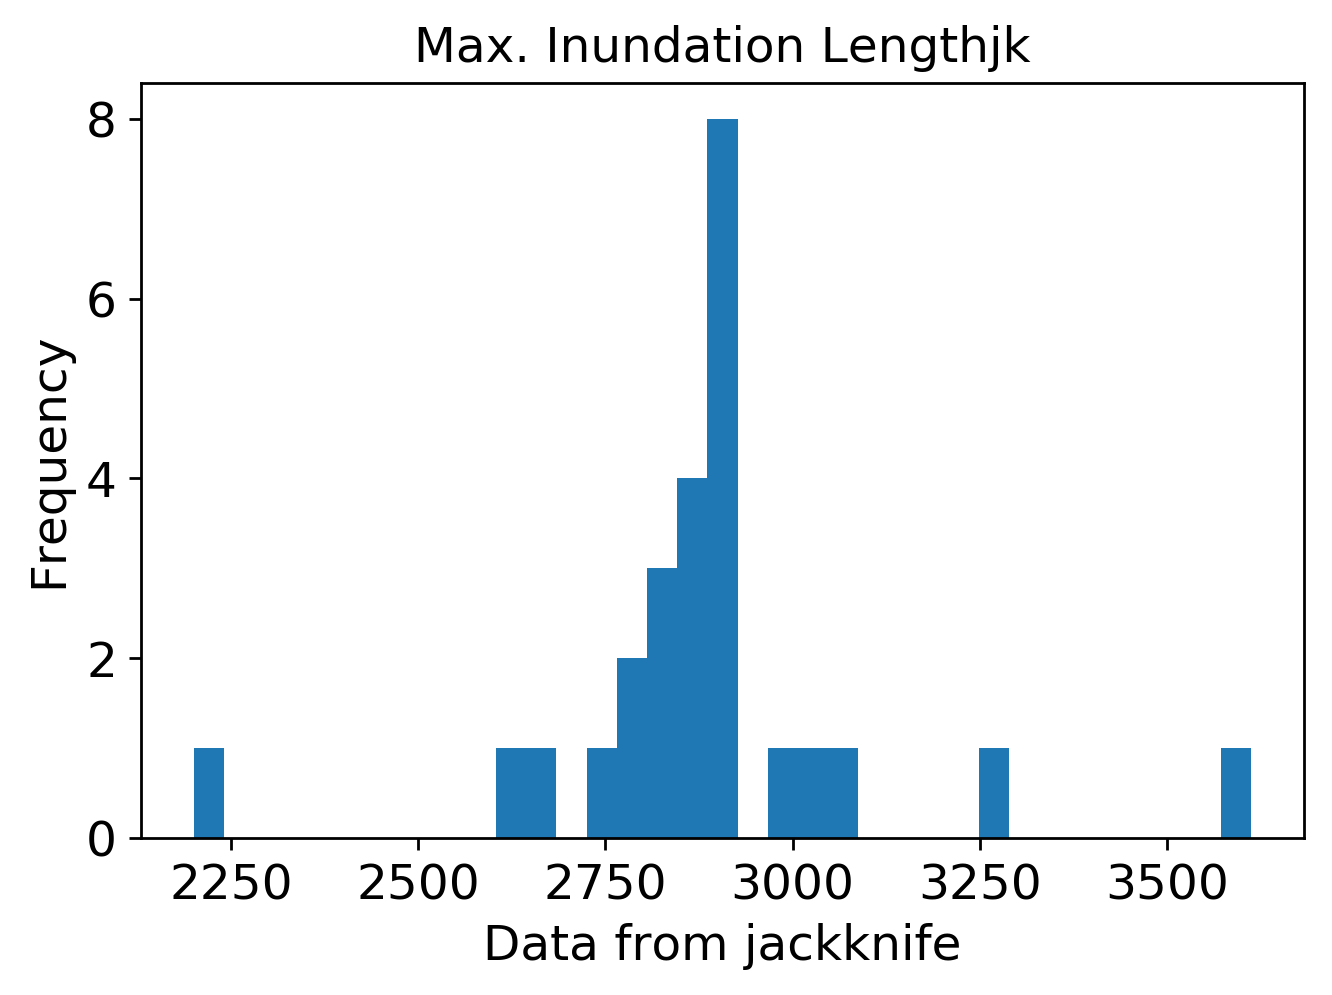

mean: 11.897717329669291
jk_e: 0.22412180587280467
CI 0.4392787395106971


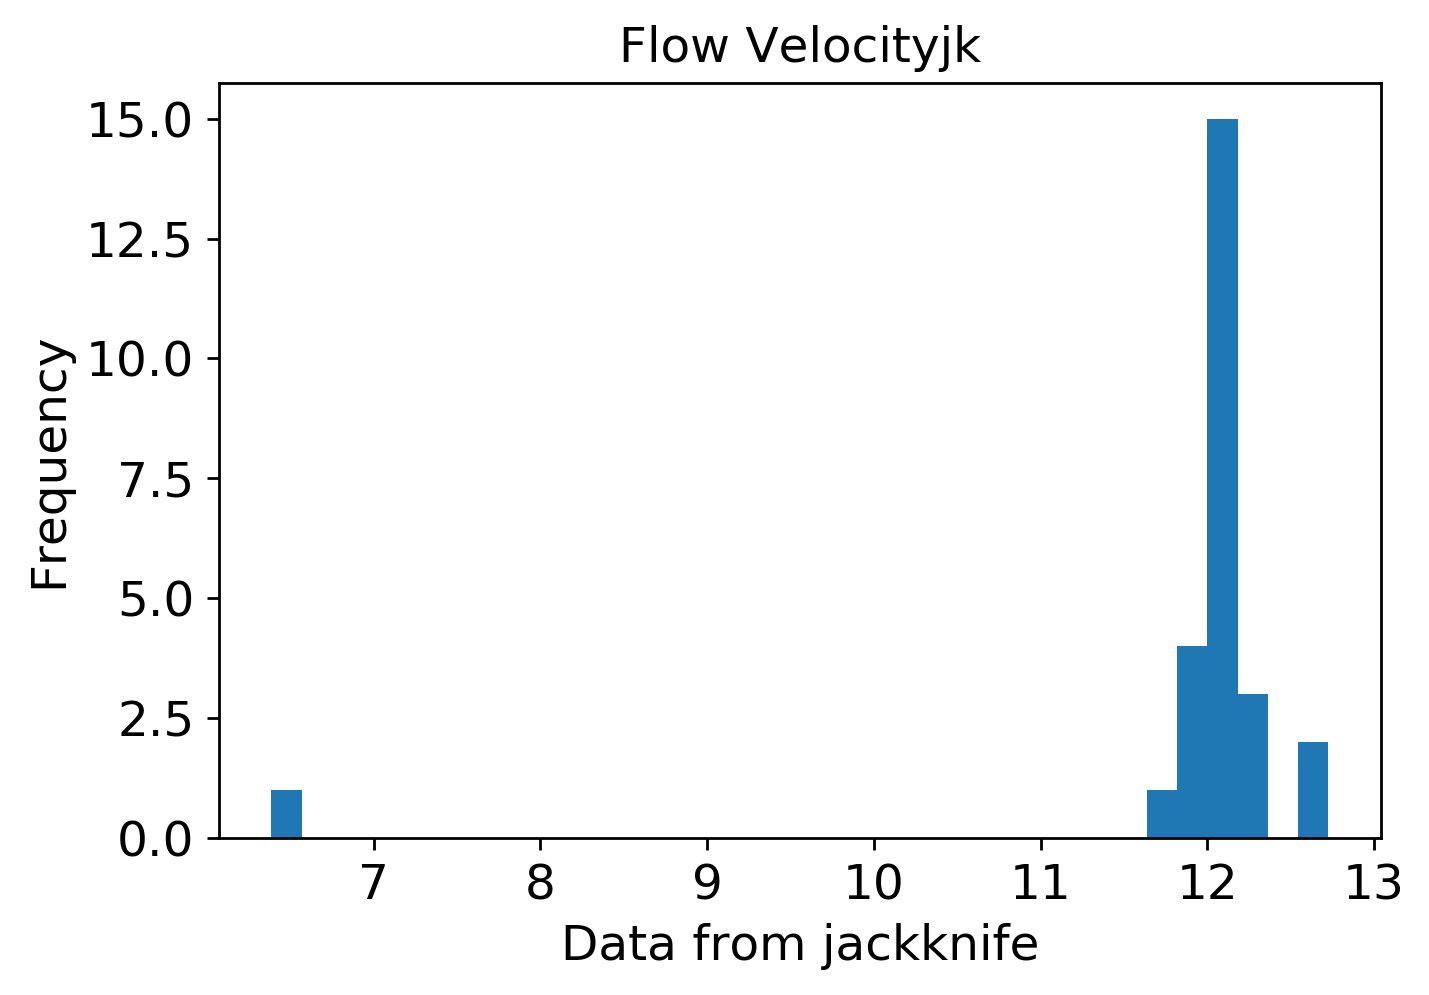

mean: 2.430970591444246
jk_e: 0.06098964537182108
CI 0.11953970492876932


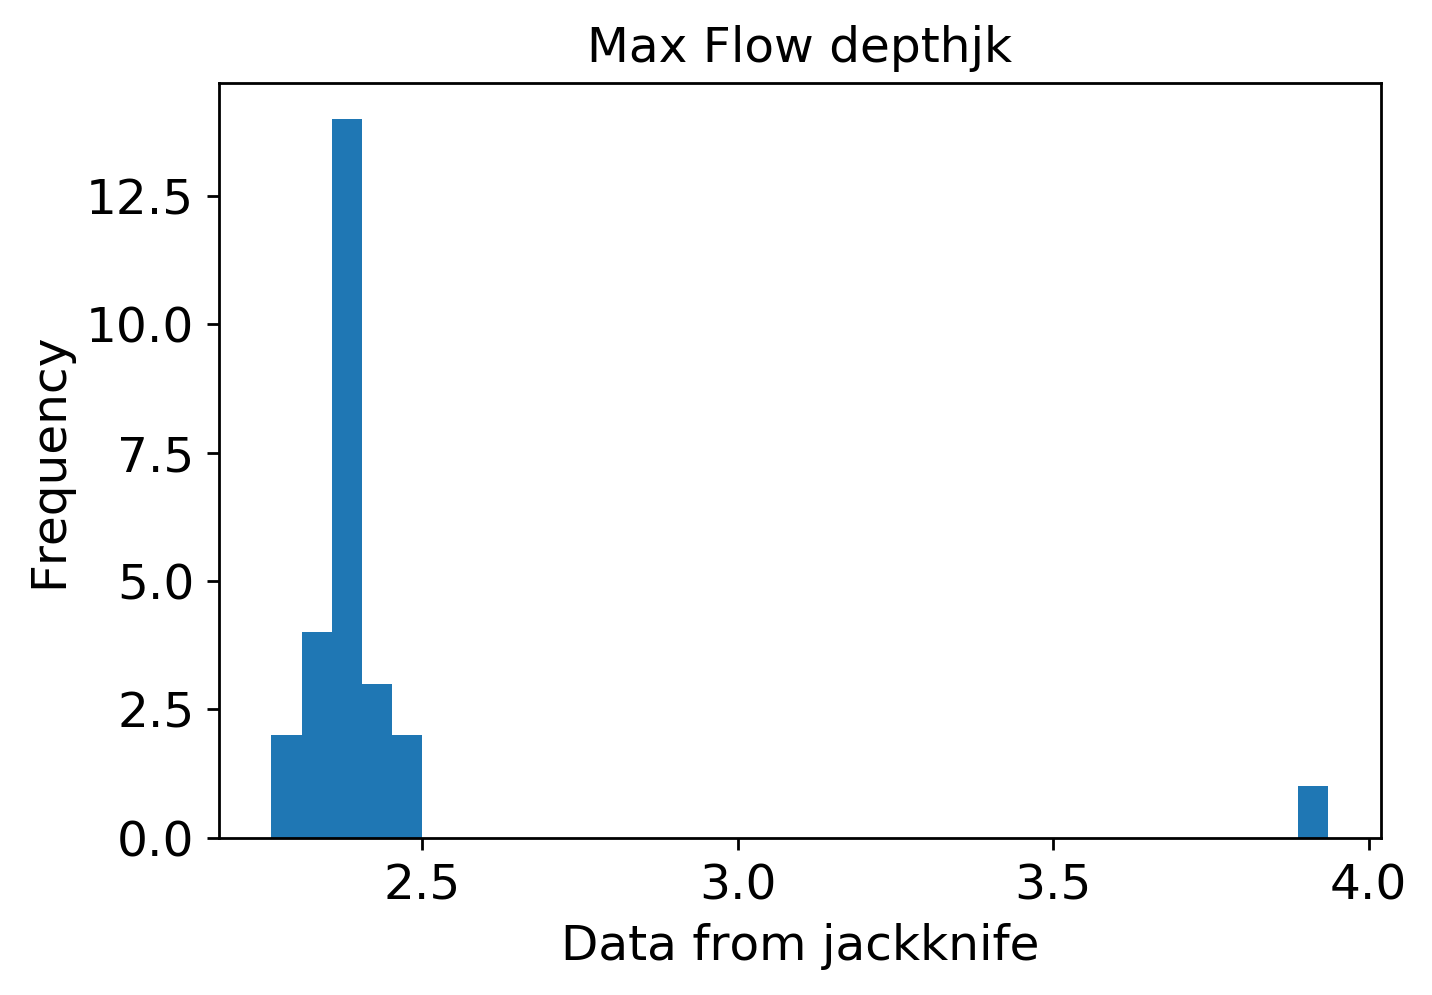

mean: 0.004920330676253317
jk_e: 0.0001774041992674242
CI 0.0003477122305641514


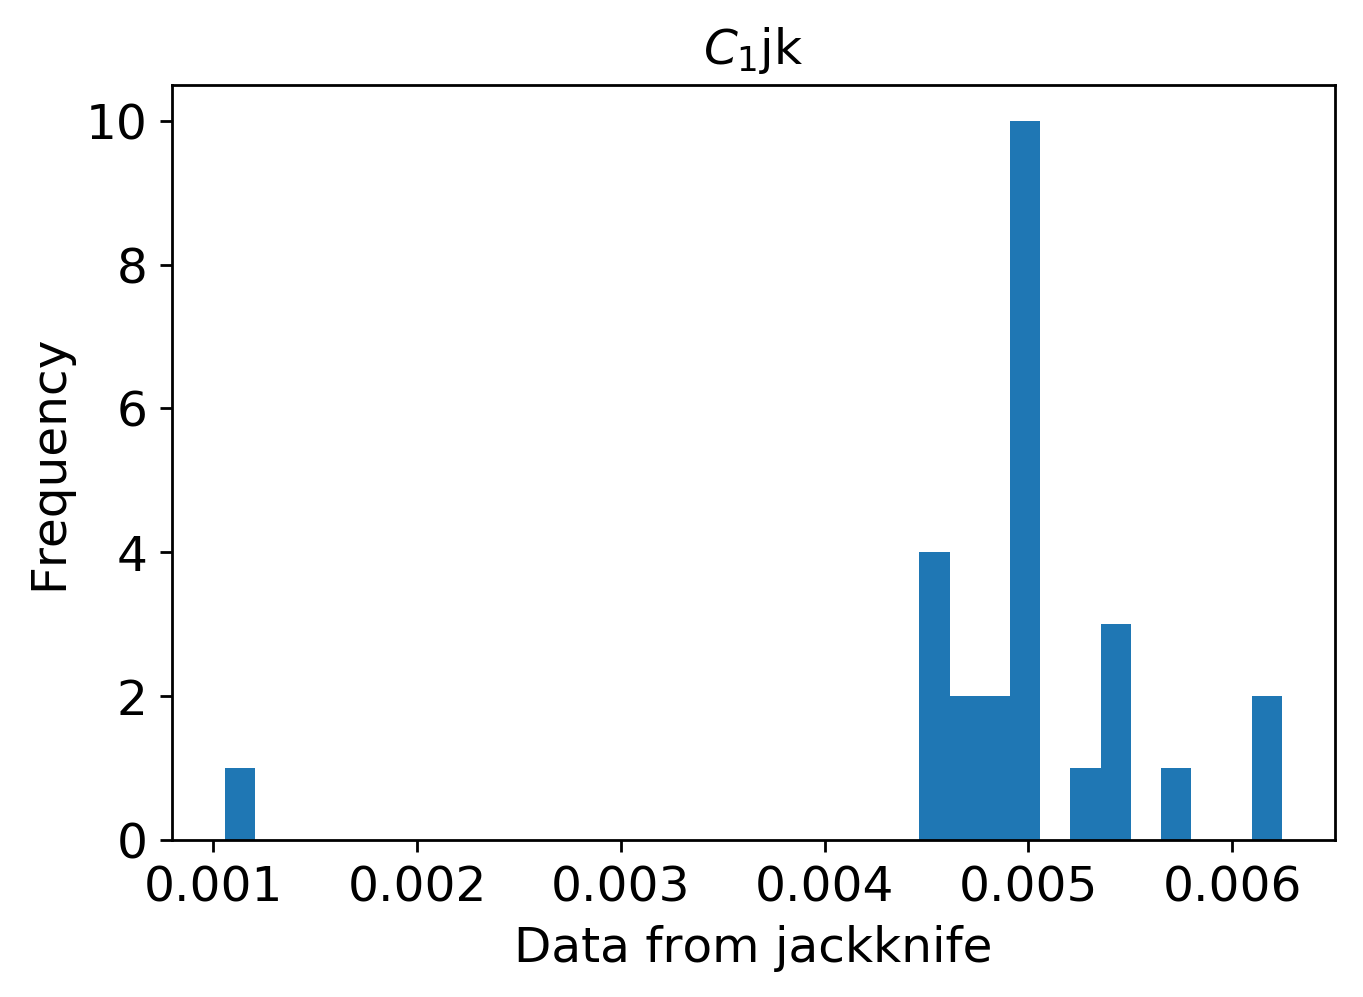

mean: 0.005547526800025341
jk_e: 0.00012560268843348003
CI 0.0002461812693296209


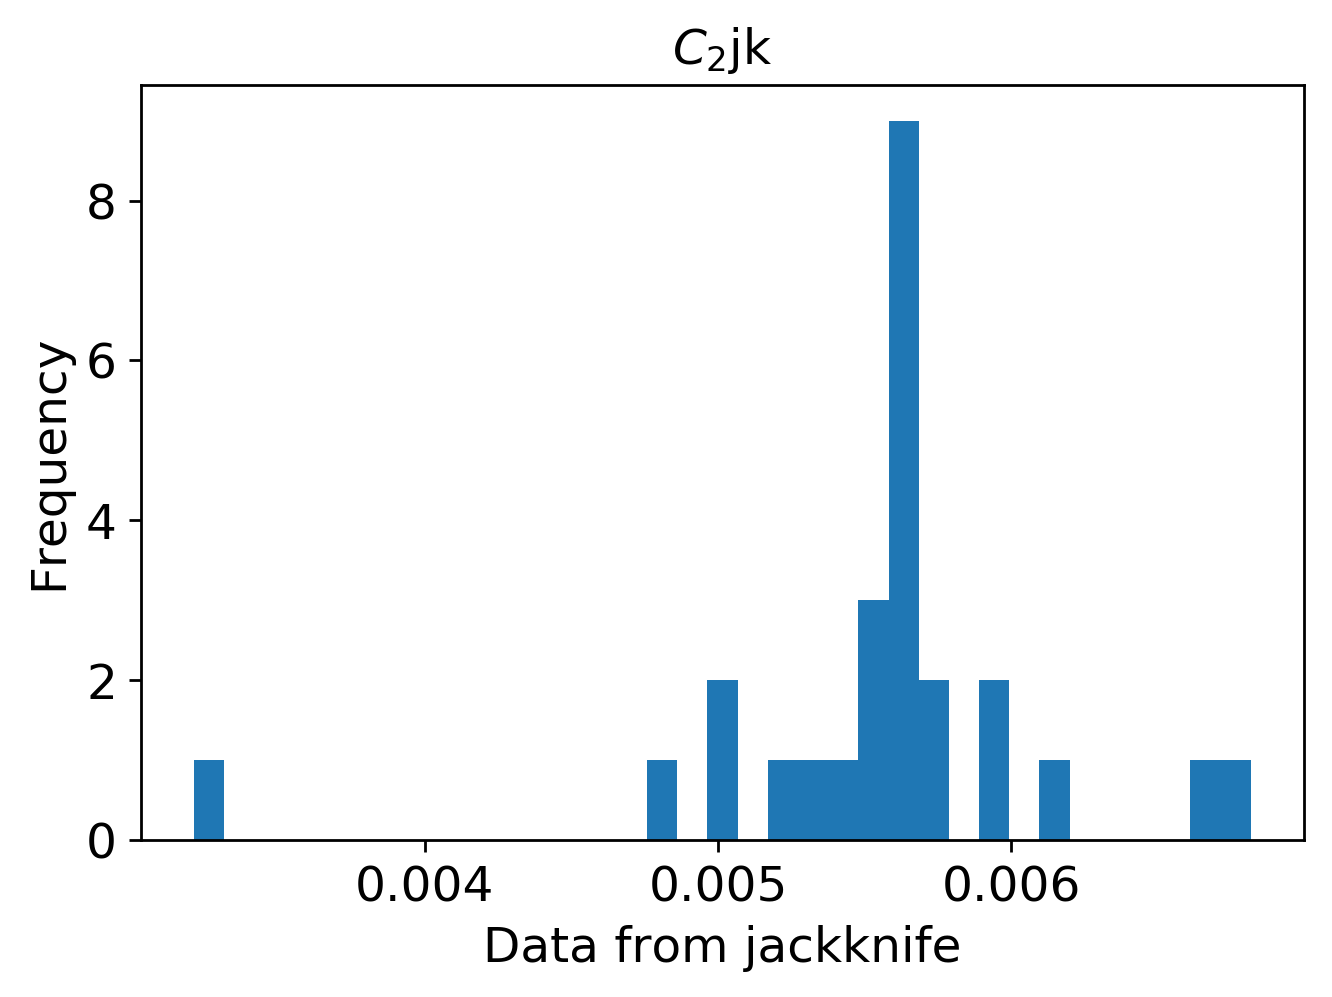

mean: 0.012614017644650973
jk_e: 0.00019880530879097129
CI 0.0003896584052303037


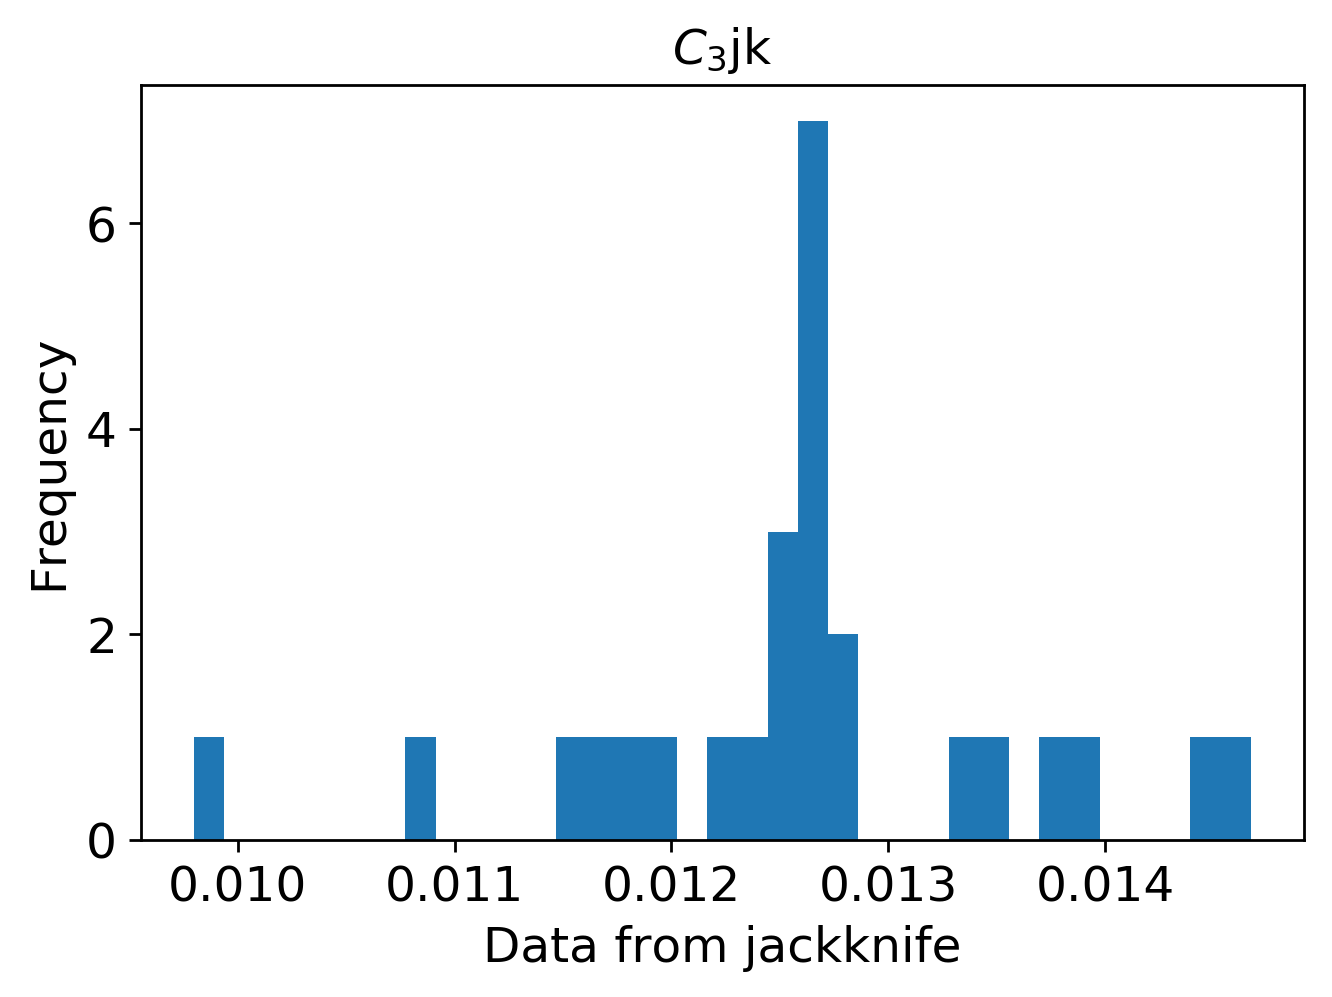

mean: 0.02088316030248352
jk_e: 0.00021811384083075323
CI 0.0004275031280282763


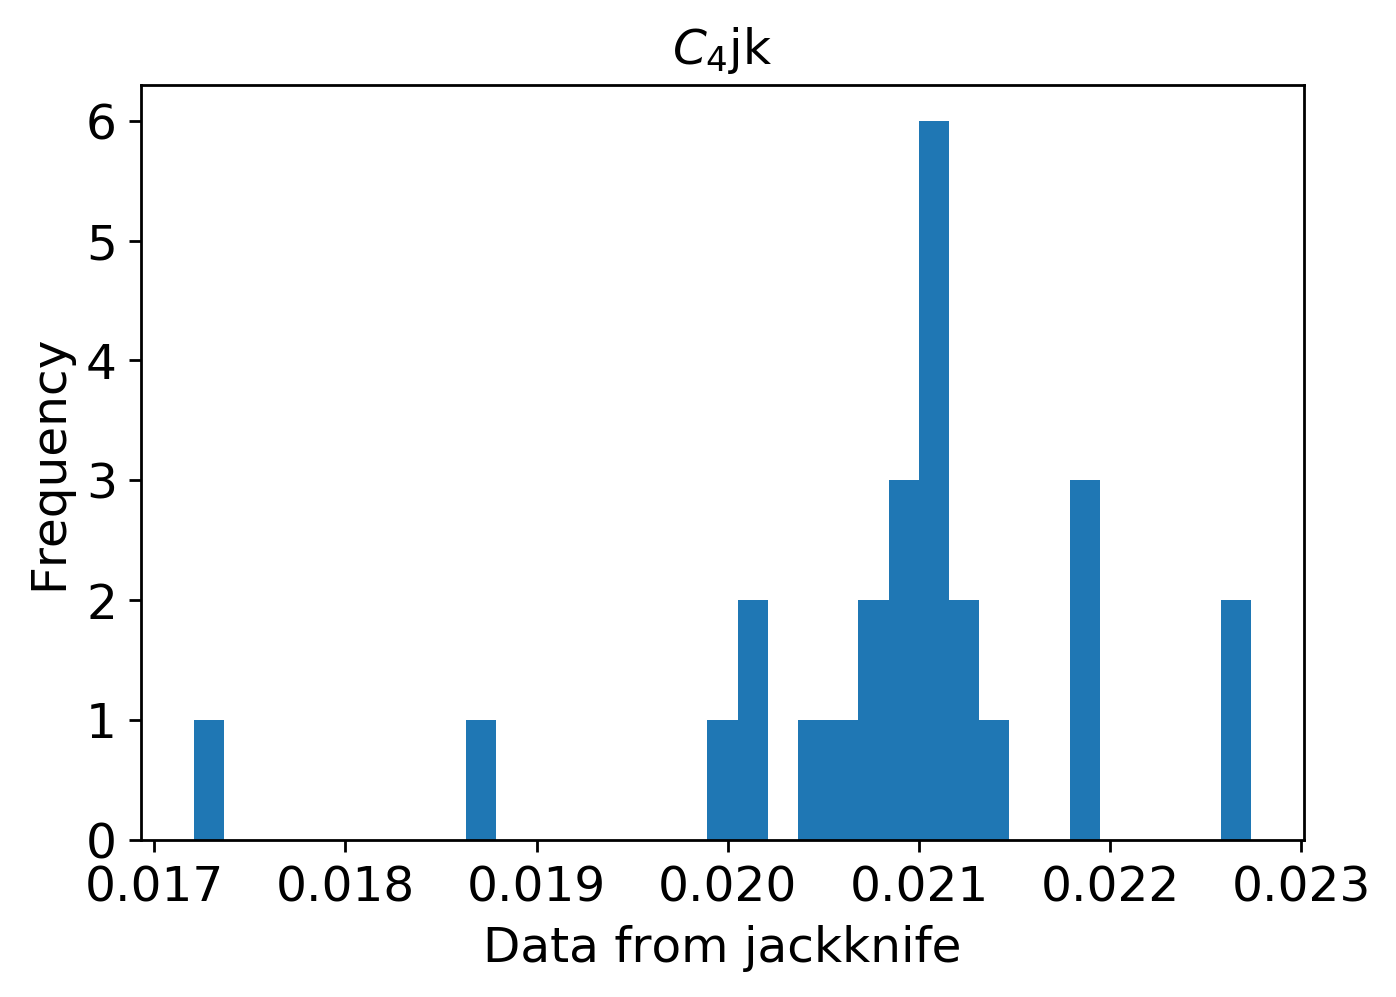

mean: 0.013281078856158488
jk_e: 0.000260162045000199
CI 0.00050991760820039


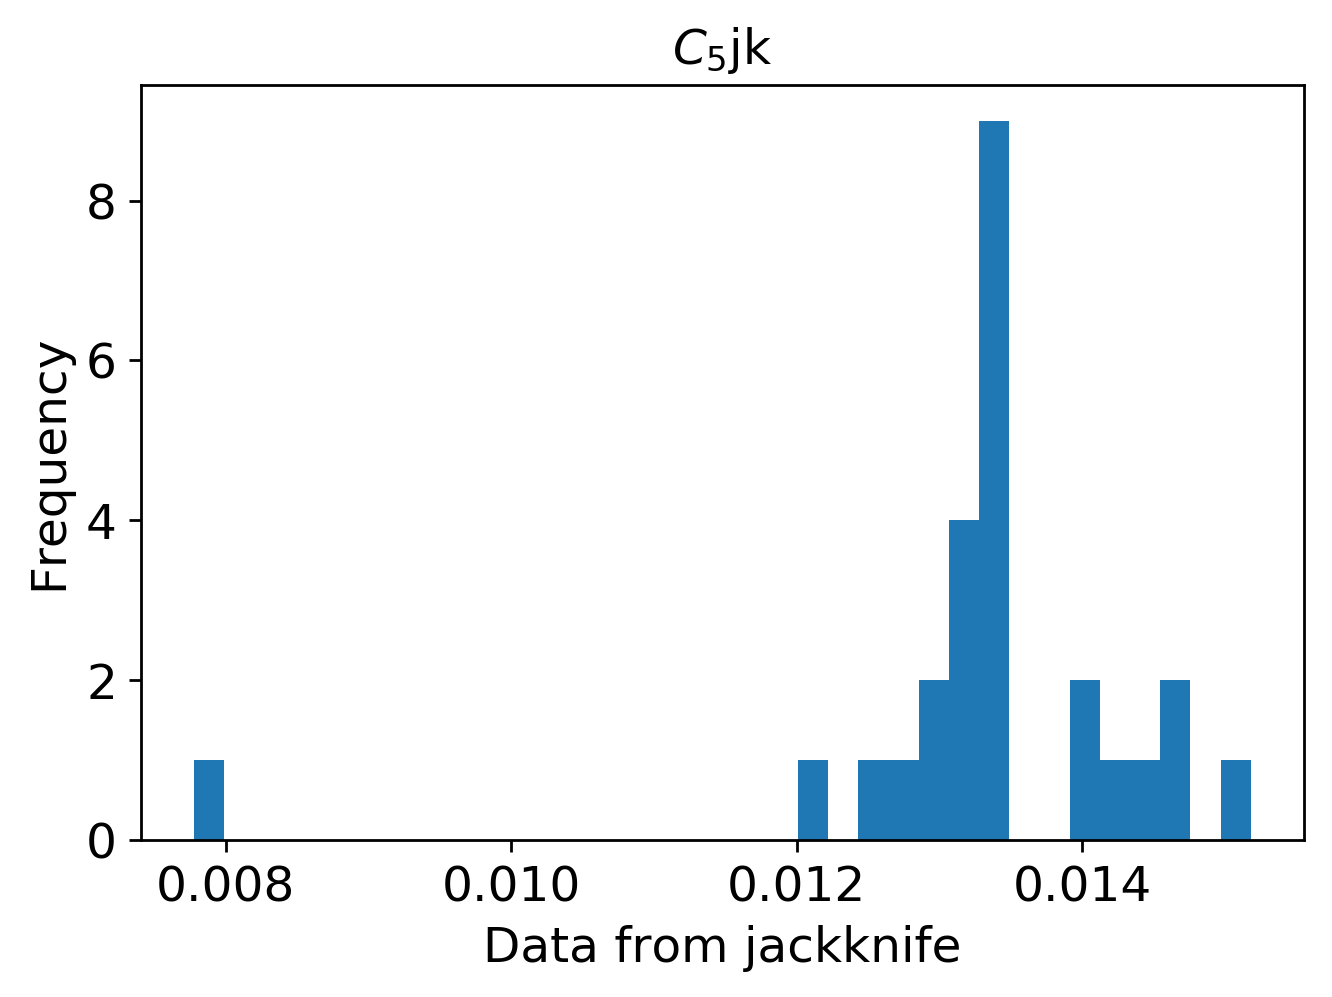

mean: 0.005453455002187546
jk_e: 0.00020774313592897254
CI 0.00040717654642078615


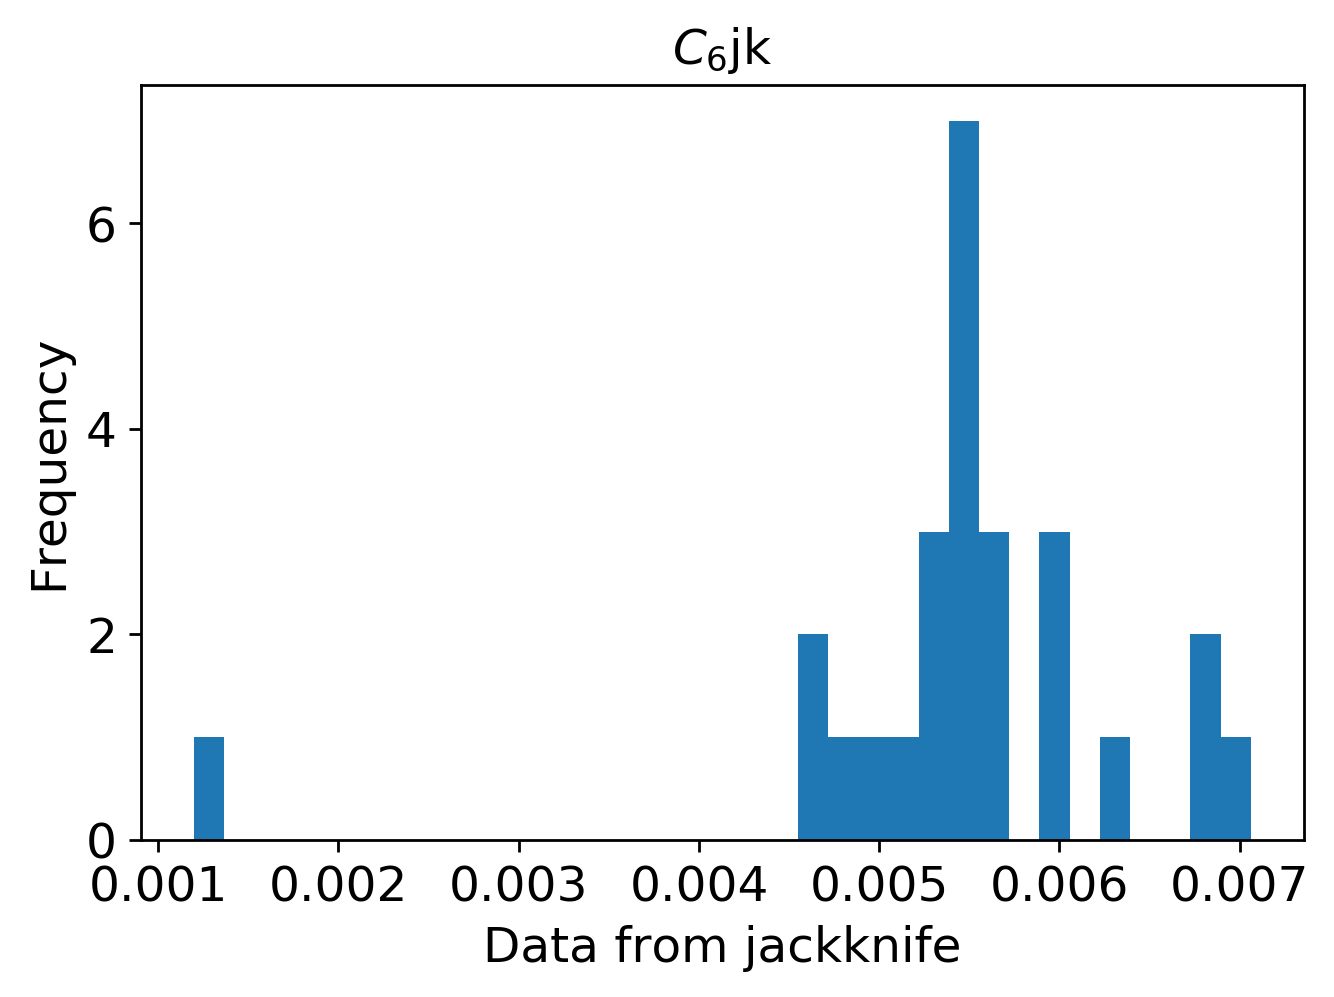

In [1]:
# Jackknife Method
import csv
import numpy as np
import pandas as pd
import math
from keras.models import load_model
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1800_2_TC_odaka_2_round1/'
resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1800_2_TC_odaka_2_round1/5000/'
# Initial setting
if not "model" in locals():
    model = load_model(resdir+'model3.hdf5')
gclass = 6
#gclass_label = ["406 ${\mu}m$", "268 ${\mu}m$",
                #"177 ${\mu}m$", "117 ${\mu}m$"]
topodx = 15.0
coord_num = int(model.layers[0].input_shape[1]/gclass)
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt', delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt', delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt', delimiter=',')


a = pd.read_csv(
    '../Journal_2/odaka_increased_class_edit3.csv', delimiter=',')
print(a)
y = pd.DataFrame()
output = []

with open('output_final_j2_roi1800_TC_6_1rev.csv', 'w') as outfile:

    # x=[]
    for index in range(len(a)):
        df = y.append(pd.read_csv(
            '../Journal_2/odaka_increased_class_edit3.csv', skiprows=[index+1]))
        print(df)
        df = df.sort_values('distance')
        thick_interp = np.zeros([1, coord_num*gclass])
        x = np.arange(0, coord_num*topodx, topodx)
        for j in range(gclass):
            # Interpolation function of jth granularity level
            f = interp1d(df['distance'], df.iloc[:, j+1],
                         kind="cubic", bounds_error=False,fill_value='extrapolate')
            thick_interp[0, coord_num*j:coord_num*(j+1)] = f(x)
        thick_interp[thick_interp < 0] = 0
        thick_interp_norm = (thick_interp - min_x) / (max_x - min_x)
        test_result_outcrop = model.predict(thick_interp_norm)
        test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
        print(test_result_outcrop.shape)
        print(test_result_outcrop)
    # output.append(test_result_outcrop)
        np.savetxt(outfile,test_result_outcrop, delimiter=',')
        # outfile.write('# New iteration\n')
hfont = {'fontname': 'Century Gothic'}
textcol = 'k'
resi = np.loadtxt('output_final_j2_roi1800_TC_6_1rev.csv', delimiter=',')
titlelabel = ['Max. Inundation Lengthjk','Flow Velocityjk', 'Max Flow depthjk',
              '$C_1$jk', '$C_2$jk', '$C_3$jk', '$C_4$jk','$C_5$jk','$C_6$jk']
jk_er=[]
with open('jk_e_1800_j2_6_1.txt','wb') as ftext:
    for i in range(len(titlelabel)):
        plt.figure(num=None, dpi=250, facecolor='w', edgecolor='k')
        plt.hist(resi[:, i], bins=35)
        mean = sum(resi[:,i]) / len(resi[:,i])
        print("mean:",mean)
        var_jk  = sum(pow(x-mean,2) for x in resi[:,i]) / ((len(resi[:,i])-1)*(len(resi[:,i])))
        jk_e= math.sqrt(var_jk)
        #ci_u=mean+(1.96*jk_e)
        #ci_l=mean-(1.96*jk_e)
        CI=(1.96*jk_e)
        print("jk_e:",jk_e)
        #print("CI_u", ci_u)
        #print("CI_l",ci_l)
        print("CI",CI)
        e=np.append(jk_e,jk_er)
        np.savetxt(ftext,e,delimiter=',')
        plt.title(titlelabel[i], color=textcol, size=14, **hfont)
        plt.xlabel('Data from jackknife', color=textcol, size=14, **hfont)
        plt.ylabel('Frequency', color=textcol, size=14, **hfont)
        plt.tick_params(labelsize=14, colors=textcol)
        plt.savefig(resdir+titlelabel[i] + 'jkhistrev' + '.eps')
        plt.savefig(resdir+titlelabel[i] + 'jkhistrev' + '.pdf')
        plt.show()